## 1.0 - Importing packages

In [10]:
import os
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn import svm
import seaborn as sb
import pandas as pd
import numpy as np
import itertools

from sklearn.svm import LinearSVC as SVC
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import plotly as ply
import timeit

## 2.0 - Functions

In [323]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def classif_score_builder(xtrain,xval,xtest,ytrain,yval,ytest,features,tvt):
    
    pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
        ('std_scaler', StandardScaler())
    ])
    
    xtrain_bestf=xtrain.loc[:, xtrain.columns.isin(features)]
    xval_bestf=xval.loc[:, xval.columns.isin(features)]
    xtest_bestf=xtest.loc[:, xtest.columns.isin(features)]
    
    xtrain_scalef = pd.DataFrame(pipeline.fit_transform(xtrain_bestf),columns=features)
    xval_scalef = pd.DataFrame(pipeline.transform(xval_bestf),columns=features)
    xtest_scalef = pd.DataFrame(pipeline.transform(xtest_bestf),columns=features)
           
    model = SVC(kernel='linear')
    model.fit(xtrain_scalef, ytrain)
    if tvt=='train':
        y_pred=model.predict(xtrain_scalef)
        ytrue=ytrain
    elif tvt=='val':
        y_pred=model.predict(xval_scalef)
        ytrue=yval
    elif tvt=='test':
        y_pred=model.predict(xtest_scalef)
        ytrue=ytest
    else:
        print("incorrect inputs")

    acc=classification_report(ytrue, y_pred, output_dict=True)['accuracy']
    p=classification_report(ytrue, y_pred,output_dict=True)['macro avg']['precision']
    r=classification_report(ytrue, y_pred,output_dict=True)['macro avg']['recall']
    f1=classification_report(ytrue, y_pred,output_dict=True)['macro avg']['f1-score']
    auc=roc_auc_score(ytrue, y_pred)
    
    scores=list([acc,p,r,f1,auc])
    
    return scores

def svm_feature_ranking(frequency_list,coef):
    feat_ranking=pd.DataFrame({'freq':frequency_list,'coef':np.ravel(coef)**2})
    feat_ranking.sort_values('coef',ascending=False)
    return feat_ranking

def print_score(clf, X_train, y_train, X_val, y_val, X_test , y_test, tvt):  # tvt == train, val or test
    if tvt=='train':
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif tvt=='val':
        pred = clf.predict(X_val)
        clf_report = pd.DataFrame(classification_report(y_val, pred, output_dict=True))
        print("Validation Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_val, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_val, pred)}\n")
        
    elif tvt=='test':
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
        
    else:
        print("Please specify data split to verify on i.e train, val or test")

In [12]:
a_data = pd.read_csv('00 - Dataset/02 - Cleaning Results/a_data.csv')
a_freq=a_data.filter(regex='f',axis=1)

## 3.0 - Dataset

### 00 - Original Set

<AxesSubplot:xlabel='OverallPoF', ylabel='count'>

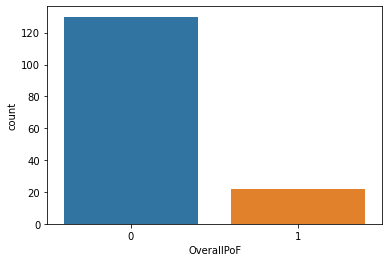

In [13]:
X_train0=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\00 - Original\\X_train.csv")
X_val0=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\00 - Original\\X_val.csv")
X_test0=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\00 - Original\\X_test.csv")
y_train0=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\00 - Original\\y_train.csv")
y_val0=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\00 - Original\\y_val.csv")
y_test0=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\00 - Original\\y_test.csv")
sb.countplot(y_train0['OverallPoF'],fill='OverallPoF')

In [14]:
X_train0=X_train0.filter(regex='fa',axis=1)
X_val0=X_val0.filter(regex='fa',axis=1)
X_test0=X_test0.filter(regex='fa',axis=1)

In [15]:
data=pd.concat([X_train0,y_train0],axis=1)
plot_data=pd.melt(data,'OverallPoF')
plot_data['PoF'] = np.where(plot_data['OverallPoF']==0, 'Pass', 'Fail')
plot_data.head(5)

OverallPoF variable   value   PoF
0           0    fa226  0.0620  Pass
1           0    fa226  0.0348  Pass
2           0    fa226  0.0026  Pass
3           0    fa226  0.0283  Pass
4           0    fa226  0.0359  Pass

<AxesSubplot:xlabel='variable', ylabel='value'>

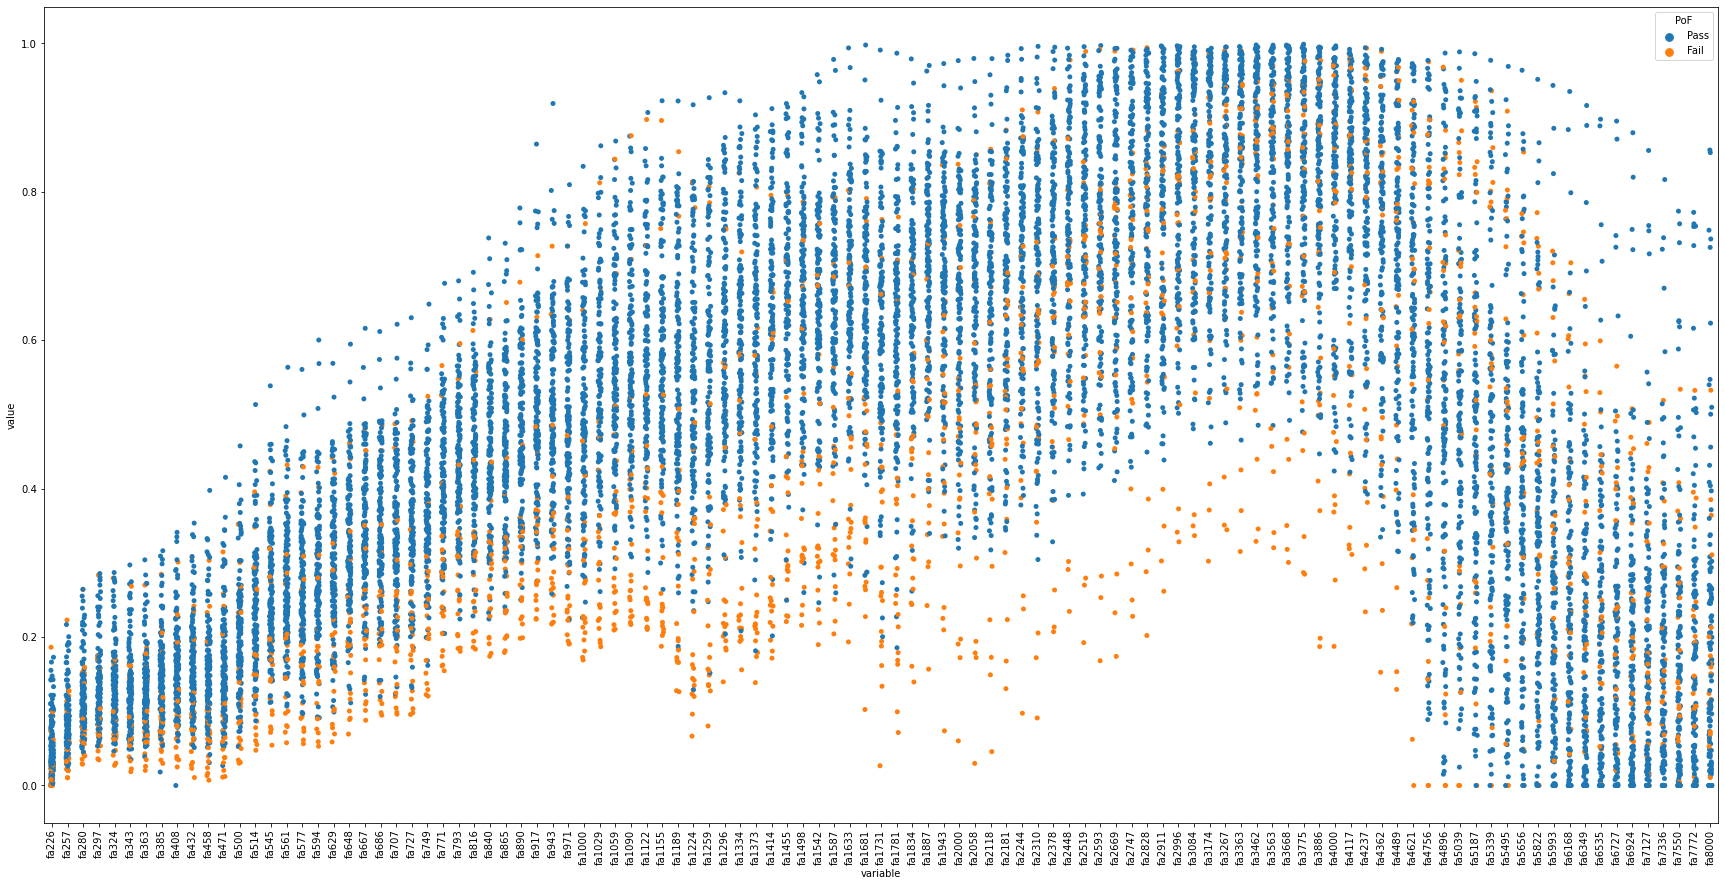

In [16]:
plt.figure(figsize=(30, 15))
plt.xticks(rotation=90)
sb.stripplot(data=plot_data,x="variable",y="value",hue="PoF")

<AxesSubplot:xlabel='variable', ylabel='value'>

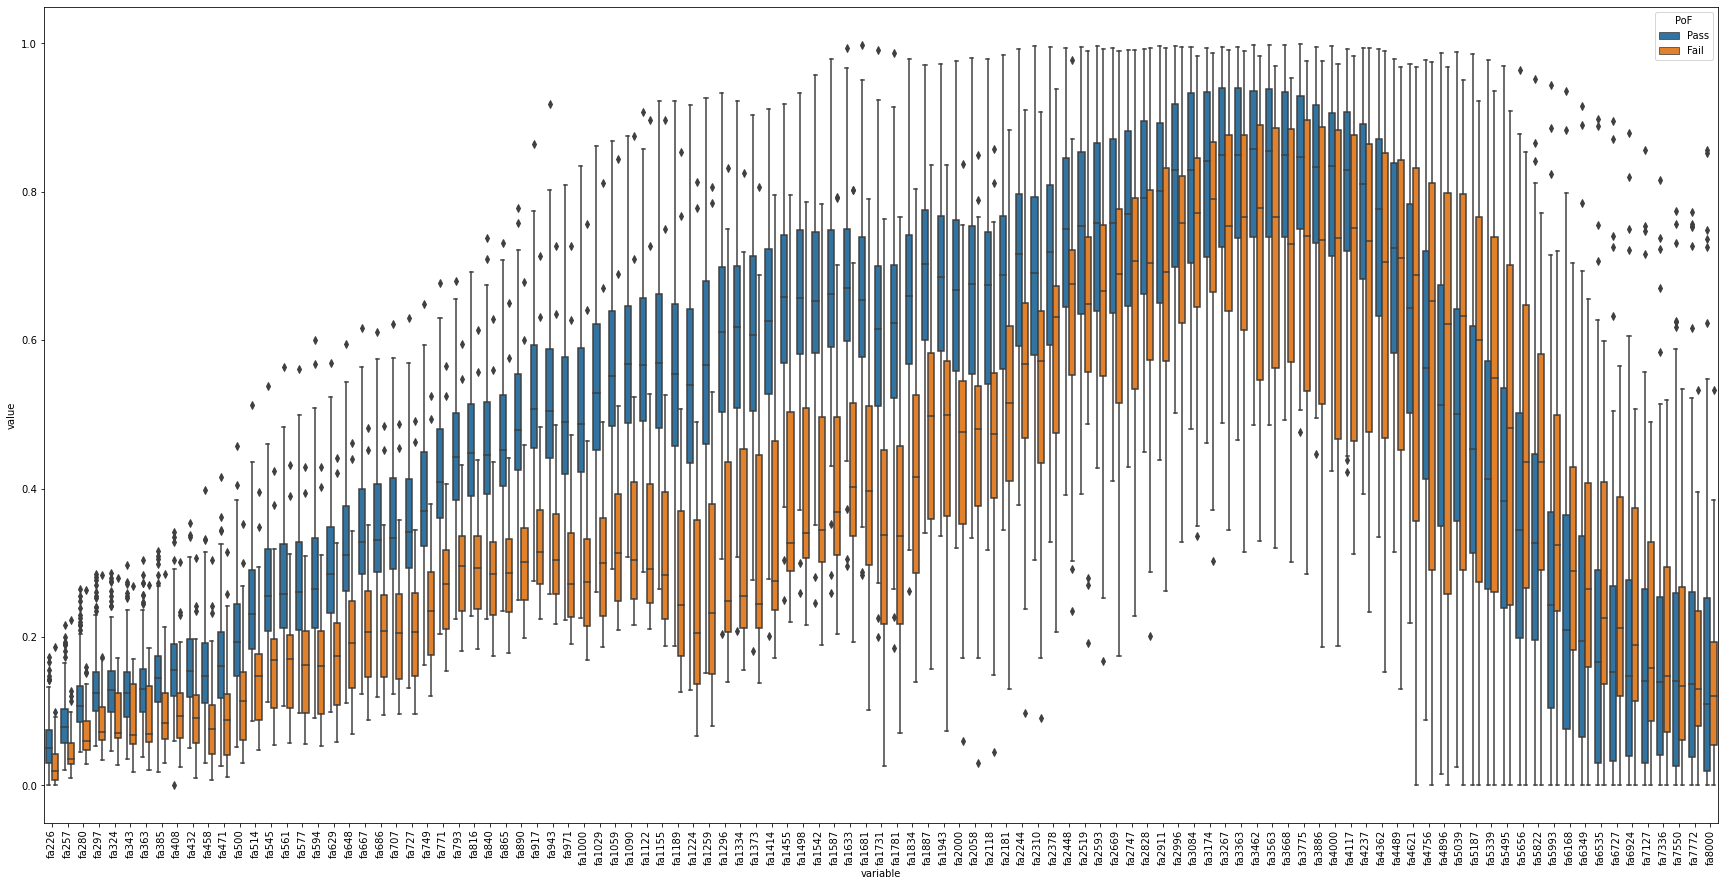

In [18]:
plt.figure(figsize=(30, 15))
plt.xticks(rotation=90)
sb.boxplot(data=plot_data,x="variable",y="value",hue="PoF")

### 01 - NearMiss Under-sampling

<AxesSubplot:xlabel='OverallPoF', ylabel='count'>

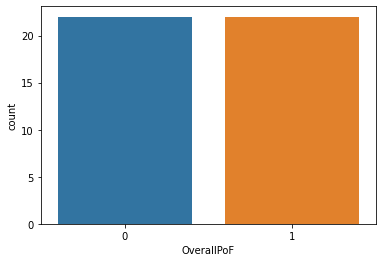

In [19]:
X_train1=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\01 - NM2\\X_train.csv")
X_val1=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\01 - NM2\\X_val.csv")
X_test1=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\01 - NM2\\X_test.csv")
y_train1=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\01 - NM2\\y_train.csv")
y_val1=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\01 - NM2\\y_val.csv")
y_test1=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\01 - NM2\\y_test.csv")
sb.countplot(y_train1['OverallPoF'],fill='OverallPoF')

In [20]:
X_train1=X_train1.filter(regex='fa',axis=1)
X_val1=X_val1.filter(regex='fa',axis=1)
X_test1=X_test1.filter(regex='fa',axis=1)

In [21]:
data=pd.concat([X_train1,y_train1],axis=1)
plot_data=pd.melt(data,'OverallPoF')
plot_data['PoF'] = np.where(plot_data['OverallPoF']==0, 'Pass', 'Fail')
plot_data.head(5)

OverallPoF variable   value   PoF
0           0    fa226  0.0367  Pass
1           0    fa226  0.0543  Pass
2           0    fa226  0.0465  Pass
3           0    fa226  0.1032  Pass
4           0    fa226  0.0802  Pass

<AxesSubplot:xlabel='variable', ylabel='value'>

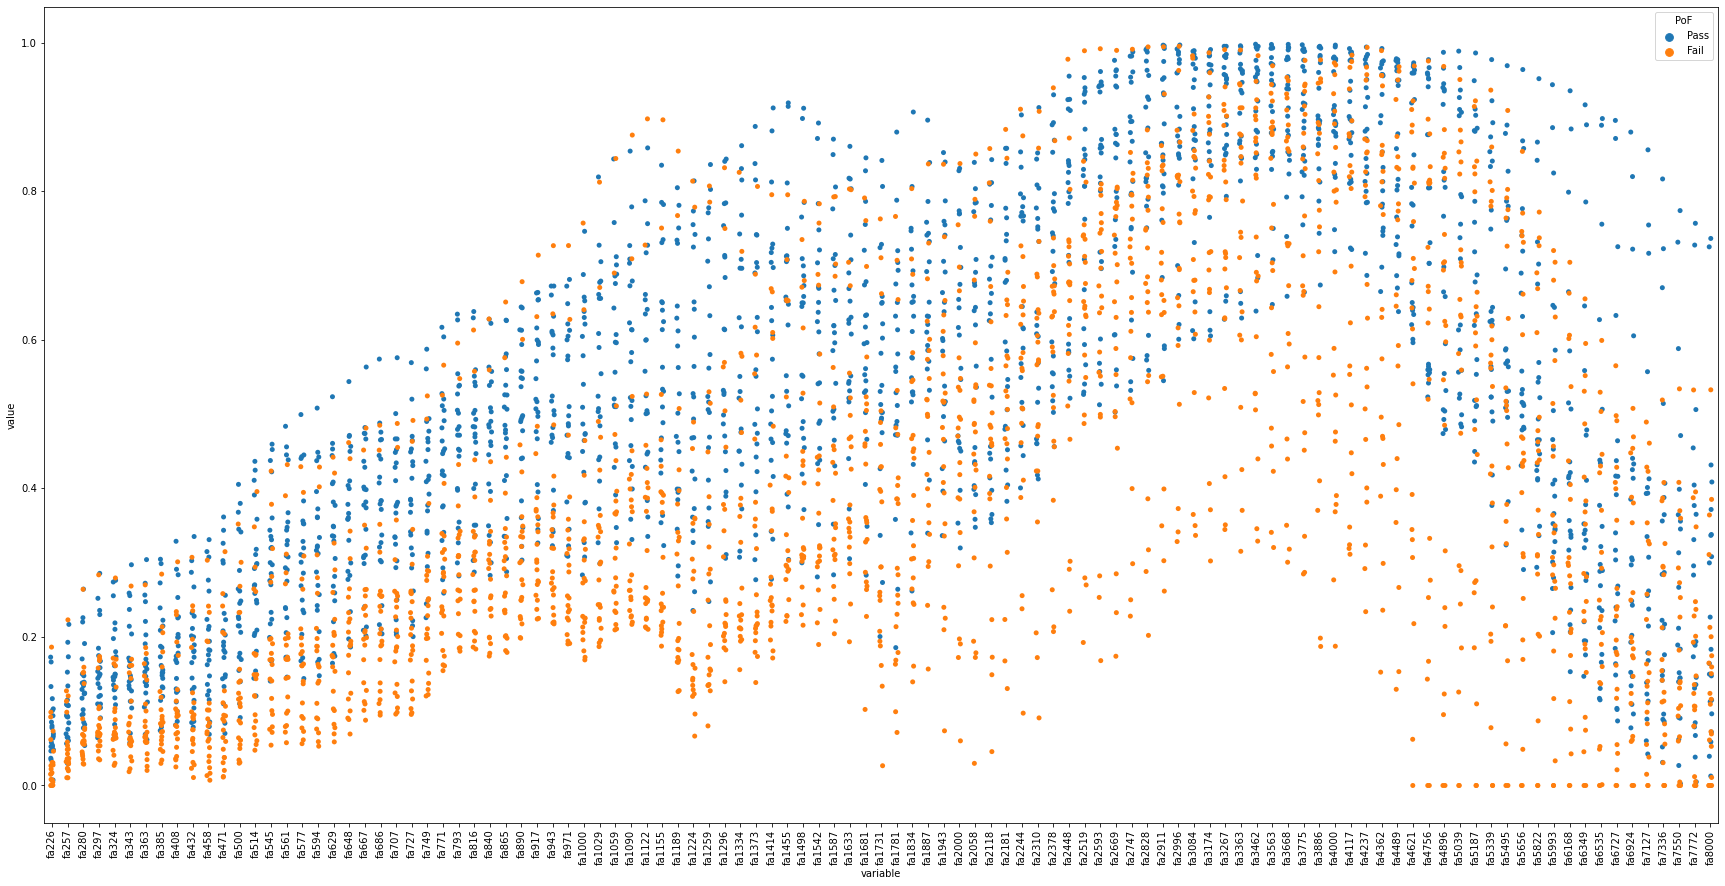

In [22]:
plt.figure(figsize=(30, 15))
plt.xticks(rotation=90)
sb.stripplot(data=plot_data,x="variable",y="value",hue="PoF")

<AxesSubplot:xlabel='variable', ylabel='value'>

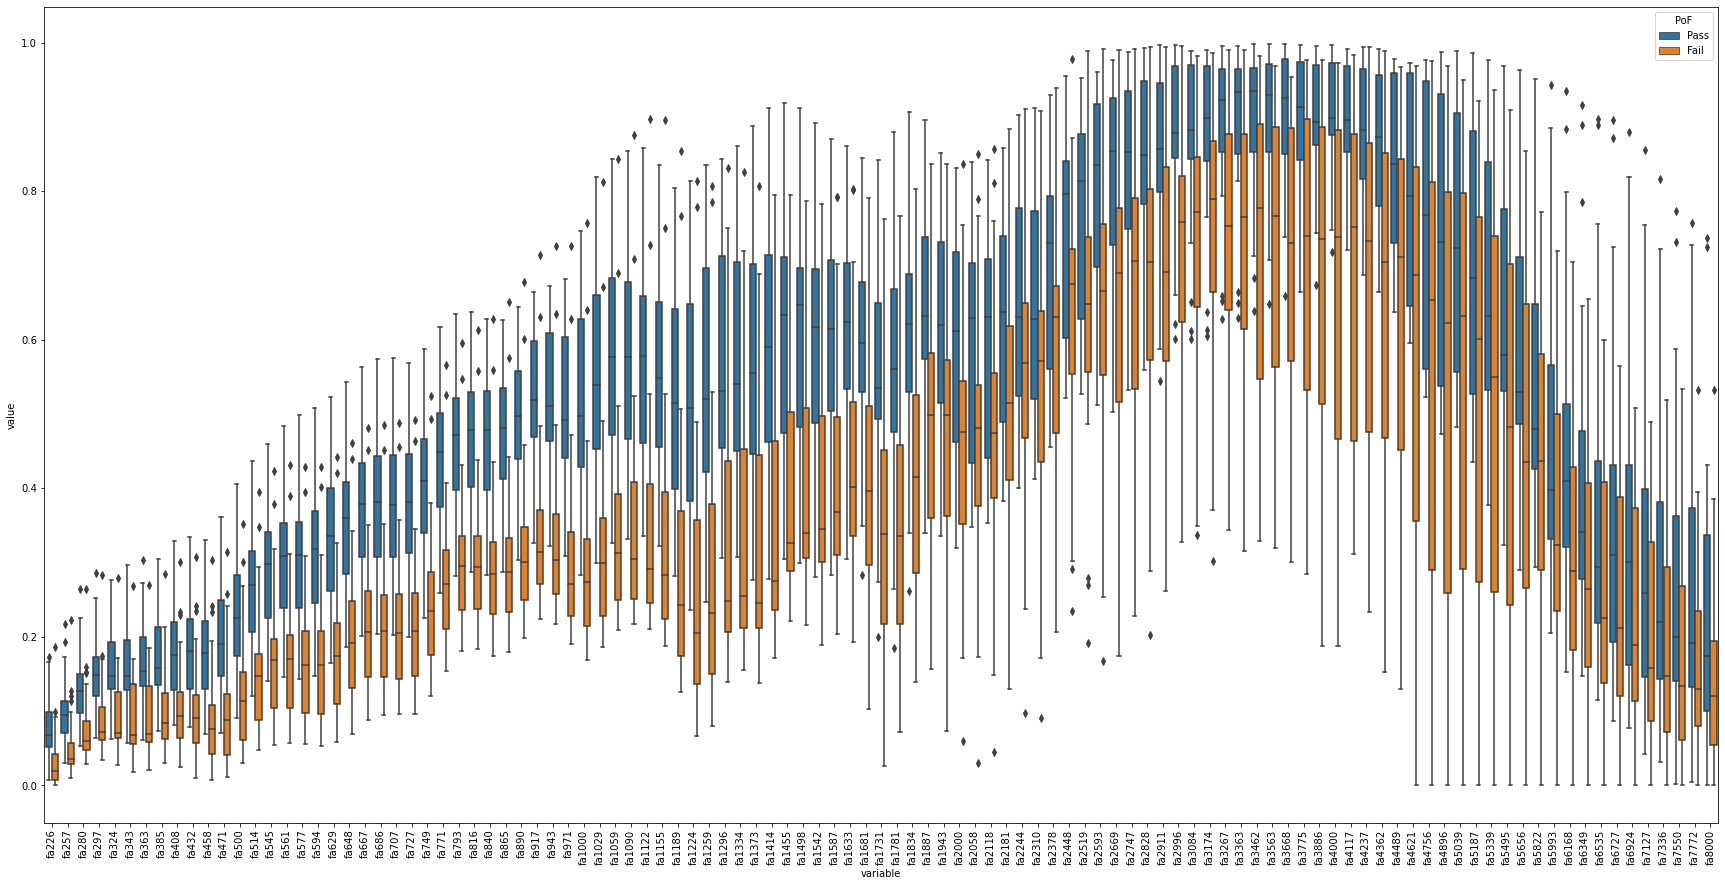

In [23]:
plt.figure(figsize=(30, 15))
plt.xticks(rotation=90)
sb.boxplot(data=plot_data,x="variable",y="value",hue="PoF")

### 02 - SMOTE Over-sampling

<AxesSubplot:xlabel='OverallPoF', ylabel='count'>

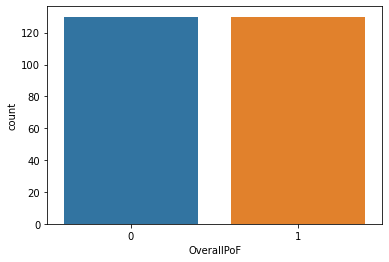

In [24]:
X_train2=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\02 - SMOTE\\X_train.csv")
X_val2=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\02 - SMOTE\\X_val.csv")
X_test2=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\02 - SMOTE\\X_test.csv")
y_train2=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\02 - SMOTE\\y_train.csv")
y_val2=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\02 - SMOTE\\y_val.csv")
y_test2=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\02 - SMOTE\\y_test.csv")
sb.countplot(y_train2['OverallPoF'],fill='OverallPoF')

In [25]:
X_train2=X_train2.filter(regex='fa',axis=1)
X_val2=X_val2.filter(regex='fa',axis=1)
X_test2=X_test2.filter(regex='fa',axis=1)

In [26]:
data=pd.concat([X_train2,y_train2],axis=1)
plot_data=pd.melt(data,'OverallPoF')
plot_data['PoF'] = np.where(plot_data['OverallPoF']==0, 'Pass', 'Fail')
plot_data.head(5)

OverallPoF variable   value   PoF
0           0    fa226  0.0620  Pass
1           0    fa226  0.0348  Pass
2           0    fa226  0.0026  Pass
3           0    fa226  0.0283  Pass
4           0    fa226  0.0359  Pass

<AxesSubplot:xlabel='variable', ylabel='value'>

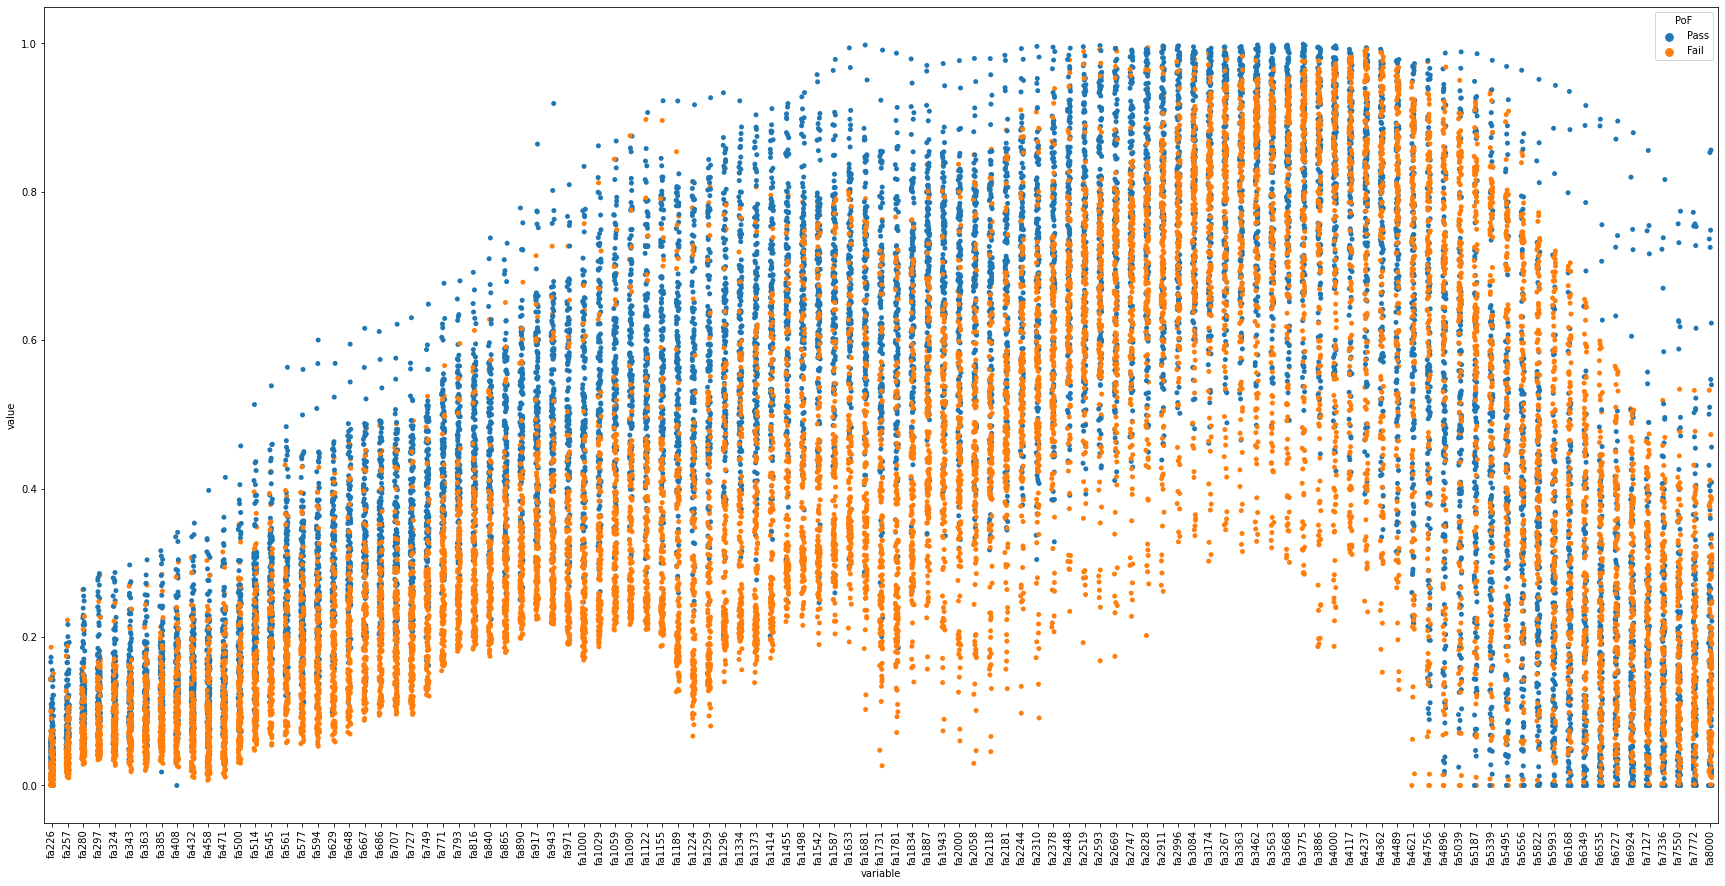

In [27]:
plt.figure(figsize=(30, 15))
plt.xticks(rotation=90)
sb.stripplot(data=plot_data,x="variable",y="value",hue="PoF")

<AxesSubplot:xlabel='variable', ylabel='value'>

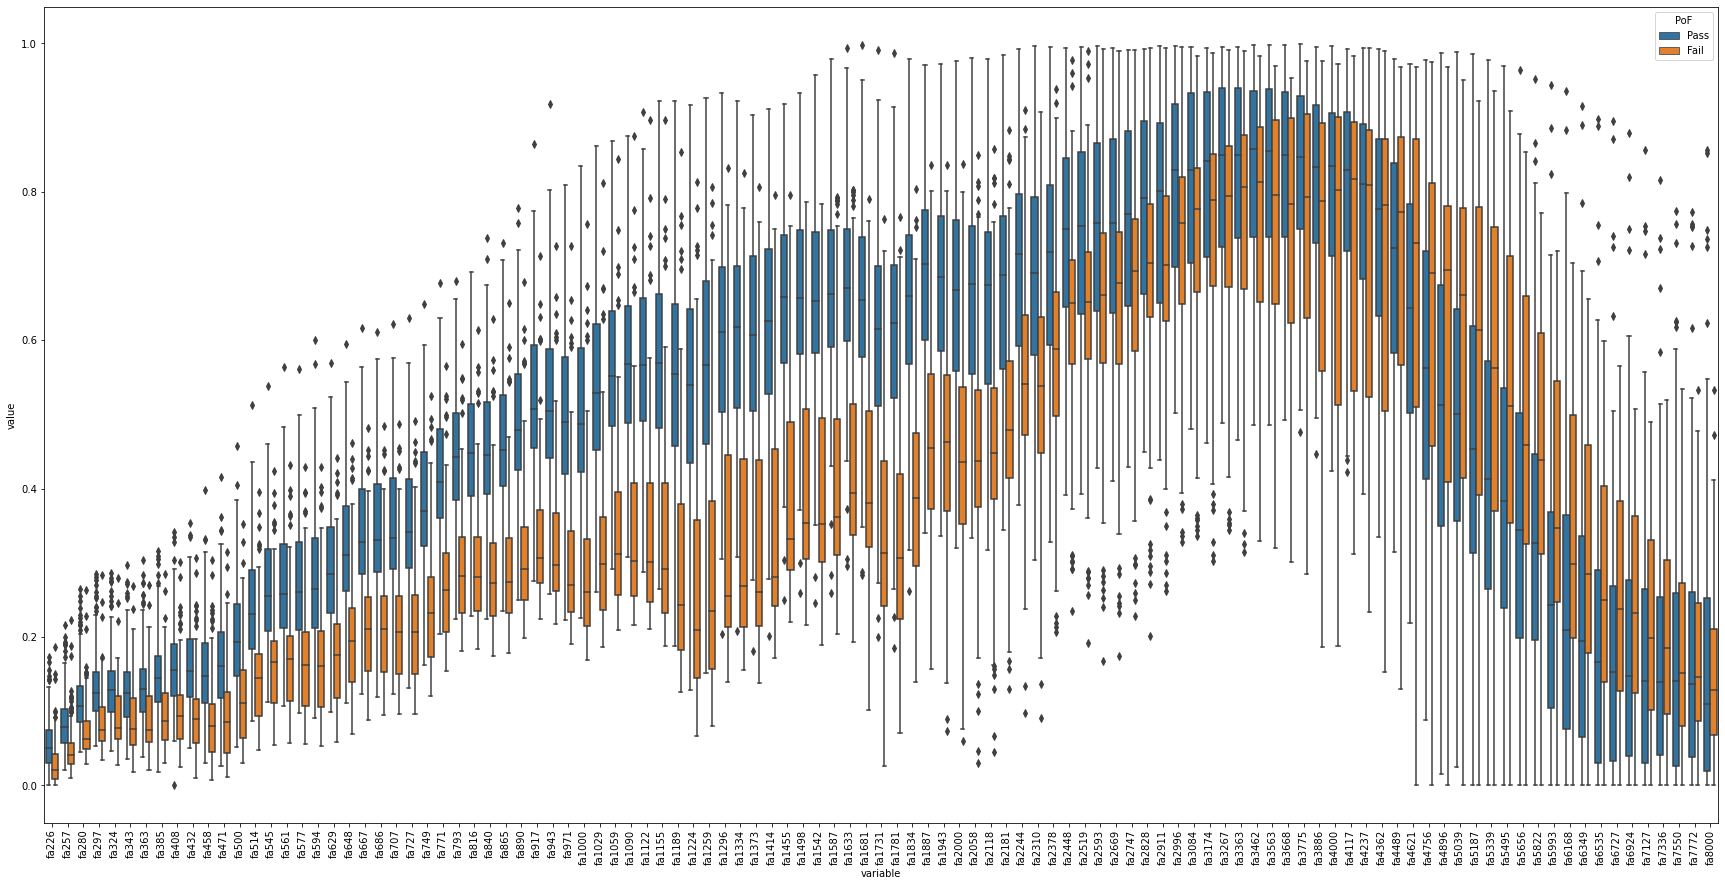

In [28]:
plt.figure(figsize=(30, 15))
plt.xticks(rotation=90)
sb.boxplot(data=plot_data,x="variable",y="value",hue="PoF")

### 03 - SMOTEENN

<AxesSubplot:xlabel='OverallPoF', ylabel='count'>

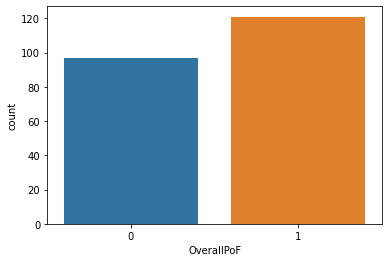

In [29]:
X_train3=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\03 - SMOTEENN\\X_train.csv")
X_val3=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\03 - SMOTEENN\\X_val.csv")
X_test3=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\03 - SMOTEENN\\X_test.csv")
y_train3=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\03 - SMOTEENN\\y_train.csv")
y_val3=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\03 - SMOTEENN\\y_val.csv")
y_test3=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\03 - SMOTEENN\\y_test.csv")
sb.countplot(y_train3['OverallPoF'],fill='OverallPoF')

In [30]:
X_train3.head()

Gender  AgeM   ECV  TPP    SC  OAE1  OAE1.4  OAE2  OAE2.8  OAE4  ...  \
0       0    97  1.01  -78  0.84  14.7    22.9  19.2     7.5  10.6  ...   
1       1   117  0.71    3  0.47  21.0    18.0  22.0    15.0  11.0  ...   
2       1   104  0.88  -11  0.46   9.5    11.3  11.1    13.5  11.1  ...   
3       0   102  0.80   -8  0.70   4.0     7.0  11.0    15.0  15.0  ...   
4       0   106  1.54  -11  0.78   3.0    22.0  20.0    17.0  20.0  ...   

     fp6168    fp6349   fp6535   fp6727   fp6924   fp7127   fp7336    fp7550  \
0  -88.8839  -88.8359 -90.6649 -90.3674 -88.3935 -91.0641 -92.7877 -114.7202   
1  -51.7346  -22.2277  50.3318  80.6503  82.6362  86.7219  87.6202   90.5000   
2  136.2679  102.0953  97.2395  94.3545  90.6787  89.1412  87.2806   86.4388   
3  -49.2873  -42.2230 -25.7535   6.9751  24.5090  46.7996  62.4586   73.2916   
4  -70.2761  -65.7322 -58.6314 -41.7434 -23.7137  10.4994  41.8514   60.6193   

     fp7772    fp8000  
0  122.4531  112.2305  
1   91.0953   93.3113  
2   84.9723   83.5814  
3   75.2660   80.3582  
4   67.1151   72.2054  

[5 rows x 332 columns]

In [31]:
X_train3=X_train3.filter(regex='fa',axis=1)
X_val3=X_val3.filter(regex='fa',axis=1)
X_test3=X_test3.filter(regex='fa',axis=1)

In [32]:
data=pd.concat([X_train3,y_train3],axis=1)
plot_data=pd.melt(data,'OverallPoF')
plot_data['PoF'] = np.where(plot_data['OverallPoF']==0, 'Pass', 'Fail')
plot_data.head(5)

OverallPoF variable   value   PoF
0           0    fa226  0.0026  Pass
1           0    fa226  0.0359  Pass
2           0    fa226  0.0345  Pass
3           0    fa226  0.0802  Pass
4           0    fa226  0.1476  Pass

<AxesSubplot:xlabel='variable', ylabel='value'>

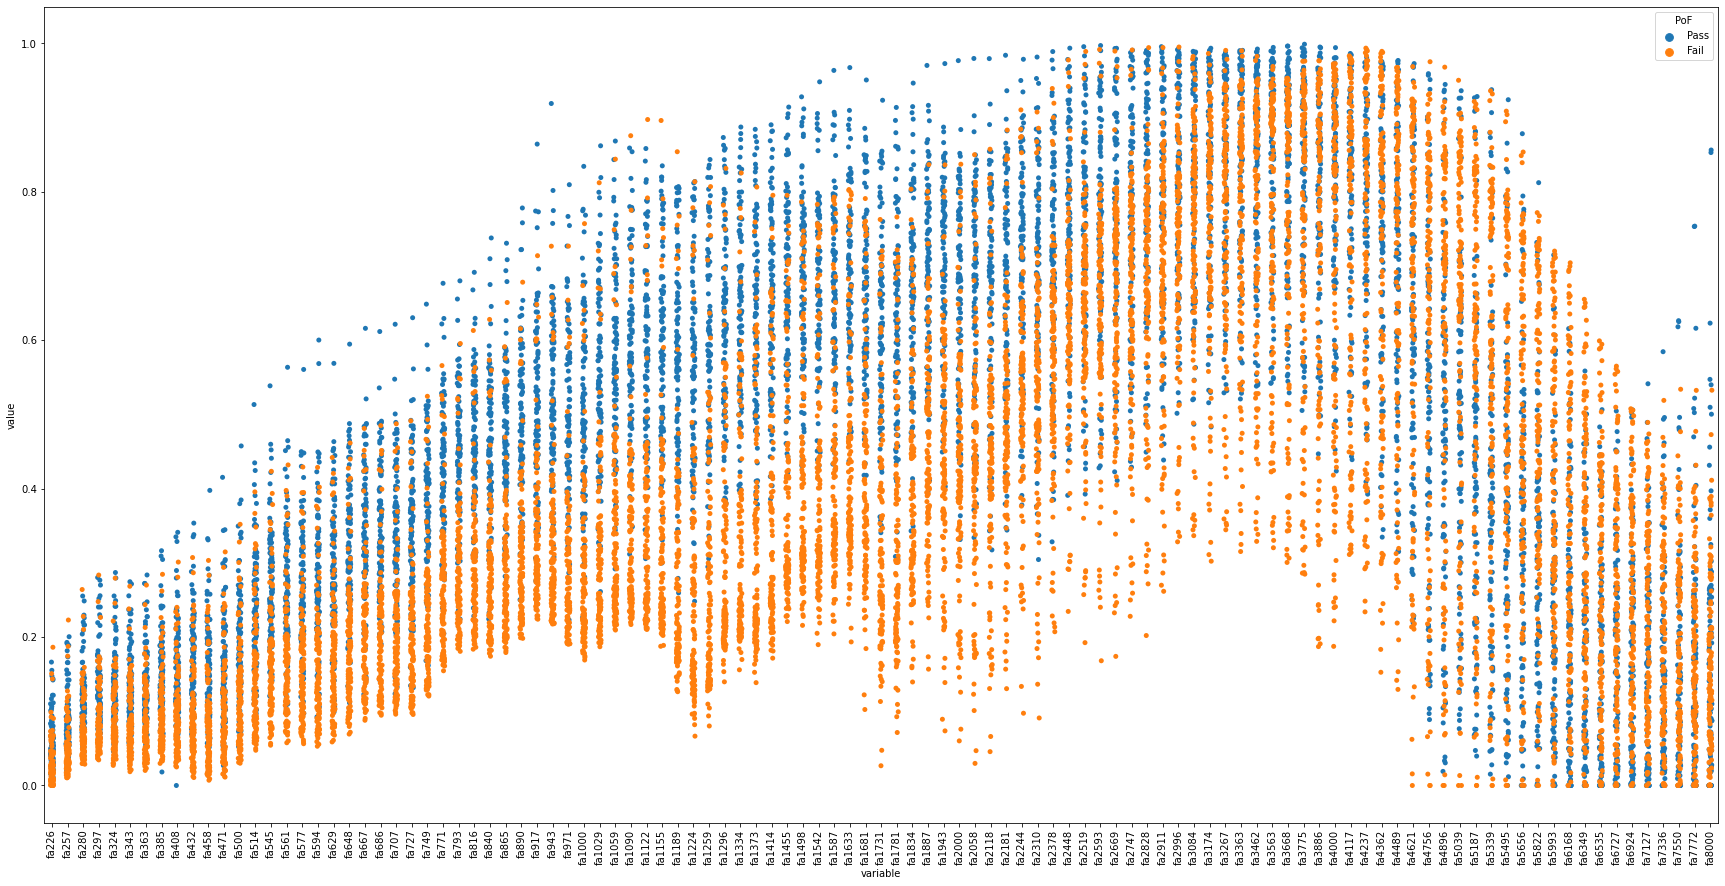

In [33]:
plt.figure(figsize=(30, 15))
plt.xticks(rotation=90)
sb.stripplot(data=plot_data,x="variable",y="value",hue="PoF")

<AxesSubplot:xlabel='variable', ylabel='value'>

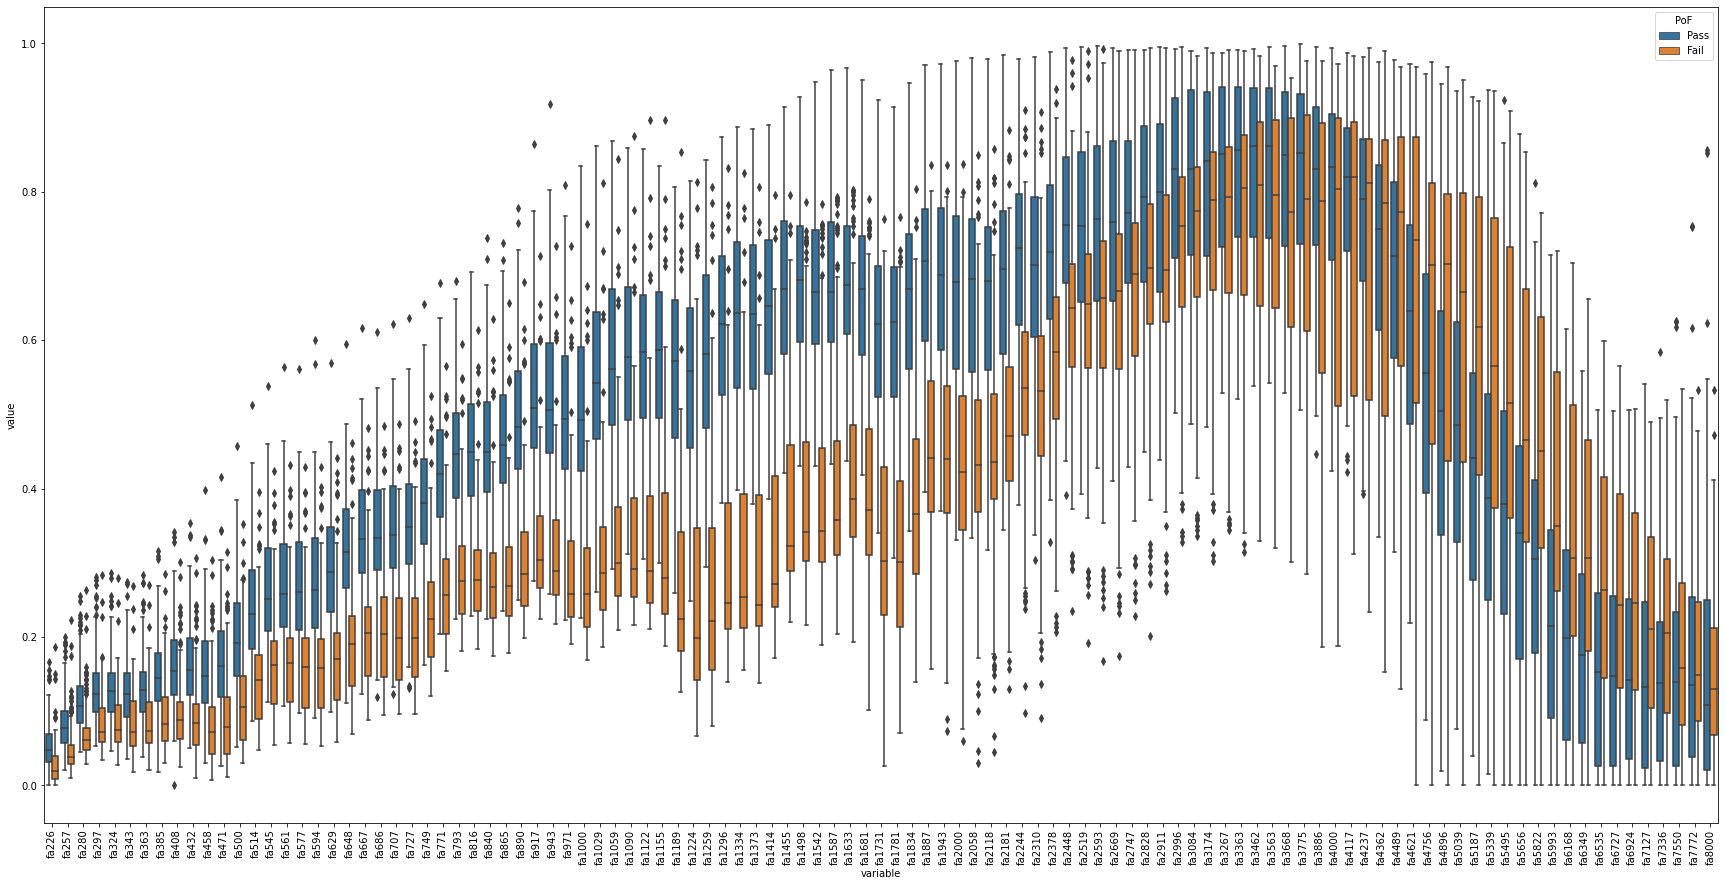

In [34]:
plt.figure(figsize=(30, 15))
plt.xticks(rotation=90)
sb.boxplot(data=plot_data,x="variable",y="value",hue="PoF")

### 04 - SMOTETomek

<AxesSubplot:xlabel='OverallPoF', ylabel='count'>

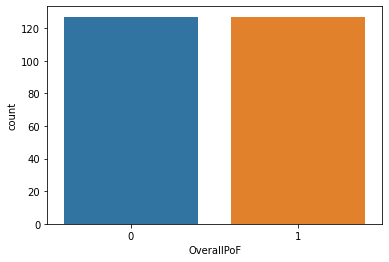

In [35]:
X_train4=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\04 - SMOTETomek\\X_train.csv")
X_val4=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\04 - SMOTETomek\\X_val.csv")
X_test4=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\04 - SMOTETomek\\X_test.csv")
y_train4=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\04 - SMOTETomek\\y_train.csv")
y_val4=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\04 - SMOTETomek\\y_val.csv")
y_test4=pd.read_csv("C:\\Users\\AndyJ\\12-Ears\\P1\\03 - Code\\00 - Dataset\\03 - Sampling Splits\\04 - SMOTETomek\\y_test.csv")
sb.countplot(y_train4['OverallPoF'],fill='OverallPoF')

In [36]:
X_train4=X_train4.filter(regex='fa',axis=1)
X_val4=X_val4.filter(regex='fa',axis=1)
X_test4=X_test4.filter(regex='fa',axis=1)

In [37]:
data=pd.concat([X_train4,y_train4],axis=1)
plot_data=pd.melt(data,'OverallPoF')
plot_data['PoF'] = np.where(plot_data['OverallPoF']==0, 'Pass', 'Fail')
plot_data.head(5)

OverallPoF variable   value   PoF
0           0    fa226  0.0348  Pass
1           0    fa226  0.0026  Pass
2           0    fa226  0.0283  Pass
3           0    fa226  0.0359  Pass
4           0    fa226  0.0434  Pass

<AxesSubplot:xlabel='variable', ylabel='value'>

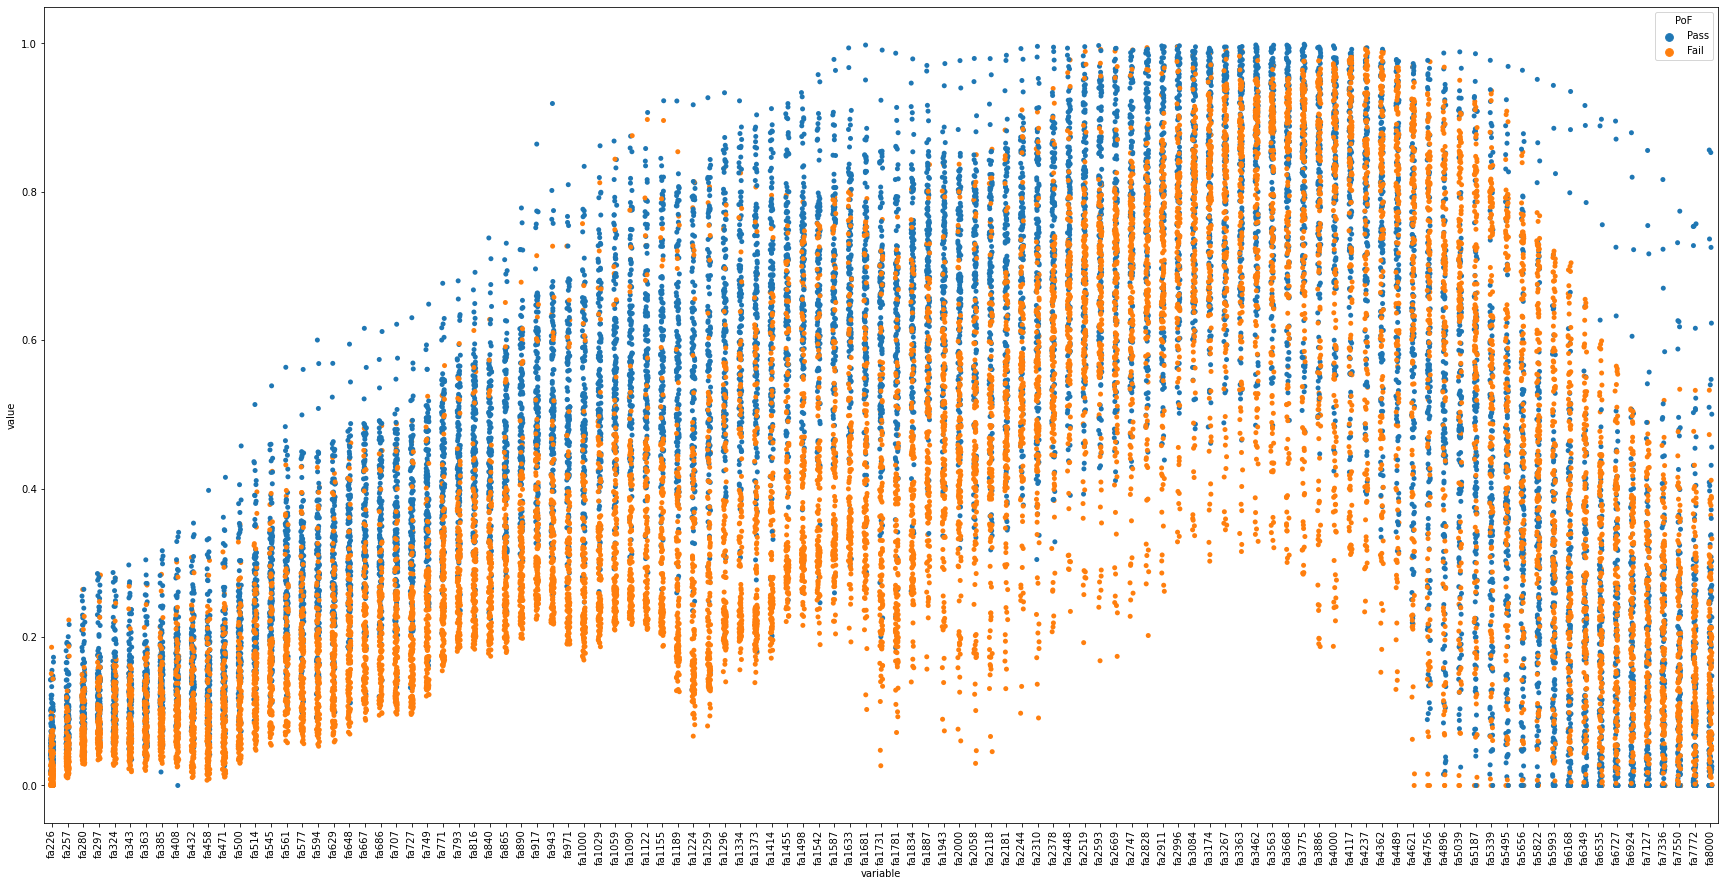

In [38]:
plt.figure(figsize=(30, 15))
plt.xticks(rotation=90)
sb.stripplot(data=plot_data,x="variable",y="value",hue="PoF")

<AxesSubplot:xlabel='variable', ylabel='value'>

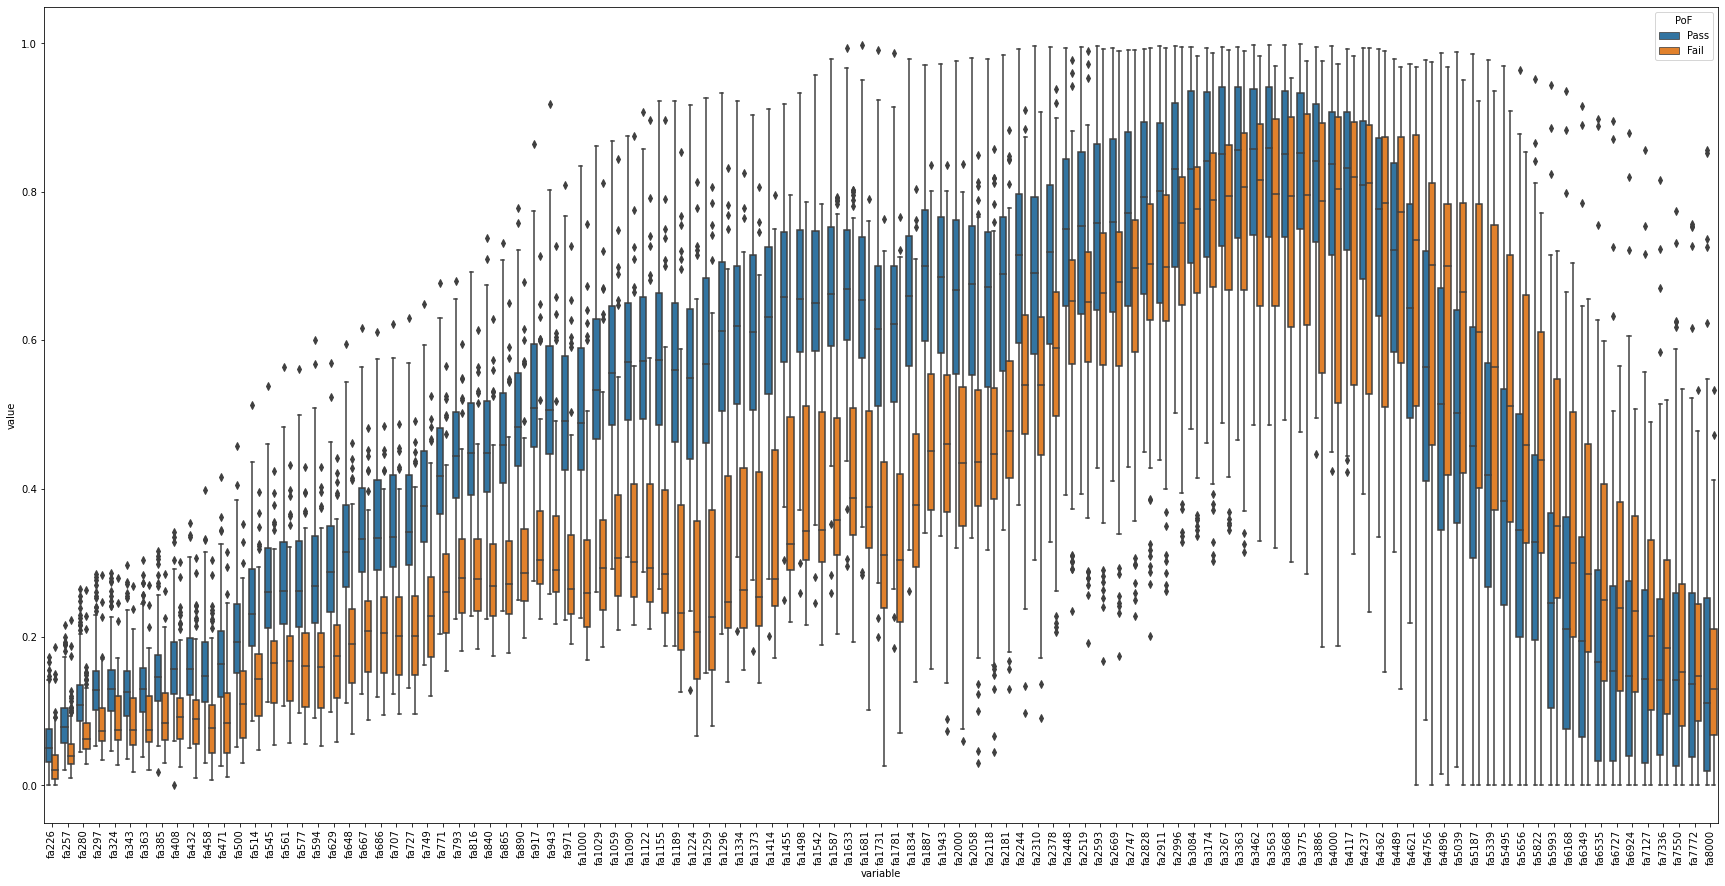

In [39]:
plt.figure(figsize=(30, 15))
plt.xticks(rotation=90)
sb.boxplot(data=plot_data,x="variable",y="value",hue="PoF")

### 05 - Distribution of Pass and Fails

In [40]:
data=pd.concat([X_train0,y_train0],axis=1)
plot_data=pd.melt(data,'OverallPoF')
plot_data['PoF'] = np.where(plot_data['OverallPoF']==0, 'Pass', 'Fail')
plot_data['PoF'] = np.where(plot_data['OverallPoF']==0, 'Pass', 'Fail')
plot_data.head(5)

OverallPoF variable   value   PoF
0           0    fa226  0.0620  Pass
1           0    fa226  0.0348  Pass
2           0    fa226  0.0026  Pass
3           0    fa226  0.0283  Pass
4           0    fa226  0.0359  Pass

In [41]:
# getting necessary libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

test3=plot_data.iloc[5624:6688,]
freq_test2=X_train0.columns[30:50]
freq_test2


# getting the data
lst2 =freq_test2
freq_list2=dict(zip(range(len(lst2)),lst2))

In [42]:
test3[test3['variable']=='fa1296']

OverallPoF variable   value   PoF
6536           0   fa1296  0.4033  Pass
6537           0   fa1296  0.6145  Pass
6538           0   fa1296  0.5239  Pass
6539           0   fa1296  0.5241  Pass
6540           0   fa1296  0.6537  Pass
...          ...      ...     ...   ...
6683           1   fa1296  0.3783  Fail
6684           1   fa1296  0.4555  Fail
6685           0   fa1296  0.8434  Pass
6686           0   fa1296  0.6367  Pass
6687           0   fa1296  0.4988  Pass

[152 rows x 4 columns]

In [43]:
test3[test3['variable']=='fa749']

Empty DataFrame
Columns: [OverallPoF, variable, value, PoF]
Index: []

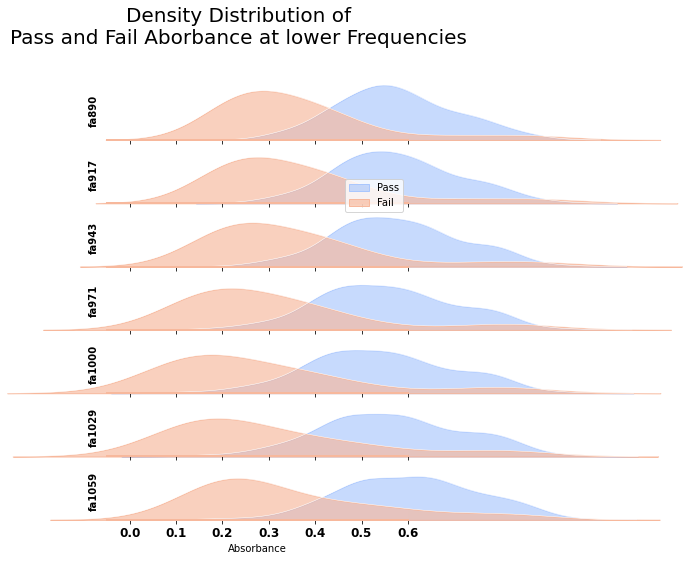

In [44]:
# we generate a color palette with Seaborn.color_palette()
pal = sb.color_palette(palette='coolwarm', n_colors=2)

# in the sb.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sb.FacetGrid(test3, row='variable', hue='PoF', aspect=5, height=1, palette=pal)

# then we add the densities kdeplots for each month
g.map(sb.kdeplot, 'value',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=0.65, linewidth=1)

# here we add a white line that represents the contour of each kdeplot
g.map(sb.kdeplot, 'value', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=0.5)

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(freq_list2[i],fontweight='bold', fontsize=10)

# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=0.1)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[])
g.set(xlabel="Absorbance")
g.set(xlim=[-0.05,0.6])
g.despine(bottom=True, left=True)


plt.setp(ax.get_xticklabels(), fontsize=12, fontweight='bold')
plt.legend(['Pass','Fail'],loc='best', bbox_to_anchor=(0.5, 3, 0.5,3),labelcolor="black")
g.fig.suptitle('Density Distribution of\nPass and Fail Aborbance at lower Frequencies',y=1.1,
               ha='center',
               fontsize=20,
               fontweight=20)

plt.show()

In [45]:
# getting necessary libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

test3=plot_data.iloc[5624:6384,]
freq_test2=X_train0.columns[37:42]
freq_test2


# getting the data
lst2 =freq_test2
freq_list2=dict(zip(range(len(lst2)),lst2))

In [46]:
freq_list2

{0: 'fa1090', 1: 'fa1122', 2: 'fa1155', 3: 'fa1189', 4: 'fa1224'}

In [47]:
test3[test3['variable']=='fa1224']

OverallPoF variable   value   PoF
6232           0   fa1224  0.2841  Pass
6233           0   fa1224  0.5276  Pass
6234           0   fa1224  0.4416  Pass
6235           0   fa1224  0.4709  Pass
6236           0   fa1224  0.5932  Pass
...          ...      ...     ...   ...
6379           1   fa1224  0.3529  Fail
6380           1   fa1224  0.3599  Fail
6381           0   fa1224  0.8140  Pass
6382           0   fa1224  0.5496  Pass
6383           0   fa1224  0.4684  Pass

[152 rows x 4 columns]

In [48]:
test3[test3['variable']=='fa749']

Empty DataFrame
Columns: [OverallPoF, variable, value, PoF]
Index: []

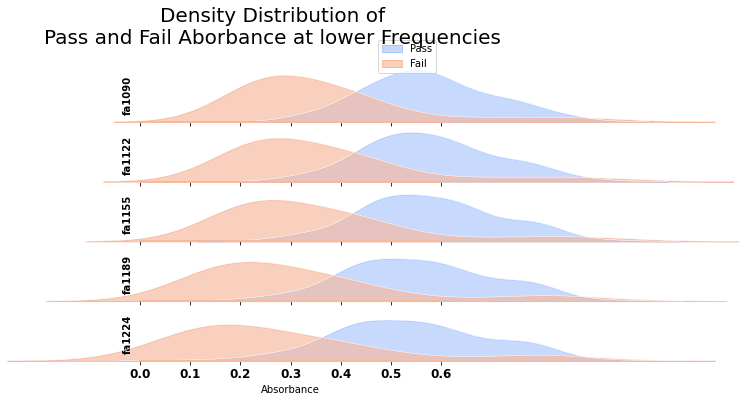

In [49]:
# we generate a color palette with Seaborn.color_palette()
pal = sb.color_palette(palette='coolwarm', n_colors=2)

# in the sb.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sb.FacetGrid(test3, row='variable', hue='PoF', aspect=5, height=1, palette=pal)

# then we add the densities kdeplots for each month
g.map(sb.kdeplot, 'value',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=0.65, linewidth=1)

# here we add a white line that represents the contour of each kdeplot
g.map(sb.kdeplot, 'value', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=0.5)

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(freq_list2[i],fontweight='bold', fontsize=10)

# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=0.1)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[])
g.set(xlabel="Absorbance")
g.set(xlim=[0,0.6])
g.despine(bottom=True, left=True)


plt.setp(ax.get_xticklabels(), fontsize=12, fontweight='bold')
plt.legend(['Pass','Fail'],loc='best', bbox_to_anchor=(0.5, 3, 0.5,3),labelcolor="black")
g.fig.suptitle('Density Distribution of\nPass and Fail Aborbance at lower Frequencies',y=1.1,
               ha='center',
               fontsize=20,
               fontweight=20)

plt.show()

## 4.0 - Feature Selection

### 01 - Filter Methods

#### 01 - SelectKBest - ANOVA ONE-WAY F-TEST

#### Visualised

In [50]:
from scipy.stats import f_oneway

data=pd.concat([X_train2,y_train2],axis=1)
plot_data=pd.melt(data,'OverallPoF')
plot_data['PoF'] = np.where(plot_data['OverallPoF']==0, 'Pass', 'Fail')


In [51]:
passes=plot_data.loc[(plot_data['variable']=='fa226') & (plot_data['PoF']=='Pass')].value

In [52]:
fails=plot_data.loc[(plot_data['variable']=='fa226') & (plot_data['PoF']=='Fail')].value

In [53]:
f_stat=[]
p_val=[]
for i in X_train2.columns.values:
    passes=plot_data.loc[(plot_data['variable']==i) & (plot_data['PoF']=='Pass')].value
    fails=plot_data.loc[(plot_data['variable']==i) & (plot_data['PoF']=='Fail')].value
    f_stat.append(f_oneway(passes,fails)[0])
    p_val.append(f_oneway(passes,fails)[1])

In [54]:
freq=X_train2.columns.values
f_scores=pd.DataFrame({'freq':freq,'f_stat':f_stat,'p_val':p_val})
f_scores.head()

freq     f_stat         p_val
0  fa226  43.913785  1.991023e-10
1  fa257  60.196836  2.002439e-13
2  fa280  63.983195  4.251649e-14
3  fa297  64.469037  3.489942e-14
4  fa324  57.838041  5.311370e-13

In [55]:
f_scores.sort_values('f_stat',ascending=False).head(10)

freq      f_stat         p_val
37  fa1090  228.635369  2.030220e-37
44  fa1334  224.603490  5.965834e-37
43  fa1296  224.066841  6.890919e-37
38  fa1122  222.026341  1.193900e-36
36  fa1059  218.087623  3.472291e-36
39  fa1155  217.843730  3.710679e-36
45  fa1373  216.972585  4.705188e-36
40  fa1189  216.726238  5.032381e-36
41  fa1224  213.911420  1.087602e-35
46  fa1414  213.131679  1.347540e-35

<AxesSubplot:xlabel='freq', ylabel='f_stat'>

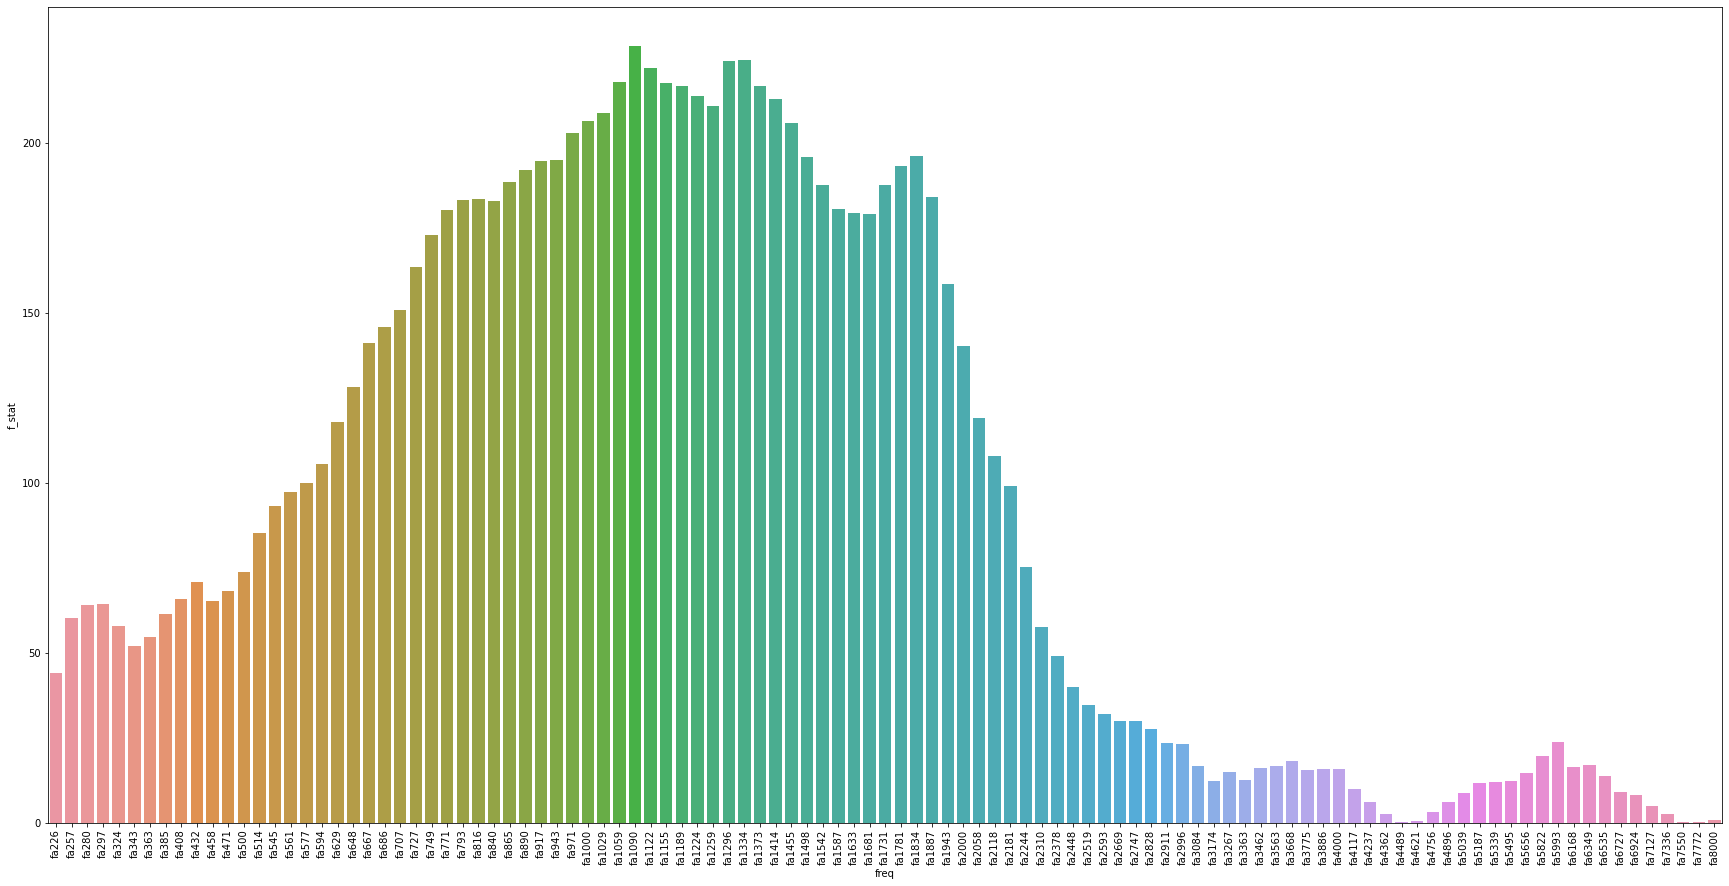

In [56]:
plt.figure(figsize=(30, 15))
plt.xticks(rotation=90)
sb.barplot(data=f_scores,x='freq',y='f_stat')

##### 00 - Original Results

In [279]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
start = timeit.default_timer()
X=X_train0
y=y_train0
start = timeit.default_timer()
X_new0 = SelectKBest(f_classif, k=15).fit(X, y)
stop = timeit.default_timer()

mask0=X_new0.get_support()
anov_feat_0 = [] 
for bool, feature in zip(mask0, X_train0.columns):
    if bool:
        anov_feat_0.append(feature)
print("The best features are:{}".format(anov_feat_0))



anova_time_0=stop-start
print('Time: ',anova_time_0)

The best features are:['fa1224', 'fa1259', 'fa1296', 'fa1334', 'fa1373', 'fa1414', 'fa1455', 'fa1498', 'fa1542', 'fa1587', 'fa1633', 'fa1681', 'fa1731', 'fa1781', 'fa1834']
Time:  0.005041300006269012


##### 01 - Nearmiss Results

In [280]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
start = timeit.default_timer()

X=X_train1
y=y_train1
start = timeit.default_timer()
X_new1 = SelectKBest(f_classif, k=15).fit(X, y)
mask1=X_new1.get_support()
anov_feat_1 = [] 
for bool, feature in zip(mask1, X_train1.columns):
    if bool:
        anov_feat_1.append(feature)
print("The best features are:{}".format(anov_feat_1))

stop = timeit.default_timer()

anova_time_1=stop-start
print('Time: ',anova_time_1)

The best features are:['fa686', 'fa707', 'fa727', 'fa749', 'fa771', 'fa793', 'fa816', 'fa840', 'fa865', 'fa890', 'fa917', 'fa943', 'fa971', 'fa1000', 'fa1029']
Time:  0.008508799997798633


##### 02 - SMOTE Results

In [281]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
start = timeit.default_timer()

X=X_train2
y=y_train2
start = timeit.default_timer()
X_new2 = SelectKBest(f_classif, k=15).fit(X, y)
mask2=X_new2.get_support()
anov_feat_2 = [] 
for bool, feature in zip(mask2, X_train2.columns):
    if bool:
        anov_feat_2.append(feature)
print("The best features are:{}".format(anov_feat_2))

stop = timeit.default_timer()

anova_time_2=stop-start
print('Time: ',anova_time_2)

The best features are:['fa971', 'fa1000', 'fa1029', 'fa1059', 'fa1090', 'fa1122', 'fa1155', 'fa1189', 'fa1224', 'fa1259', 'fa1296', 'fa1334', 'fa1373', 'fa1414', 'fa1455']
Time:  0.008035800005018245


##### 03 - SMOTEENN Results

In [282]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
start = timeit.default_timer()

X=X_train3
y=y_train3
start = timeit.default_timer()
X_new3 = SelectKBest(f_classif, k=15).fit(X, y)
mask3=X_new3.get_support()
anov_feat_3 = [] 
for bool, feature in zip(mask3, X_train3.columns):
    if bool:
        anov_feat_3.append(feature)
print("The best features are:{}".format(anov_feat_3))

stop = timeit.default_timer()

anova_time_3=stop-start
print('Time: ',anova_time_3)

The best features are:['fa1000', 'fa1029', 'fa1059', 'fa1090', 'fa1122', 'fa1155', 'fa1189', 'fa1224', 'fa1259', 'fa1296', 'fa1334', 'fa1373', 'fa1414', 'fa1455', 'fa1498']
Time:  0.010186600004089996


##### 04 - SMOTETomek Results

In [283]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
start = timeit.default_timer()

X=X_train4
y=y_train4
start = timeit.default_timer()
X_new4 = SelectKBest(f_classif, k=15).fit(X, y)
mask4=X_new4.get_support()
anov_feat_4 = [] 
for bool, feature in zip(mask4, X_train4.columns):
    if bool:
        anov_feat_4.append(feature)
print("The best features are:{}".format(anov_feat_4))

stop = timeit.default_timer()

anova_time_4=stop-start
print('Time: ',anova_time_4)

The best features are:['fa917', 'fa971', 'fa1000', 'fa1029', 'fa1059', 'fa1090', 'fa1122', 'fa1155', 'fa1189', 'fa1224', 'fa1259', 'fa1296', 'fa1334', 'fa1373', 'fa1414']
Time:  0.006214299995917827


##### 05 - Percentile of features selected SMOTETomek

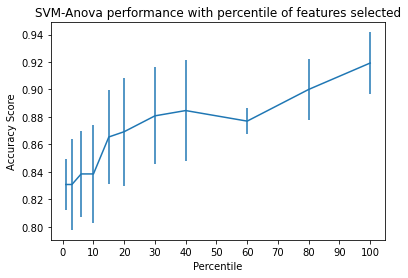

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have a full-blown estimator

clf = Pipeline(
    [
        ("anova", SelectPercentile(chi2)),
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel='linear')),
    ]
)


score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X_train2, y_train2)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("SVM-Anova performance with percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy Score")
plt.show()

### 02 - Wrapper Methods

#### 01 - Recursive Feature Elimination (RFE)

##### 00 - Original Results

In [108]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

start = timeit.default_timer()

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv_0 = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(10),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv_0.fit(X_train0, y_train0)

print("Optimal number of features : %d" % rfecv_0.n_features_)

ranking = pd.DataFrame(rfecv_0.ranking_, columns = ['Ranking'])
features=pd.DataFrame(X_train0.columns.values[rfecv_0.ranking_],columns=['Features'])
# feature_rank=pd.concat([ranking,features],axis=1)
rfe_svc_0=X_train0.columns[rfecv_0.support_]
rfe_svc_0_total=X_train0.columns[rfecv_0.support_].size

stop = timeit.default_timer()

rfe_svc_time_0=stop-start
print('Time: ',rfe_svc_time_0)

Optimal number of features : 7
Time:  2.134442399998079


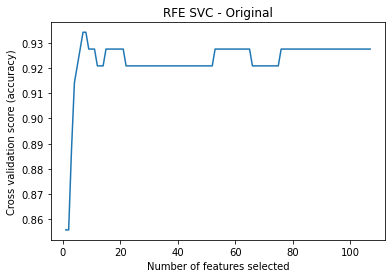

Best features: Index(['fa749', 'fa771', 'fa1090', 'fa1296', 'fa1334', 'fa1834', 'fa4000'], dtype='object')


In [109]:
rfeSVC_feat_0=X_train0.columns[rfecv_0.support_]
# Plot number of features VS. cross-validation scores
plt.figure()
plt.title("RFE SVC - Original")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv_0.grid_scores_) + min_features_to_select),
    rfecv_0.cv_results_['mean_test_score'],
)
plt.show()
print("Best features:", X_train0.columns[rfecv_0.support_])

##### 01 - Nearmiss Results

In [111]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

start = timeit.default_timer()
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv_1 = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(10),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv_1.fit(X_train1, y_train1)

ranking = pd.DataFrame(rfecv_1.ranking_, columns = ['Ranking'])
features=pd.DataFrame(X_train1.columns.values[rfecv_1.ranking_],columns=['Features'])
# feature_rank=pd.concat([ranking,features],axis=1)
rfe_svc_1=X_train1.columns[rfecv_1.support_]
rfe_svc_1_total=X_train1.columns[rfecv_1.support_].size

stop = timeit.default_timer()

rfe_svc_time_1=stop-start
print('Time: ',rfe_svc_time_1)

Time:  1.2444876000008662


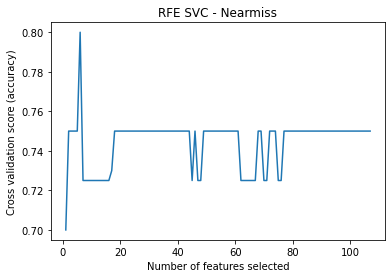

Optimal number of features : 6
Best features: Index(['fa1000', 'fa1090', 'fa1122', 'fa2747', 'fa4000', 'fa4117'], dtype='object')


In [114]:
rfeSVC_feat_1=X_train1.columns[rfecv_1.support_]
# Plot number of features VS. cross-validation scores

plt.figure()
plt.title("RFE SVC - Nearmiss")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv_1.grid_scores_) + min_features_to_select),
    rfecv_1.cv_results_['mean_test_score'],
)
plt.show()
print("Optimal number of features : %d" % rfecv_1.n_features_)
print("Best features:", X_train1.columns[rfecv_1.support_])

##### 02 - SMOTE Results

In [115]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

start = timeit.default_timer()

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv_2 = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(10),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv_2.fit(X_train2, y_train2)

ranking = pd.DataFrame(rfecv_2.ranking_, columns = ['Ranking'])
features=pd.DataFrame(X_train2.columns.values[rfecv_2.ranking_],columns=['Features'])
# feature_rank=pd.concat([ranking,features],axis=1)
rfe_svc_2=X_train2.columns[rfecv_2.support_]
rfe_svc_2_total=X_train2.columns[rfecv_2.support_].size

stop = timeit.default_timer()

rfe_svc_time_2=stop-start

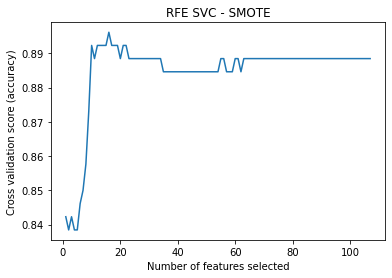

Time:  3.468802700001106
Optimal number of features : 16
Best features: Index(['fa1029', 'fa1059', 'fa1090', 'fa1296', 'fa1781', 'fa1834', 'fa1887',
       'fa2118', 'fa2181', 'fa2911', 'fa3084', 'fa3174', 'fa3363', 'fa4000',
       'fa4117', 'fa5039'],
      dtype='object')


In [116]:
rfeSVC_feat_2=X_train2.columns[rfecv_2.support_]

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title("RFE SVC - SMOTE")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv_2.grid_scores_) + min_features_to_select),
    rfecv_2.cv_results_['mean_test_score'],
)
plt.show()
print('Time: ',rfe_svc_time_2)
print("Optimal number of features : %d" % rfecv_2.n_features_)
print("Best features:", X_train2.columns[rfecv_2.support_])

##### 03 - SMOTEENN Results

In [117]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

start = timeit.default_timer()

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv_3 = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(10),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv_3.fit(X_train3, y_train3)

ranking = pd.DataFrame(rfecv_3.ranking_, columns = ['Ranking'])
features=pd.DataFrame(X_train3.columns.values[rfecv_3.ranking_],columns=['Features'])
# feature_rank=pd.concat([ranking,features],axis=1)
rfe_svc_3=X_train3.columns[rfecv_3.support_]
rfe_svc_3_total=X_train3.columns[rfecv_3.support_].size

stop = timeit.default_timer()

rfe_svc_time_3=stop-start

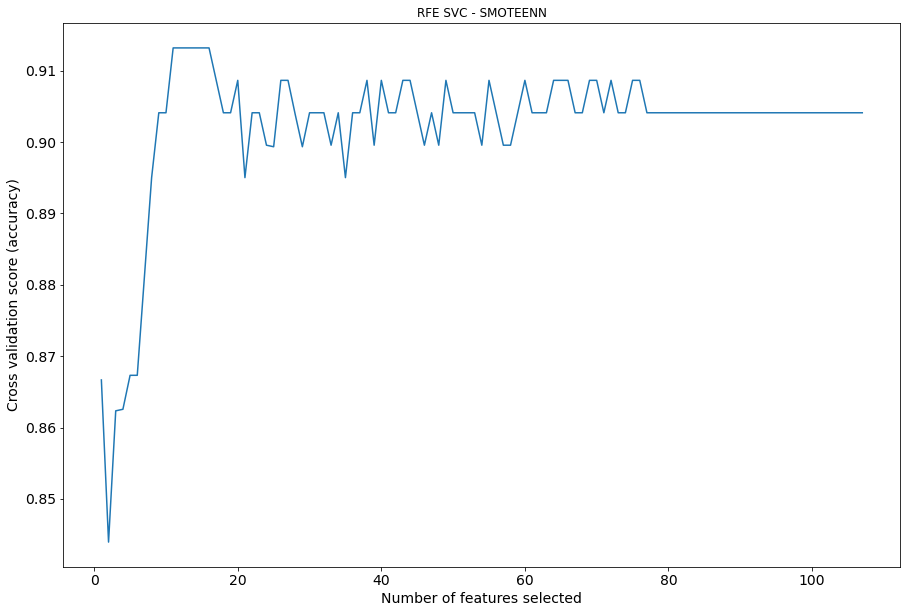

Time:  2.5161420000004
Optimal number of features : 11
Best features: Index(['fa1090', 'fa1259', 'fa1296', 'fa1334', 'fa2118', 'fa2181', 'fa2911',
       'fa3174', 'fa4000', 'fa4896', 'fa6349'],
      dtype='object')


In [118]:
rfeSVC_feat_3=X_train3.columns[rfecv_3.support_]

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15,10))
plt.title("RFE SVC - SMOTEENN")
plt.xlabel("Number of features selected",fontsize=14)
plt.ylabel("Cross validation score (accuracy)",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.plot(
    range(min_features_to_select, len(rfecv_3.grid_scores_) + min_features_to_select),
    rfecv_3.cv_results_['mean_test_score'],
)
plt.show()
print('Time: ',rfe_svc_time_3)
print("Optimal number of features : %d" % rfecv_3.n_features_)
print("Best features:", X_train3.columns[rfecv_3.support_])

##### 04 - SMOTETomek Results

In [119]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

start = timeit.default_timer()

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv_4 = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(10),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv_4.fit(X_train4, y_train4)

ranking = pd.DataFrame(rfecv_4.ranking_, columns = ['Ranking'])
features=pd.DataFrame(X_train4.columns.values[rfecv_4.ranking_],columns=['Features'])
# feature_rank=pd.concat([ranking,features],axis=1)
rfe_svc_4=X_train4.columns[rfecv_4.support_]
rfe_svc_4_total=X_train4.columns[rfecv_4.support_].size

stop = timeit.default_timer()

rfe_svc_time_4=stop-start

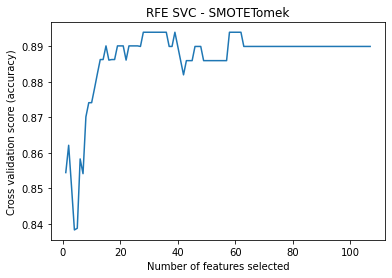

Time:  3.315303800001857
Optimal number of features : 28
Best features: Index(['fa771', 'fa1029', 'fa1059', 'fa1090', 'fa1122', 'fa1259', 'fa1296',
       'fa1781', 'fa1834', 'fa1887', 'fa2058', 'fa2118', 'fa2181', 'fa2244',
       'fa2911', 'fa3084', 'fa3174', 'fa3267', 'fa3363', 'fa4000', 'fa4117',
       'fa4237', 'fa4756', 'fa4896', 'fa5039', 'fa5495', 'fa5656', 'fa5993'],
      dtype='object')


In [120]:
rfeSVC_feat_4=X_train4.columns[rfecv_4.support_]

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title("RFE SVC - SMOTETomek")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv_4.grid_scores_) + min_features_to_select),
    rfecv_4.cv_results_['mean_test_score'],
)
plt.show()
print('Time: ',rfe_svc_time_4)
print("Optimal number of features : %d" % rfecv_4.n_features_)
print("Best features:", X_train4.columns[rfecv_4.support_])

#### 02 - Recursive Feature Elimination (Random Forest Classifier)

##### 00 - Original Results

In [71]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
start = timeit.default_timer()

cv_estimator = RandomForestClassifier(random_state =12)
cv_estimator.fit(X_train0, y_train0)
cv_selector_rf_0 = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
cv_selector_rf_0 = cv_selector_rf_0.fit(X_train0, y_train0)

stop = timeit.default_timer()
rfe_rf_time_0=stop-start

Time:  179.2711216000007
Optimal number of features : 12
Best features : ['fa257', 'fa1090', 'fa1122', 'fa1155', 'fa1224', 'fa1296', 'fa1334', 'fa1373', 'fa1414', 'fa4117', 'fa4896', 'fa5039']


<AxesSubplot:xlabel='f_importance', ylabel='name'>

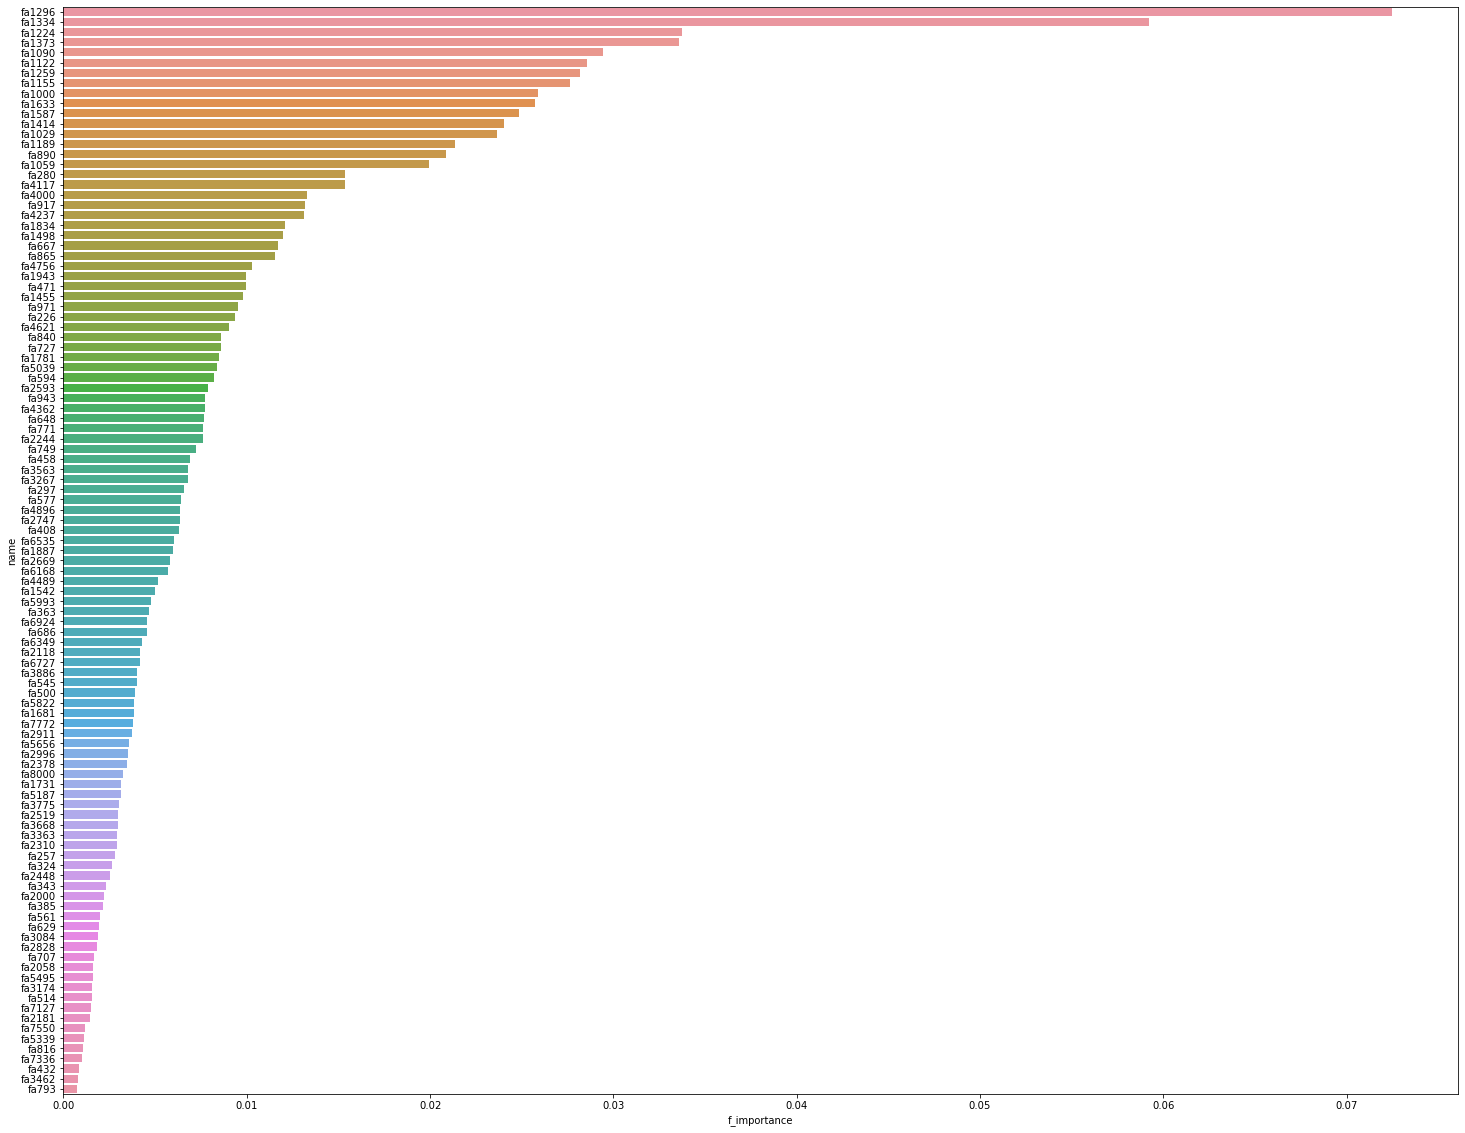

In [72]:
rfecv_mask = cv_selector_rf_0.get_support() #list of booleans
rfecv_feat_rf_0 = [] 
for bool, feature in zip(rfecv_mask, X_train0.columns):
    if bool:
        rfecv_feat_rf_0.append(feature)
        
print('Time: ',rfe_rf_time_0)
print('Optimal number of features :', cv_selector_rf_0.n_features_)
print('Best features :', rfecv_feat_rf_0)
n_features = X_train0.shape[1]

n0=np.arange(n_features)
v0=X_train0.columns.values
f0=cv_estimator.feature_importances_

rfecv_rf_0=pd.DataFrame({'idx':n0,'name':v0,'f_importance':f0})
rfecv_rf_0

plt.figure(figsize=(25,20))
sb.barplot(x='f_importance',
            y="name", 
            data=rfecv_rf_0, 
            order=rfecv_rf_0.sort_values('f_importance',ascending=False).name)

##### 01 - Nearmiss Results

In [73]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
start = timeit.default_timer()

cv_estimator = RandomForestClassifier(random_state =12)
cv_estimator.fit(X_train1, y_train1)
cv_selector_rf_1 = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
cv_selector_rf_1 = cv_selector_rf_1.fit(X_train1, y_train1)

stop = timeit.default_timer()
rfe_rf_time_1=stop-start

Time:  83.53038120000019
Optimal number of features : 9
Best features : ['fa226', 'fa280', 'fa749', 'fa816', 'fa1029', 'fa1090', 'fa2996', 'fa3668', 'fa5656']


<AxesSubplot:xlabel='f_importance', ylabel='name'>

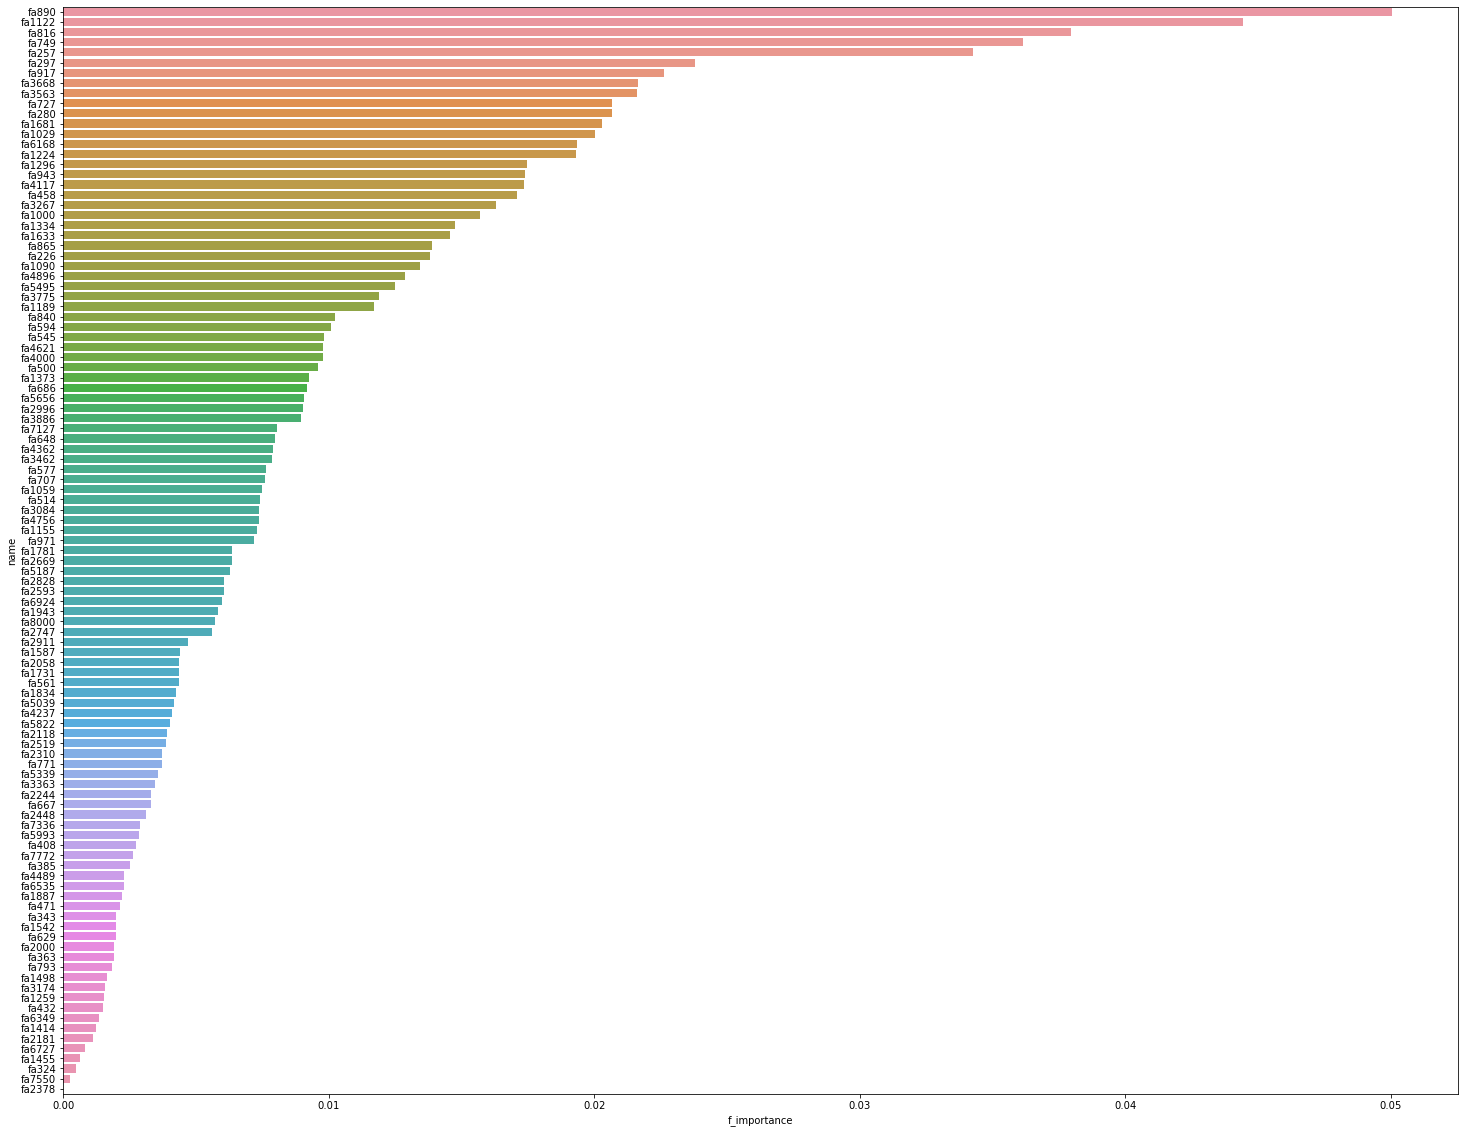

In [74]:
rfecv_mask = cv_selector_rf_1.get_support() #list of booleans
rfecv_feat_rf_1 = [] 
for bool, feature in zip(rfecv_mask, X_train1.columns):
    if bool:
        rfecv_feat_rf_1.append(feature)
        
print('Time: ',rfe_rf_time_1)
print('Optimal number of features :', cv_selector_rf_1.n_features_)
print('Best features :', rfecv_feat_rf_1)
n_features = X_train1.shape[1]

n1=np.arange(n_features)
v1=X_train1.columns.values
f1=cv_estimator.feature_importances_

rfecv_rf_1=pd.DataFrame({'idx':n1,'name':v1,'f_importance':f1})
rfecv_rf_1

plt.figure(figsize=(25,20))
sb.barplot(x='f_importance',
            y="name", 
            data=rfecv_rf_1, 
            order=rfecv_rf_1.sort_values('f_importance',ascending=False).name)

Optimal number of features : 9
Best features : ['fa226', 'fa280', 'fa749', 'fa816', 'fa1029', 'fa1090', 'fa2996', 'fa3668', 'fa5656']


<AxesSubplot:xlabel='f_importance', ylabel='name'>

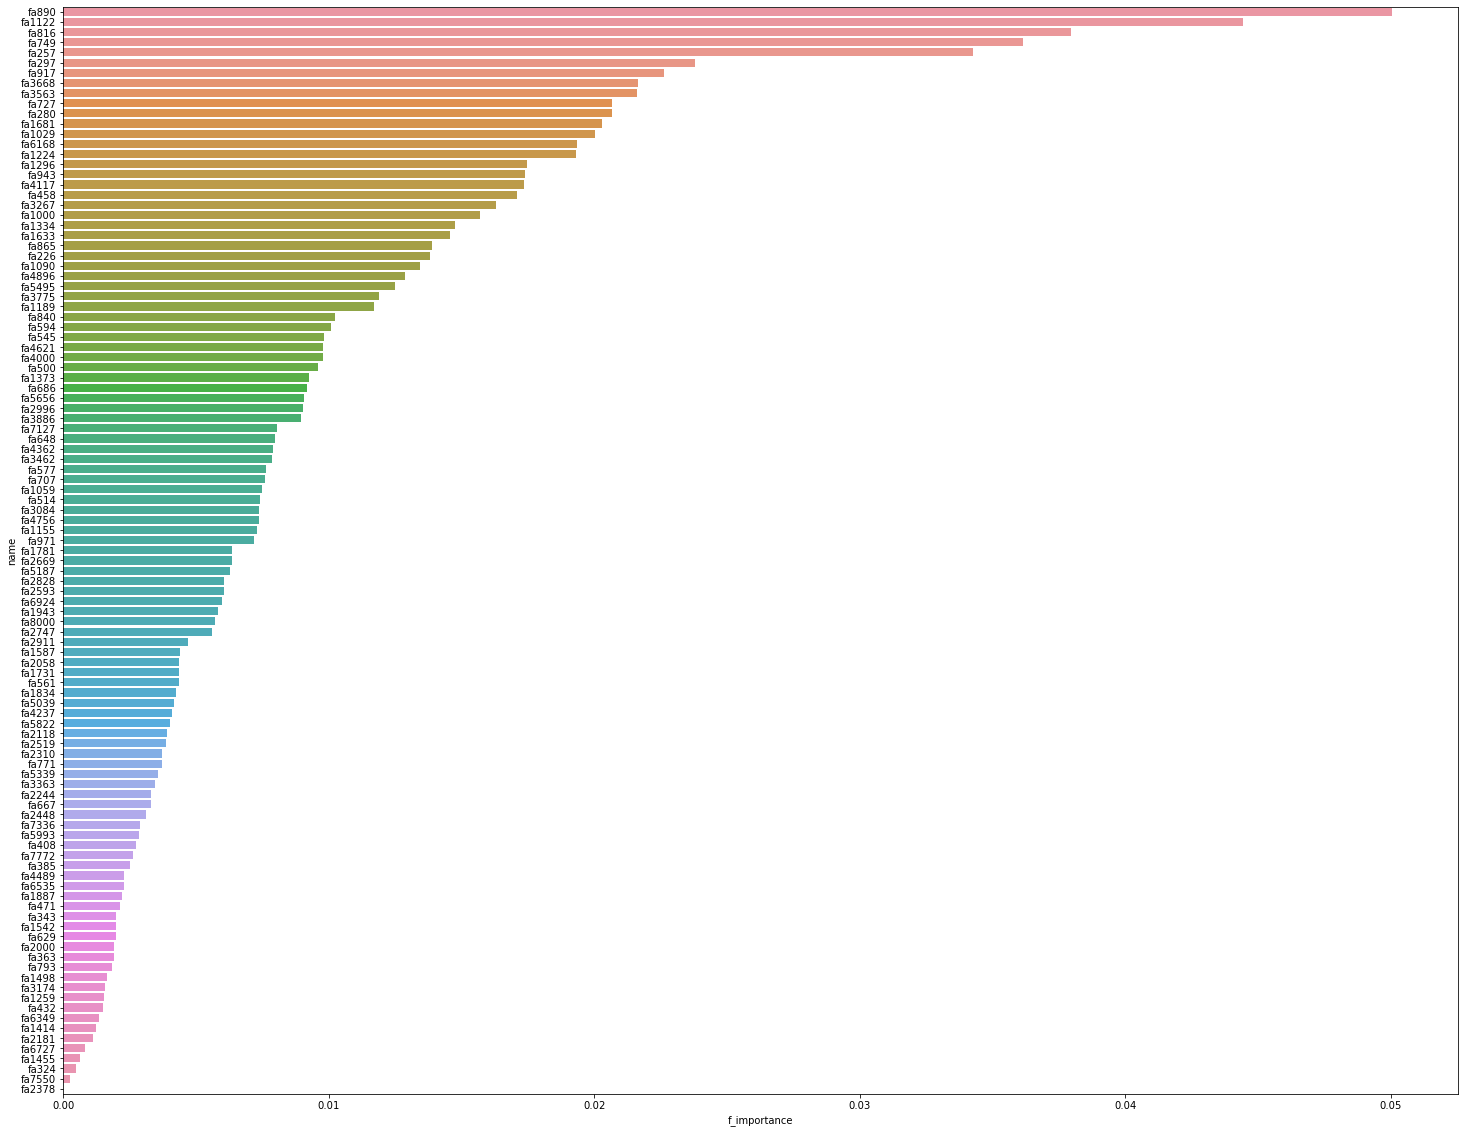

In [75]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
cv_estimator = RandomForestClassifier(random_state =12)

cv_estimator.fit(X_train1, y_train1)
cv_selector_rf_1 = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
cv_selector_rf_1 = cv_selector_rf_1.fit(X_train1, y_train1)
rfecv_mask = cv_selector_rf_1.get_support() #list of booleans
rfecv_feat_rf_1 = [] 
for bool, feature in zip(rfecv_mask, X_train1.columns):
    if bool:
        rfecv_feat_rf_1.append(feature)
print('Optimal number of features :', cv_selector_rf_1.n_features_)
print('Best features :', rfecv_feat_rf_1)
n_features = X_train1.shape[1]

n1=np.arange(n_features)
v1=X_train1.columns.values
f1=cv_estimator.feature_importances_

rfecv_rf_1=pd.DataFrame({'idx':n1,'name':v1,'f_importance':f1})
rfecv_rf_1

plt.figure(figsize=(25,20))
sb.barplot(x='f_importance',
            y="name", 
            data=rfecv_rf_1, 
            order=rfecv_rf_1.sort_values('f_importance',ascending=False).name)

##### 02 - SMOTE Results

In [76]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
start = timeit.default_timer()

cv_estimator = RandomForestClassifier(random_state =12)
cv_estimator.fit(X_train2, y_train2)
cv_selector_rf_2 = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
cv_selector_rf_2 = cv_selector_rf_2.fit(X_train2, y_train2)

stop = timeit.default_timer()
rfe_rf_time_2=stop-start

Time:  117.8917094999997
Optimal number of features : 22
Best features : ['fa727', 'fa943', 'fa971', 'fa1000', 'fa1029', 'fa1059', 'fa1090', 'fa1122', 'fa1155', 'fa1189', 'fa1296', 'fa1334', 'fa1633', 'fa1731', 'fa1781', 'fa1887', 'fa1943', 'fa2000', 'fa4000', 'fa4117', 'fa4237', 'fa4621']


<AxesSubplot:xlabel='f_importance', ylabel='name'>

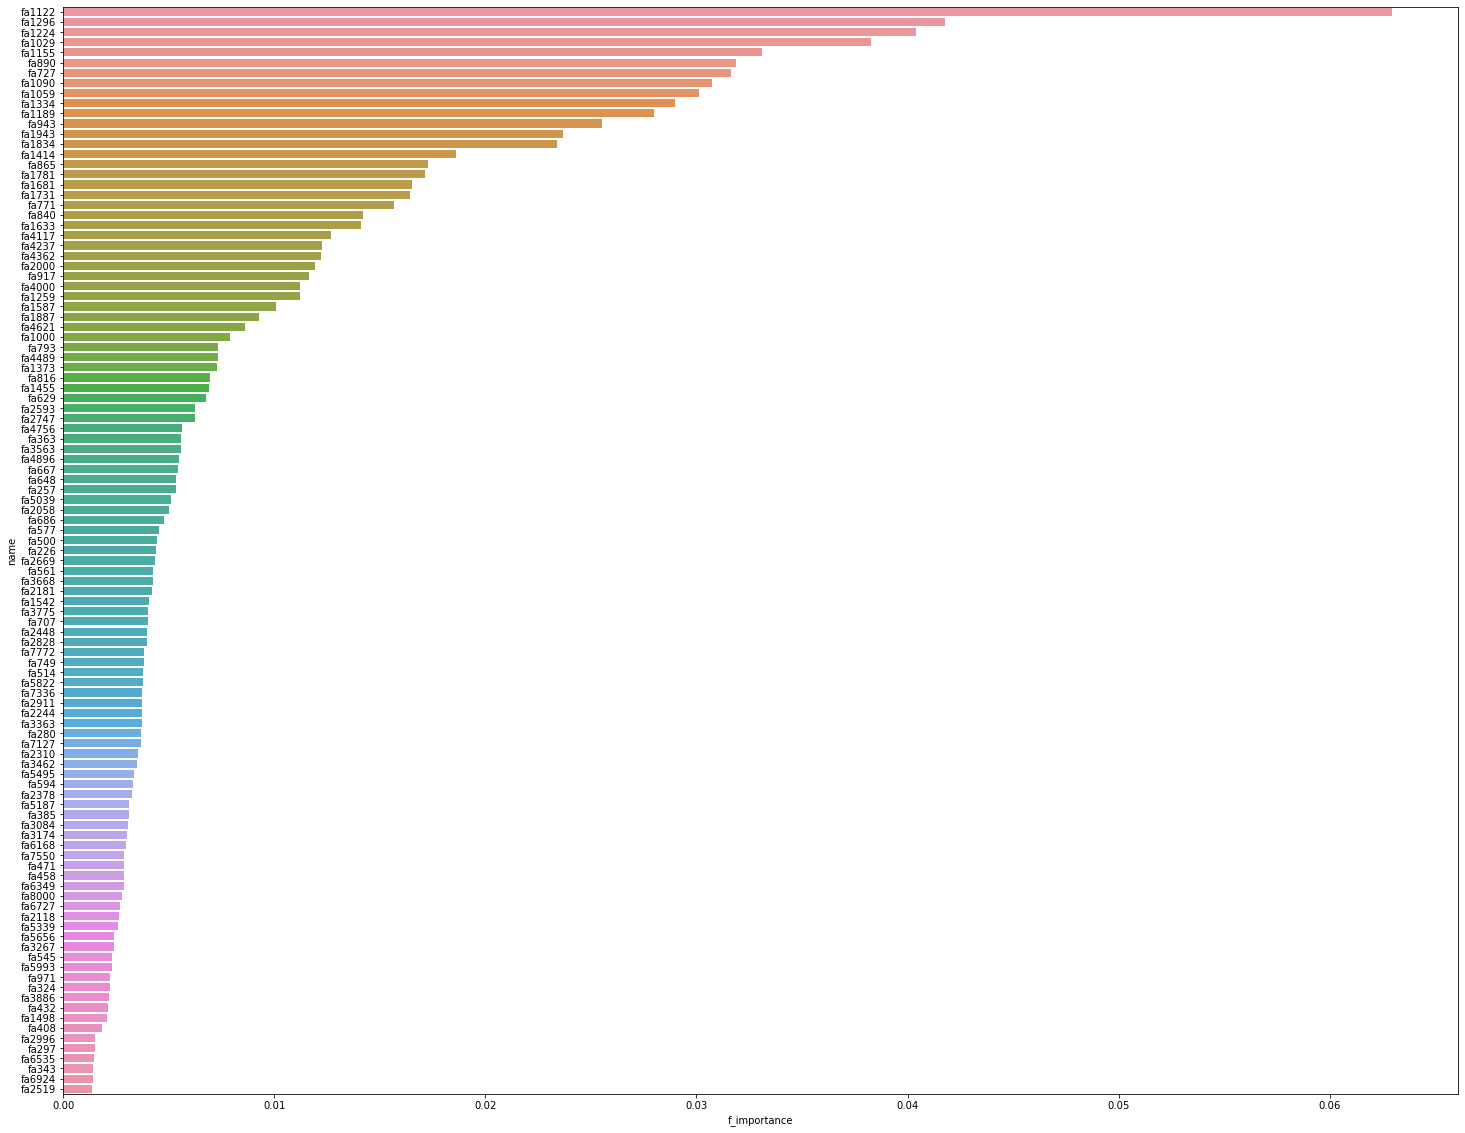

In [77]:
rfecv_mask = cv_selector_rf_2.get_support() #list of booleans
rfecv_feat_rf_2 = [] 
for bool, feature in zip(rfecv_mask, X_train2.columns):
    if bool:
        rfecv_feat_rf_2.append(feature)
        
print('Time: ',rfe_rf_time_2)
print('Optimal number of features :', cv_selector_rf_2.n_features_)
print('Best features :', rfecv_feat_rf_2)
n_features = X_train2.shape[1]

n2=np.arange(n_features)
v2=X_train2.columns.values
f2=cv_estimator.feature_importances_

rfecv_rf_2=pd.DataFrame({'idx':n2,'name':v2,'f_importance':f2})
rfecv_rf_2

plt.figure(figsize=(25,20))
sb.barplot(x='f_importance',
            y="name", 
            data=rfecv_rf_2, 
            order=rfecv_rf_2.sort_values('f_importance',ascending=False).name)

Optimal number of features : 22
Best features : ['fa727', 'fa943', 'fa971', 'fa1000', 'fa1029', 'fa1059', 'fa1090', 'fa1122', 'fa1155', 'fa1189', 'fa1296', 'fa1334', 'fa1633', 'fa1731', 'fa1781', 'fa1887', 'fa1943', 'fa2000', 'fa4000', 'fa4117', 'fa4237', 'fa4621']


<AxesSubplot:xlabel='f_importance', ylabel='name'>

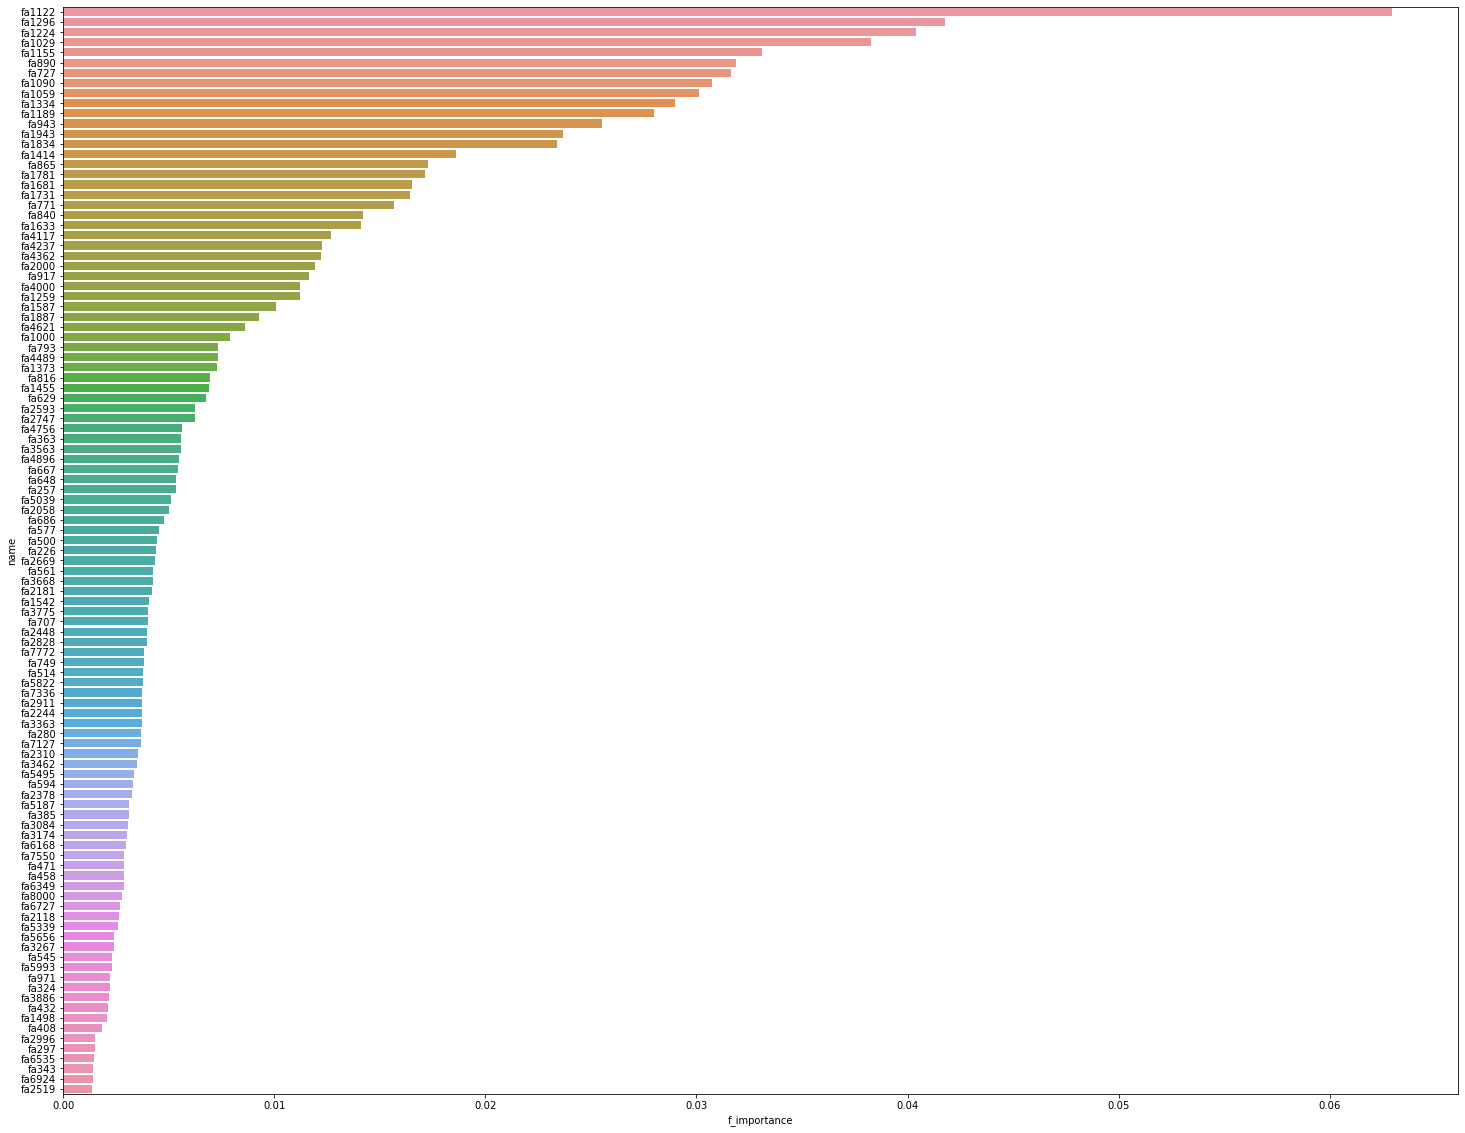

In [78]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
cv_estimator = RandomForestClassifier(random_state =12)

cv_estimator.fit(X_train2, y_train2)
cv_selector_rf_2 = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
cv_selector_rf_2 = cv_selector_rf_2.fit(X_train2, y_train2)
rfecv_mask = cv_selector_rf_2.get_support() #list of booleans
rfecv_feat_rf_2 = [] 
for bool, feature in zip(rfecv_mask, X_train2.columns):
    if bool:
        rfecv_feat_rf_2.append(feature)
print('Optimal number of features :', cv_selector_rf_2.n_features_)
print('Best features :', rfecv_feat_rf_2)
n_features = X_train2.shape[1]

n2=np.arange(n_features)
v2=X_train2.columns.values
f2=cv_estimator.feature_importances_

rfecv_rf_2=pd.DataFrame({'idx':n2,'name':v2,'f_importance':f2})
rfecv_rf_2

plt.figure(figsize=(25,20))
sb.barplot(x='f_importance',
            y="name", 
            data=rfecv_rf_2, 
            order=rfecv_rf_2.sort_values('f_importance',ascending=False).name)

##### 03 - SMOTEENN Results

In [79]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
start = timeit.default_timer()

cv_estimator = RandomForestClassifier(random_state =12)
cv_estimator.fit(X_train3, y_train3)
cv_selector_rf_3 = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
cv_selector_rf_3 = cv_selector_rf_3.fit(X_train3, y_train3)

stop = timeit.default_timer()
rfe_rf_time_3=stop-start

Time:  99.80850309999914
Optimal number of features : 68
Best features : ['fa226', 'fa280', 'fa343', 'fa408', 'fa432', 'fa458', 'fa514', 'fa629', 'fa648', 'fa686', 'fa727', 'fa749', 'fa771', 'fa840', 'fa865', 'fa917', 'fa943', 'fa971', 'fa1029', 'fa1059', 'fa1090', 'fa1122', 'fa1155', 'fa1189', 'fa1224', 'fa1259', 'fa1296', 'fa1334', 'fa1373', 'fa1414', 'fa1455', 'fa1498', 'fa1587', 'fa1633', 'fa1681', 'fa1731', 'fa1781', 'fa1834', 'fa1887', 'fa1943', 'fa2000', 'fa2058', 'fa2118', 'fa2181', 'fa2310', 'fa2378', 'fa2519', 'fa3174', 'fa3563', 'fa3668', 'fa3775', 'fa4000', 'fa4117', 'fa4237', 'fa4362', 'fa4489', 'fa4621', 'fa4756', 'fa4896', 'fa5039', 'fa5187', 'fa6168', 'fa6349', 'fa6727', 'fa6924', 'fa7127', 'fa7336', 'fa7772']


<AxesSubplot:xlabel='f_importance', ylabel='name'>

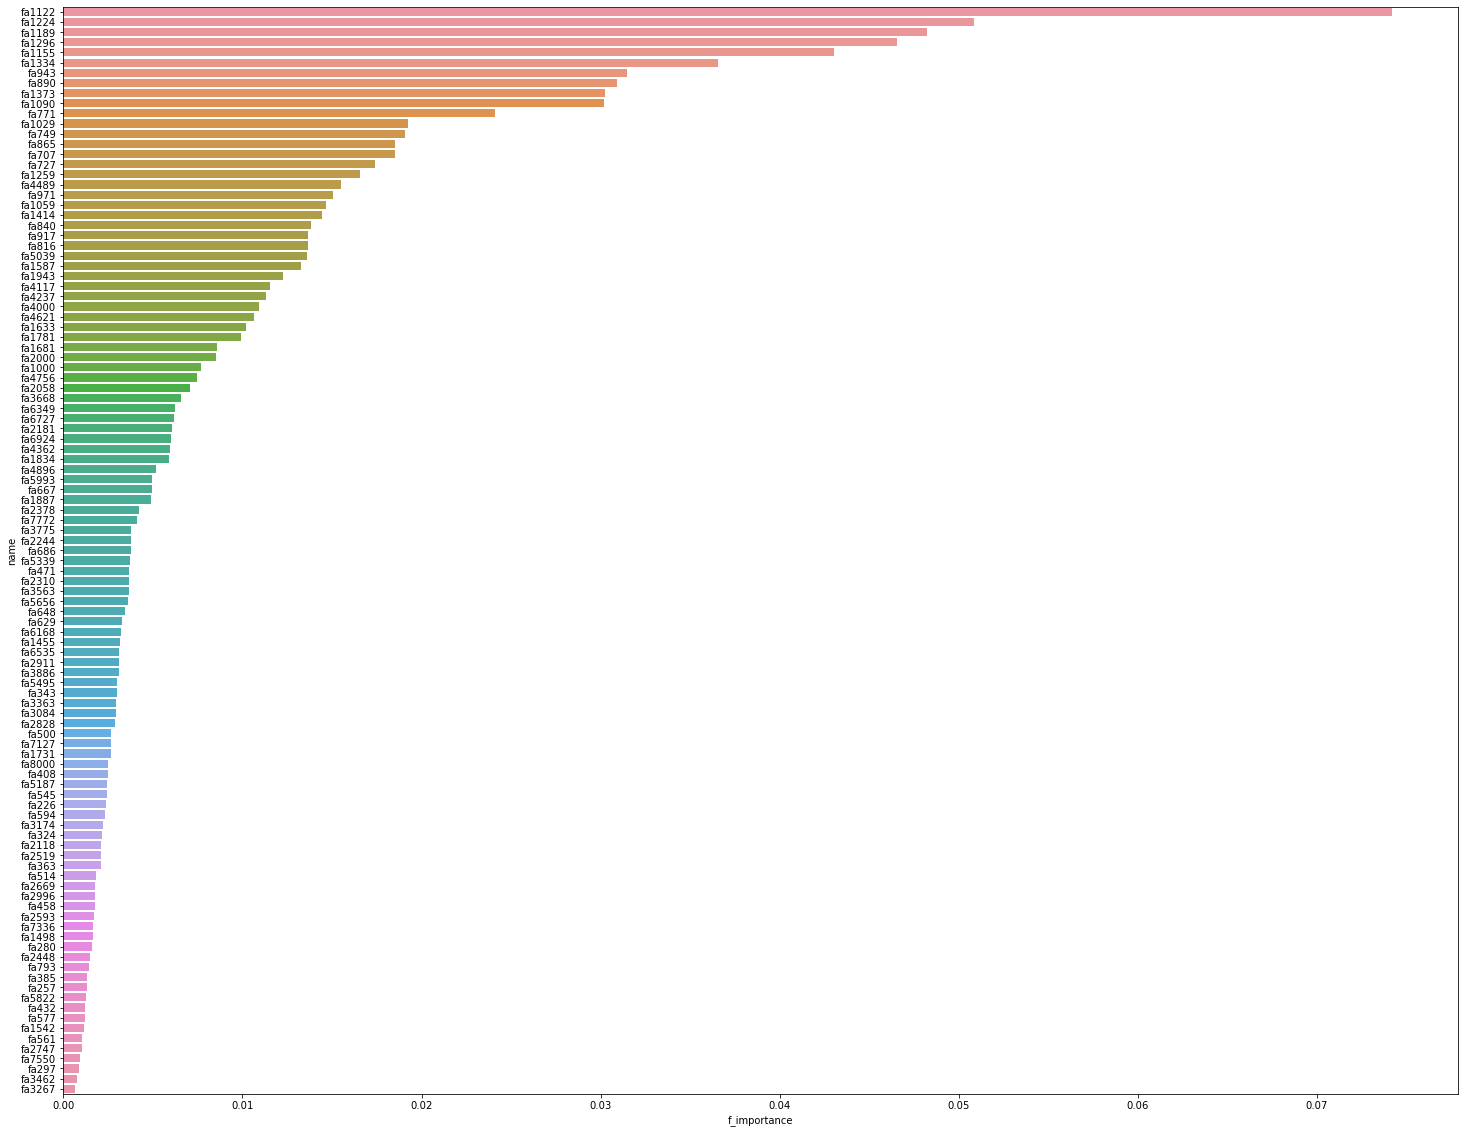

In [80]:
rfecv_mask = cv_selector_rf_3.get_support() #list of booleans
rfecv_feat_rf_3 = [] 
for bool, feature in zip(rfecv_mask, X_train3.columns):
    if bool:
        rfecv_feat_rf_3.append(feature)
        
print('Time: ',rfe_rf_time_3)
print('Optimal number of features :', cv_selector_rf_3.n_features_)
print('Best features :', rfecv_feat_rf_3)
n_features = X_train3.shape[1]

n3=np.arange(n_features)
v3=X_train3.columns.values
f3=cv_estimator.feature_importances_

rfecv_rf_3=pd.DataFrame({'idx':n3,'name':v3,'f_importance':f3})
rfecv_rf_3

plt.figure(figsize=(25,20))
sb.barplot(x='f_importance',
            y="name", 
            data=rfecv_rf_3, 
            order=rfecv_rf_3.sort_values('f_importance',ascending=False).name)

Optimal number of features : 68
Best features : ['fa226', 'fa280', 'fa343', 'fa408', 'fa432', 'fa458', 'fa514', 'fa629', 'fa648', 'fa686', 'fa727', 'fa749', 'fa771', 'fa840', 'fa865', 'fa917', 'fa943', 'fa971', 'fa1029', 'fa1059', 'fa1090', 'fa1122', 'fa1155', 'fa1189', 'fa1224', 'fa1259', 'fa1296', 'fa1334', 'fa1373', 'fa1414', 'fa1455', 'fa1498', 'fa1587', 'fa1633', 'fa1681', 'fa1731', 'fa1781', 'fa1834', 'fa1887', 'fa1943', 'fa2000', 'fa2058', 'fa2118', 'fa2181', 'fa2310', 'fa2378', 'fa2519', 'fa3174', 'fa3563', 'fa3668', 'fa3775', 'fa4000', 'fa4117', 'fa4237', 'fa4362', 'fa4489', 'fa4621', 'fa4756', 'fa4896', 'fa5039', 'fa5187', 'fa6168', 'fa6349', 'fa6727', 'fa6924', 'fa7127', 'fa7336', 'fa7772']


<AxesSubplot:xlabel='f_importance', ylabel='name'>

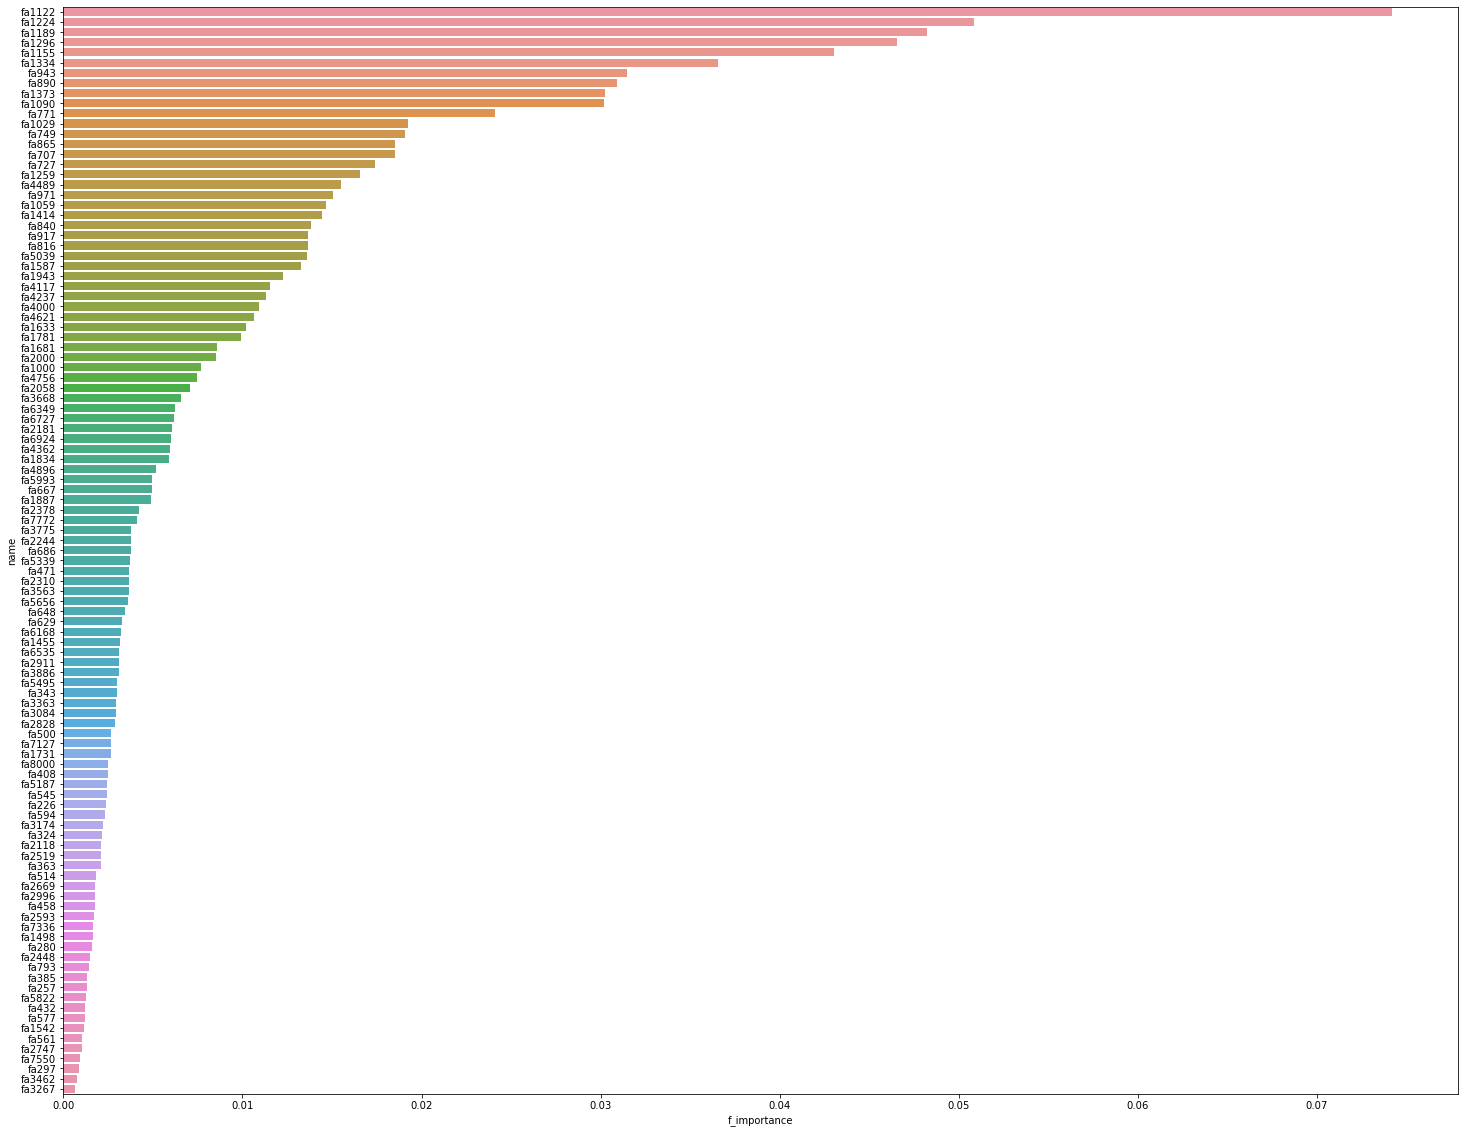

In [81]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
cv_estimator = RandomForestClassifier(random_state =12)

cv_estimator.fit(X_train3, y_train3)
cv_selector_rf_3 = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
cv_selector_rf_3 = cv_selector_rf_3.fit(X_train3, y_train3)
rfecv_mask = cv_selector_rf_3.get_support() #list of booleans
rfecv_feat_rf_3 = [] 
for bool, feature in zip(rfecv_mask, X_train3.columns):
    if bool:
        rfecv_feat_rf_3.append(feature)
print('Optimal number of features :', cv_selector_rf_3.n_features_)
print('Best features :', rfecv_feat_rf_3)
n_features = X_train3.shape[1]

n3=np.arange(n_features)
v3=X_train3.columns.values
f3=cv_estimator.feature_importances_

rfecv_rf_3=pd.DataFrame({'idx':n3,'name':v3,'f_importance':f3})
rfecv_rf_3

plt.figure(figsize=(25,20))
sb.barplot(x='f_importance',
            y="name", 
            data=rfecv_rf_3, 
            order=rfecv_rf_3.sort_values('f_importance',ascending=False).name)

##### 04 - SMOTETomek Results

In [82]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
start = timeit.default_timer()

cv_estimator = RandomForestClassifier(random_state =12)
cv_estimator.fit(X_train4, y_train4)
cv_selector_rf_4 = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
cv_selector_rf_4 = cv_selector_rf_4.fit(X_train4, y_train4)

stop = timeit.default_timer()
rfe_rf_time_4=stop-start

Time:  172.22547029999987
Optimal number of features : 61
Best features : ['fa226', 'fa257', 'fa343', 'fa385', 'fa432', 'fa471', 'fa561', 'fa594', 'fa629', 'fa648', 'fa667', 'fa686', 'fa727', 'fa749', 'fa771', 'fa865', 'fa890', 'fa917', 'fa971', 'fa1000', 'fa1029', 'fa1059', 'fa1090', 'fa1122', 'fa1155', 'fa1189', 'fa1224', 'fa1259', 'fa1296', 'fa1334', 'fa1373', 'fa1455', 'fa1498', 'fa1681', 'fa1731', 'fa1781', 'fa1834', 'fa1887', 'fa1943', 'fa2000', 'fa2058', 'fa2181', 'fa2244', 'fa2747', 'fa2996', 'fa3363', 'fa3462', 'fa3563', 'fa3668', 'fa3775', 'fa3886', 'fa4000', 'fa4117', 'fa4237', 'fa4362', 'fa4489', 'fa4621', 'fa4756', 'fa4896', 'fa5039', 'fa5187']


<AxesSubplot:xlabel='f_importance', ylabel='name'>

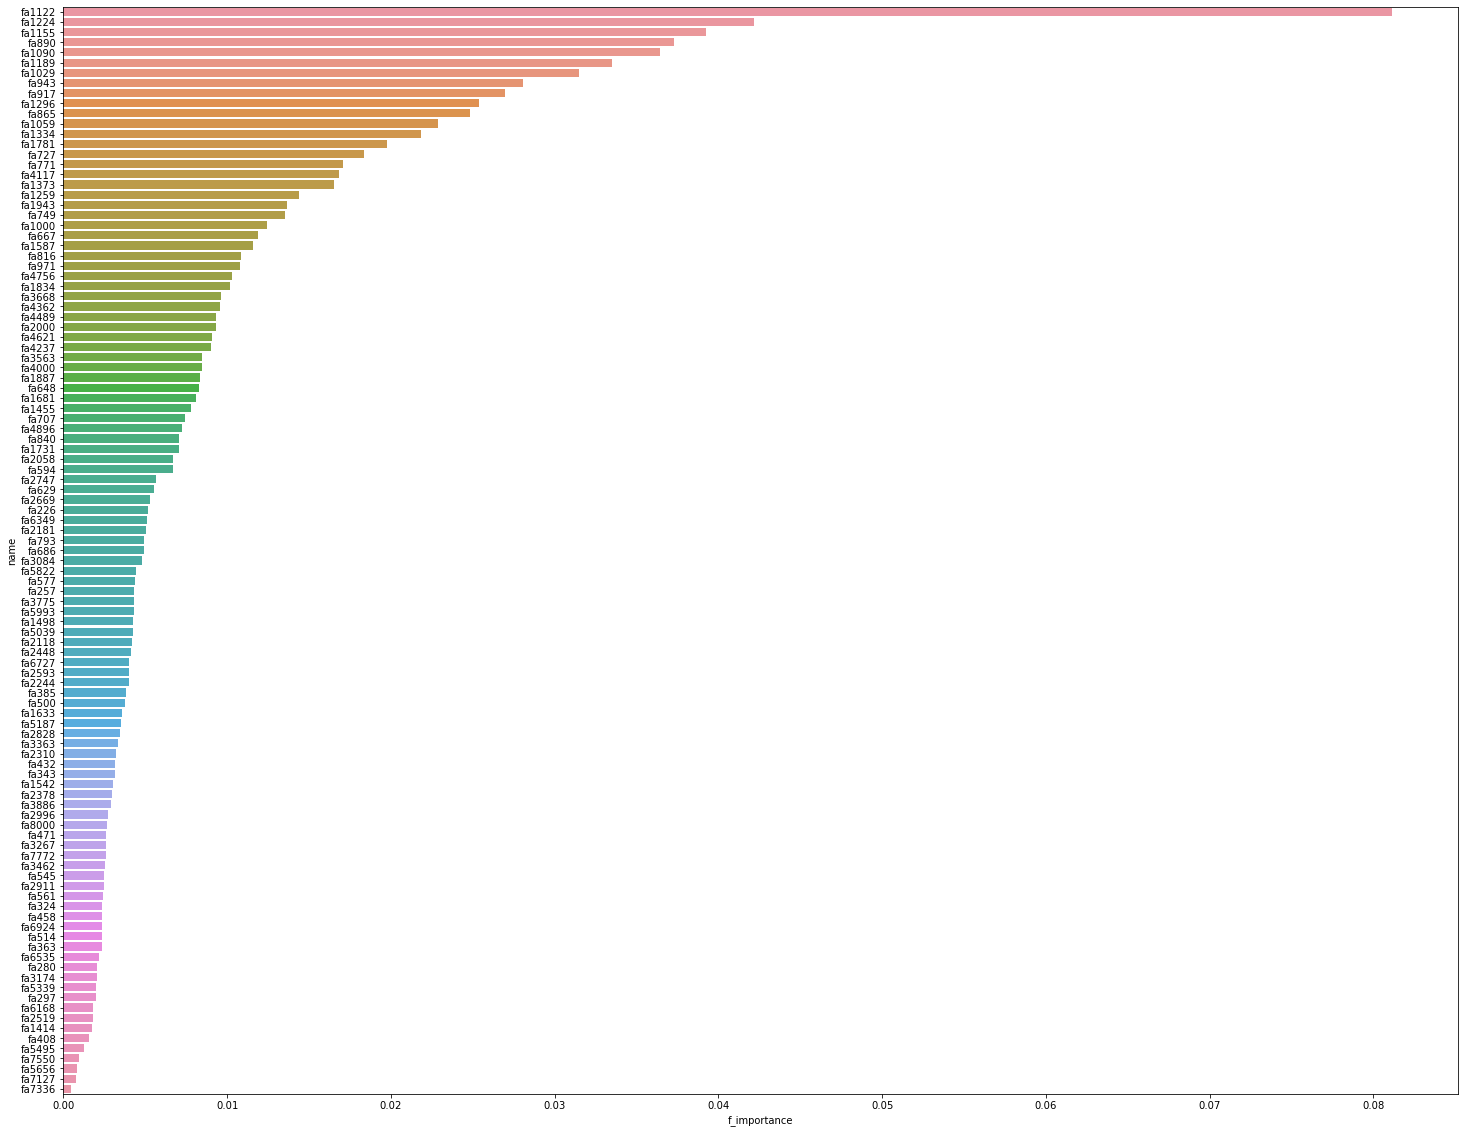

In [83]:
rfecv_mask = cv_selector_rf_4.get_support() #list of booleans
rfecv_feat_rf_4 = [] 
for bool, feature in zip(rfecv_mask, X_train4.columns):
    if bool:
        rfecv_feat_rf_4.append(feature)
        
print('Time: ',rfe_rf_time_4)
print('Optimal number of features :', cv_selector_rf_4.n_features_)
print('Best features :', rfecv_feat_rf_4)
n_features = X_train4.shape[1]

n4=np.arange(n_features)
v4=X_train4.columns.values
f4=cv_estimator.feature_importances_

rfecv_rf_4=pd.DataFrame({'idx':n4,'name':v4,'f_importance':f4})
rfecv_rf_4

plt.figure(figsize=(25,20))
sb.barplot(x='f_importance',
            y="name", 
            data=rfecv_rf_4, 
            order=rfecv_rf_4.sort_values('f_importance',ascending=False).name)

Optimal number of features : 37
Best features : ['fa226', 'fa667', 'fa686', 'fa727', 'fa749', 'fa890', 'fa917', 'fa971', 'fa1000', 'fa1029', 'fa1059', 'fa1090', 'fa1122', 'fa1155', 'fa1189', 'fa1224', 'fa1259', 'fa1296', 'fa1334', 'fa1373', 'fa1455', 'fa1834', 'fa1887', 'fa1943', 'fa2000', 'fa2181', 'fa3563', 'fa3668', 'fa3775', 'fa4000', 'fa4117', 'fa4237', 'fa4362', 'fa4489', 'fa4621', 'fa4756', 'fa5039']


<AxesSubplot:xlabel='f_importance', ylabel='name'>

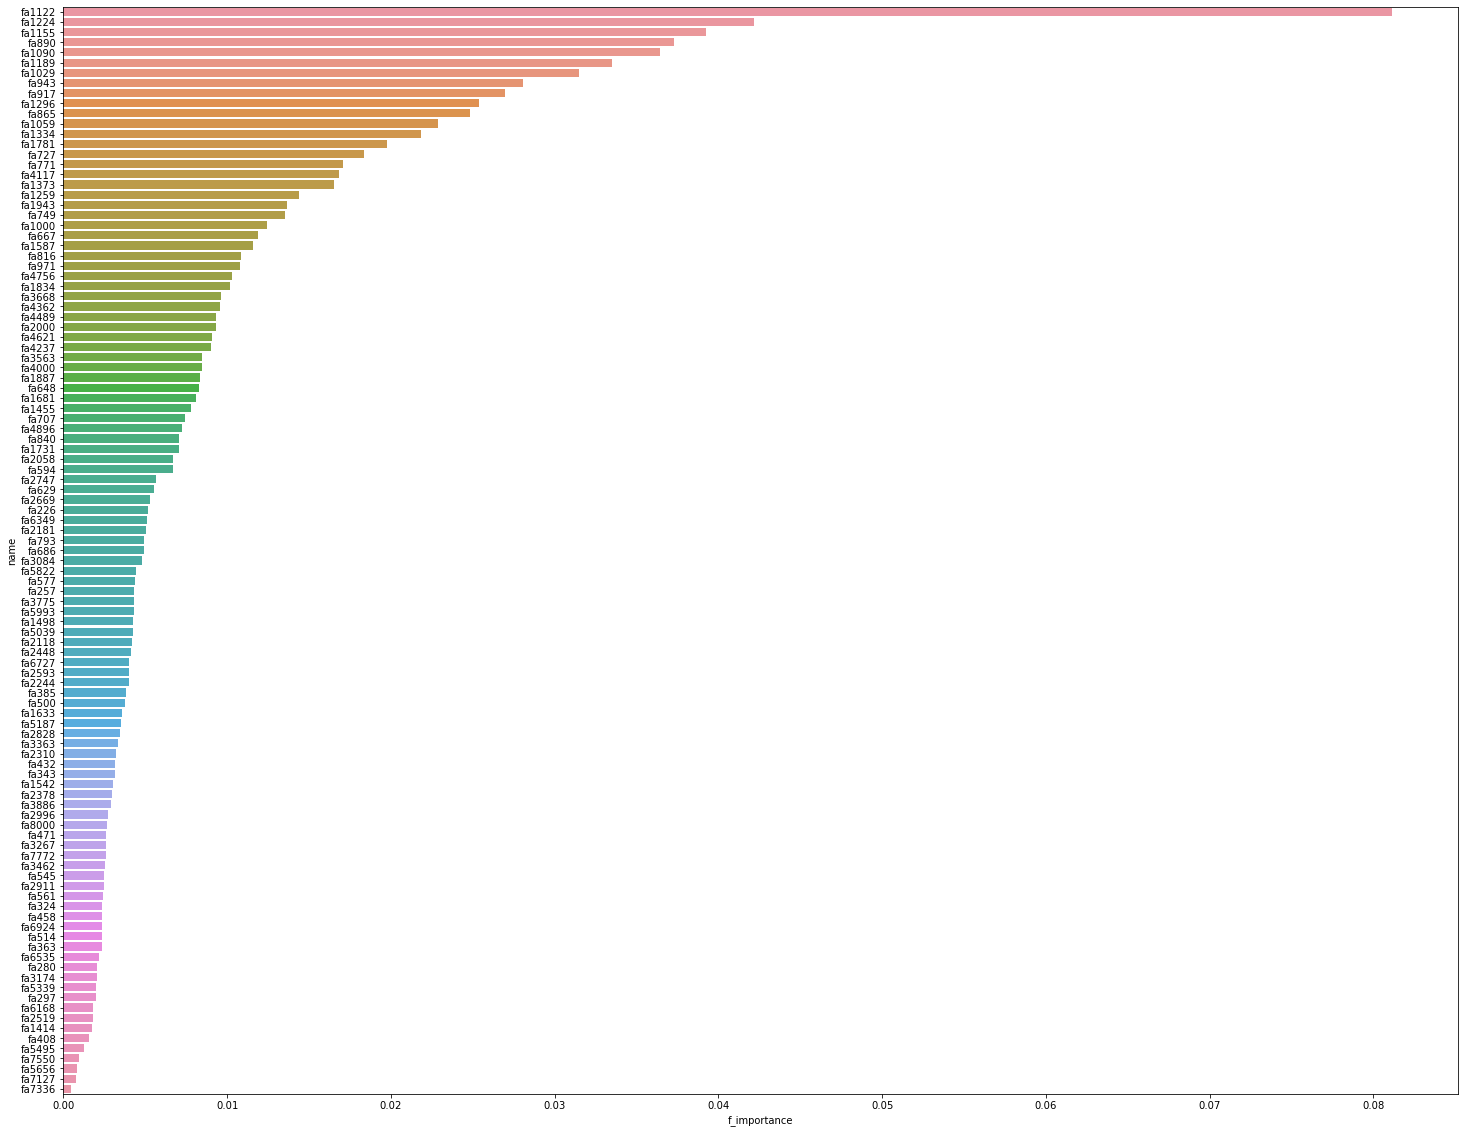

In [84]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
cv_estimator = RandomForestClassifier(random_state =12)

cv_estimator.fit(X_train4, y_train4)
cv_selector_rf_4 = RFECV(cv_estimator,cv= 3, step=1,scoring='accuracy')
cv_selector_rf_4 = cv_selector_rf_4.fit(X_train4, y_train4)
rfecv_mask = cv_selector_rf_4.get_support() #list of booleans
rfecv_feat_rf_4 = [] 
for bool, feature in zip(rfecv_mask, X_train4.columns):
    if bool:
        rfecv_feat_rf_4.append(feature)
print('Optimal number of features :', cv_selector_rf_4.n_features_)
print('Best features :', rfecv_feat_rf_4)
n_features = X_train4.shape[1]

n4=np.arange(n_features)
v4=X_train4.columns.values
f4=cv_estimator.feature_importances_

rfecv_rf_4=pd.DataFrame({'idx':n4,'name':v4,'f_importance':f4})
rfecv_rf_4

plt.figure(figsize=(25,20))
sb.barplot(x='f_importance',
            y="name", 
            data=rfecv_rf_4, 
            order=rfecv_rf_4.sort_values('f_importance',ascending=False).name)

#### 03 - Sequential Feature Selection

##### Selection of K

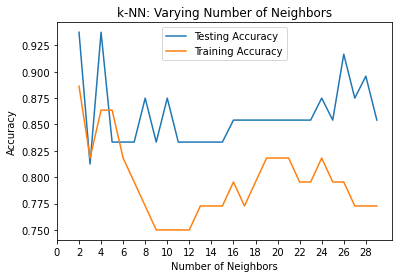

In [89]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.preprocessing import StandardScaler

# Setup arrays to store train and test accuracies

scaler=StandardScaler()
neighbors = np.arange(2, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(scaler.fit_transform(X_train1), y_train1)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(scaler.fit_transform(X_train1), y_train1)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(scaler.transform(X_test1), y_test1)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.xticks(np.arange(0, len(neighbors)+1, 2))
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

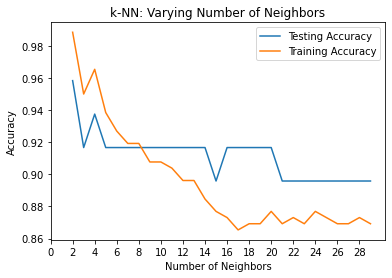

In [90]:
import matplotlib.pyplot as plt

# Setup arrays to store train and test accuracies
neighbors = np.arange(2, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(scaler.fit_transform(X_train2), y_train2)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(scaler.fit_transform(X_train2), y_train2)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(scaler.transform(X_test2), y_test2)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.xticks(np.arange(0, len(neighbors)+1, 2))
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

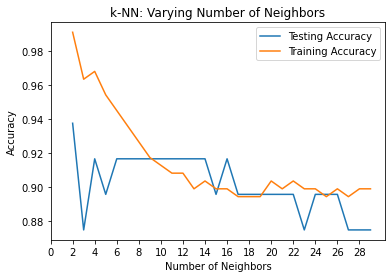

In [91]:
import matplotlib.pyplot as plt

# Setup arrays to store train and test accuracies
neighbors = np.arange(2, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(scaler.fit_transform(X_train3), y_train3)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(scaler.fit_transform(X_train3), y_train3)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(scaler.transform(X_test3), y_test3)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.xticks(np.arange(0, len(neighbors)+1, 2))
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

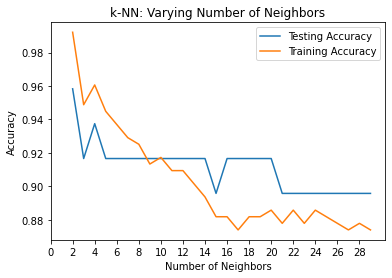

In [92]:
import matplotlib.pyplot as plt

# Setup arrays to store train and test accuracies
neighbors = np.arange(2, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(scaler.fit_transform(X_train4), y_train4)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(scaler.fit_transform(X_train4), y_train4)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(scaler.transform(X_test4), y_test4)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.xticks(np.arange(0, len(neighbors)+1, 2))
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

##### 00 - Original Results

In [93]:
scaler=StandardScaler()
X_train0_scale=scaler.fit_transform(X_train0)
X = pd.DataFrame(X_train0_scale,columns=X_train0.columns)
y = y_train0
knn = KNeighborsClassifier(n_neighbors=2)


# Sequential Forward Selection
start = timeit.default_timer()
sfs0 = sfs(knn, 
          k_features=50, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sfs0 = sfs0.fit(X, y)
stop = timeit.default_timer()
sfs_time_0=stop-start

print("Time: ", sfs_time_0)
print('\nSequential Forward Selection (k=3):')
print(sfs0.k_feature_idx_)
print('CV Score:')
print(sfs0.k_score_)

###################################################

# Sequential Backward Selection
start = timeit.default_timer()
sbs0 = sfs(knn, 
          k_features=5, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sbs0 = sbs0.fit(X, y)
stop = timeit.default_timer()
sbs_time_0=stop-start

print("Time: ", sbs_time_0)
print('\nSequential Backward Selection (k=3):')
print(sbs0.k_feature_idx_)
print('CV Score:')
print(sbs0.k_score_)

###################################################


Time:  37.395238200000676

Sequential Forward Selection (k=3):
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 24, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 66, 68, 70, 71, 72, 73, 79, 99, 100, 101, 102, 103, 104, 105, 106)
CV Score:
0.9406535947712418
Time:  76.96108230000027

Sequential Backward Selection (k=3):
(6, 7, 19, 48, 78)
CV Score:
0.9142483660130719


In [94]:
sfs_score_0=pd.DataFrame.from_dict(sfs0.get_metric_dict()).T.avg_score
max_sfs_score_0 =max(sfs_score_0)
max_sfs_score_0
max_sfs_index_0 = min(sfs_score_0.index[sfs_score_0.values==max_sfs_score_0])
max_sfs_index_0

22

In [95]:
sfs_feat_0=[sfs0.feature_names[i] for i in np.asarray(sfs0.k_feature_idx_[0:max_sfs_index_0+1])]
sfs_feat_0

['fa226',
 'fa257',
 'fa280',
 'fa297',
 'fa324',
 'fa343',
 'fa363',
 'fa385',
 'fa408',
 'fa432',
 'fa458',
 'fa749',
 'fa771',
 'fa816',
 'fa865',
 'fa890',
 'fa917',
 'fa943',
 'fa971',
 'fa1000',
 'fa1029',
 'fa1059',
 'fa1090']

In [96]:
# pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

In [97]:
# pd.DataFrame.from_dict(sbs1.get_metric_dict()).T

In [98]:
sbs_score_0=pd.DataFrame.from_dict(sbs0.get_metric_dict()).T.avg_score
max_sbs_score_0 =max(sbs_score_0)
max_sbs_score_0
max_sbs_index_0 = min(sbs_score_0.index[sbs_score_0.values==max_sbs_score_0])
max_sbs_index_0

9

In [99]:
sbs_feat_0=np.array(pd.DataFrame.from_dict(sbs0.get_metric_dict()).T.iloc[len(sbs0.feature_names)-max_sbs_index_0].feature_names)
sbs_feat_0

array(['fa257', 'fa343', 'fa363', 'fa385', 'fa408', 'fa648', 'fa1498',
       'fa2000', 'fa3563'], dtype='<U6')

In [100]:
## With top 5 features
sbs_feat_0=[sbs0.feature_names[i] for i in np.asarray(sbs0.k_feature_idx_)]
sbs_feat_0

['fa363', 'fa385', 'fa648', 'fa1498', 'fa3563']

In [101]:
sbs0.k_score_

0.9142483660130719

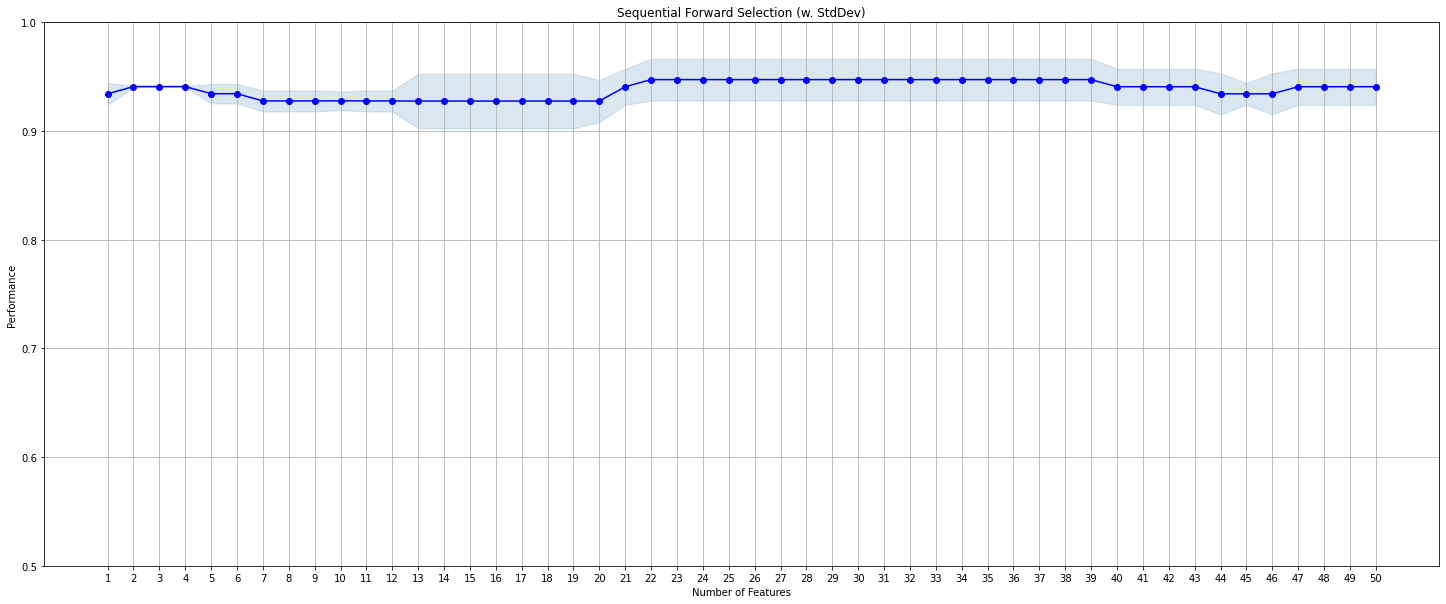

In [126]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs0.get_metric_dict(), kind='std_dev',figsize=(25,10))

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

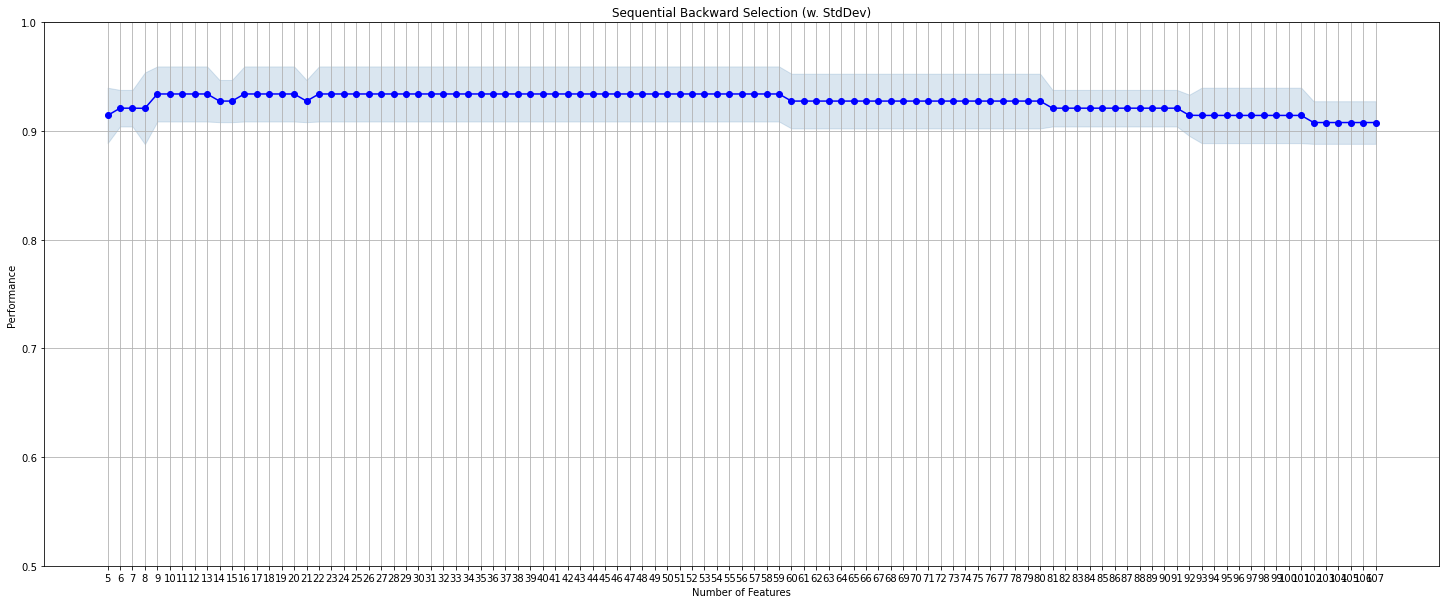

In [128]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


# fig1=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plot_sfs(sbs0.get_metric_dict(), kind='std_dev',figsize=(25,10))

plt.ylim([0.5, 1])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()


##### 01 - Nearmiss Results

In [130]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train1_scale=scaler.fit_transform(X_train1)
X = pd.DataFrame(X_train1_scale,columns=X_train1.columns)
y = y_train1
knn = KNeighborsClassifier(n_neighbors=2)


# Sequential Forward Selection
start = timeit.default_timer()
sfs1 = sfs(knn, 
          k_features=50, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sfs1 = sfs1.fit(X, y)
stop = timeit.default_timer()
sfs_time_1=stop-start

print("Time: ", sfs_time_1)
print('\nSequential Forward Selection (k=3):')
print(sfs1.k_feature_idx_)
print('CV Score:')
print(sfs1.k_score_)

###################################################

# Sequential Backward Selection
start = timeit.default_timer()
sbs1 = sfs(knn, 
          k_features=5, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sbs1 = sbs1.fit(X, y)
stop = timeit.default_timer()
sbs_time_1=stop-start

print("Time: ", sbs_time_1)
print('\nSequential Backward Selection (k=3):')
print(sbs1.k_feature_idx_)
print('CV Score:')
print(sbs1.k_score_)

###################################################


Time:  22.557005499998922

Sequential Forward Selection (k=3):
(0, 4, 5, 6, 7, 8, 11, 13, 14, 15, 16, 18, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 67, 72, 78, 100, 103, 106)
CV Score:
0.8396825396825397
Time:  44.18934870000521

Sequential Backward Selection (k=3):
(0, 35, 39, 44, 77)
CV Score:
0.815873015873016


In [131]:
sfs_score_1=pd.DataFrame.from_dict(sfs1.get_metric_dict()).T.avg_score
max_sfs_score_1 =max(sfs_score_1)
max_sfs_score_1
max_sfs_index_1 = min(sfs_score_1.index[sfs_score_1.values==max_sfs_score_1])
max_sfs_index_1

5

In [132]:
sfs_feat_1=[sfs1.feature_names[i] for i in np.asarray(sfs1.k_feature_idx_[0:max_sfs_index_1])]
sfs_feat_1

['fa226', 'fa324', 'fa343', 'fa363', 'fa385']

In [133]:
# pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

In [134]:
# pd.DataFrame.from_dict(sbs1.get_metric_dict()).T

In [135]:
sbs_score_1=pd.DataFrame.from_dict(sbs1.get_metric_dict()).T.avg_score
max_sbs_score_1 =max(sbs_score_1)
max_sbs_score_1
max_sbs_index_1 = min(sbs_score_1.index[sbs_score_1.values==max_sbs_score_1])
max_sbs_index_1

7

In [136]:
sbs_feat_1=np.array(pd.DataFrame.from_dict(sbs1.get_metric_dict()).T.iloc[len(sbs1.feature_names)-max_sbs_index_1].feature_names)
sbs_feat_1

array(['fa226', 'fa1029', 'fa1155', 'fa1189', 'fa1334', 'fa1373',
       'fa3462'], dtype='<U6')

In [137]:
## With top 5 features
sbs_feat_1=[sbs1.feature_names[i] for i in np.asarray(sbs1.k_feature_idx_)]
sbs_feat_1

['fa226', 'fa1029', 'fa1155', 'fa1334', 'fa3462']

In [138]:
sbs1.k_score_

0.815873015873016

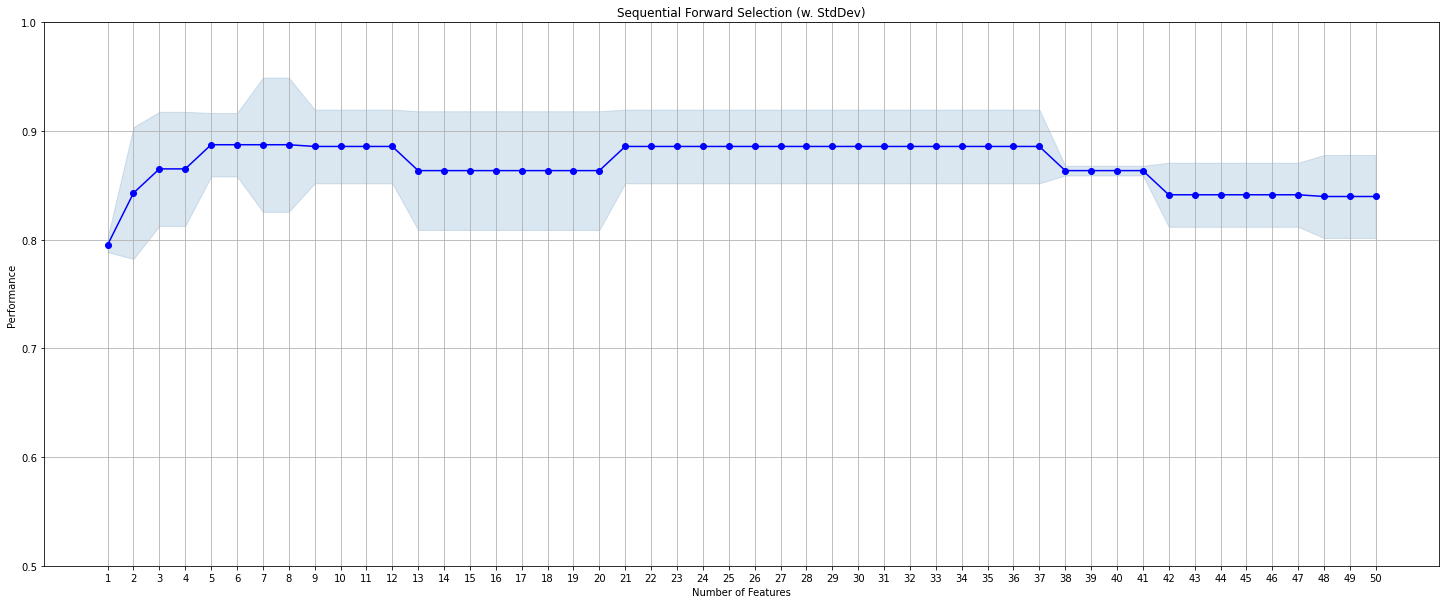

In [139]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev',figsize=(25,10))

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

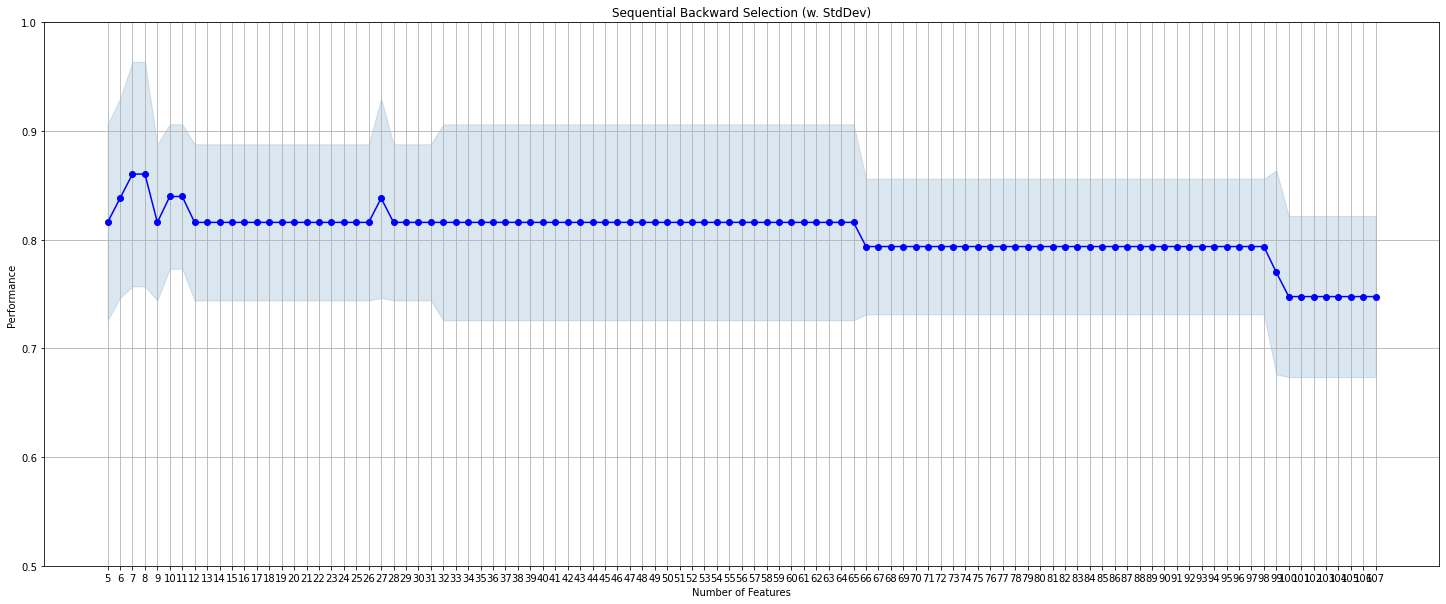

In [140]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


# fig1=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plot_sfs(sbs1.get_metric_dict(), kind='std_dev',figsize=(25,10))

plt.ylim([0.5, 1])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()


##### 02 - SMOTE Results

In [141]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

scaler=StandardScaler()
X_train2_scale=scaler.fit_transform(X_train2)
X = pd.DataFrame(X_train2_scale,columns=X_train2.columns)
y = y_train2
knn = KNeighborsClassifier(n_neighbors=2)


# Sequential Forward Selection
start = timeit.default_timer()
sfs2 = sfs(knn, 
          k_features=50, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sfs2 = sfs2.fit(X, y)
stop = timeit.default_timer()
sfs_time_2=stop-start

print("Time: ", sfs_time_2)
print('\nSequential Forward Selection (k=3):')
print(sfs2.k_feature_idx_)
print('CV Score:')
print(sfs2.k_score_)

###################################################

# Sequential Backward Selection
start = timeit.default_timer()
sbs2 = sfs(knn, 
          k_features=5, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sbs2 = sbs2.fit(X, y)
stop = timeit.default_timer()
sbs_time_2=stop-start

print("Time: ", sbs_time_2)
print('\nSequential Backward Selection (k=3):')
print(sbs2.k_feature_idx_)
print('CV Score:')
print(sbs2.k_score_)

###################################################


Time:  42.14249249999557

Sequential Forward Selection (k=3):
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 22, 24, 26, 31, 32, 34, 35, 36, 37, 38, 39, 43, 44, 45, 46, 55, 56, 57, 58, 60, 61, 62, 64, 69, 70, 71, 72, 76, 77, 79, 80, 81, 82, 87)
CV Score:
0.9577653033948142
Time:  76.43458670000109

Sequential Backward Selection (k=3):
(8, 37, 43, 73, 85)
CV Score:
0.9269357569277377


In [142]:
pd.DataFrame.from_dict(sfs2.get_metric_dict()).T

feature_idx  \
1                                               (39,)   
2                                            (39, 61)   
3                                        (39, 61, 82)   
4                                     (0, 39, 61, 82)   
5                                 (0, 39, 61, 79, 82)   
6                             (0, 39, 61, 77, 79, 82)   
7                         (0, 39, 61, 69, 77, 79, 82)   
8                     (0, 39, 57, 61, 69, 77, 79, 82)   
9                 (0, 39, 57, 61, 69, 77, 79, 81, 82)   
10            (0, 37, 39, 57, 61, 69, 77, 79, 81, 82)   
11         (0, 1, 37, 39, 57, 61, 69, 77, 79, 81, 82)   
12      (0, 1, 7, 37, 39, 57, 61, 69, 77, 79, 81, 82)   
13  (0, 1, 7, 37, 39, 57, 61, 69, 71, 77, 79, 81, 82)   
14  (0, 1, 7, 37, 39, 45, 57, 61, 69, 71, 77, 79, ...   
15  (0, 1, 7, 8, 37, 39, 45, 57, 61, 69, 71, 77, 7...   
16  (0, 1, 7, 8, 37, 39, 43, 45, 57, 61, 69, 71, 7...   
17  (0, 1, 6, 7, 8, 37, 39, 43, 45, 57, 61, 69, 71...   
18  (0, 1, 3, 6, 7, 8, 37, 39, 43, 45, 57, 61, 69,...   
19  (0, 1, 3, 6, 7, 8, 37, 39, 43, 45, 57, 61, 69,...   
20  (0, 1, 3, 6, 7, 8, 10, 37, 39, 43, 45, 57, 61,...   
21  (0, 1, 3, 6, 7, 8, 10, 37, 39, 43, 45, 57, 58,...   
22  (0, 1, 3, 6, 7, 8, 10, 37, 39, 43, 45, 57, 58,...   
23  (0, 1, 3, 6, 7, 8, 10, 37, 39, 43, 45, 57, 58,...   
24  (0, 1, 3, 6, 7, 8, 10, 15, 37, 39, 43, 45, 57,...   
25  (0, 1, 3, 4, 6, 7, 8, 10, 15, 37, 39, 43, 45, ...   
26  (0, 1, 3, 4, 6, 7, 8, 10, 15, 26, 37, 39, 43, ...   
27  (0, 1, 3, 4, 6, 7, 8, 10, 15, 26, 37, 39, 43, ...   
28  (0, 1, 3, 4, 6, 7, 8, 10, 15, 26, 37, 39, 43, ...   
29  (0, 1, 3, 4, 6, 7, 8, 10, 15, 26, 37, 39, 43, ...   
30  (0, 1, 3, 4, 6, 7, 8, 10, 15, 26, 37, 39, 43, ...   
31  (0, 1, 3, 4, 6, 7, 8, 9, 10, 15, 26, 37, 39, 4...   
32  (0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 15, 26, 37, 3...   
33  (0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 15, 26, 32, 3...   
34  (0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 15, 26, 3...   
35  (0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 15, 26, 3...   
36  (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 15, 26...   
37  (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 15, 26...   
38  (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15...   
39  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
40  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
41  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
42  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
43  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
44  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
45  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
46  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
47  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
48  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
49  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
50  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                            cv_scores avg_score  \
1   [0.8160919540229885, 0.8390804597701149, 0.848...   0.83467   
2   [0.8735632183908046, 0.9080459770114943, 0.918...  0.900071   
3   [0.9425287356321839, 0.8850574712643678, 0.930...  0.919273   
4   [0.9425287356321839, 0.9080459770114943, 0.953...  0.934688   
5   [0.9540229885057471, 0.9080459770114943, 0.976...  0.946271   
6   [0.9425287356321839, 0.9195402298850575, 0.976...  0.946271   
7   [0.9540229885057471, 0.9310344827586207, 0.976...  0.953934   
8   [0.9770114942528736, 0.9310344827586207, 0.965...  0.957721   
9   [0.9770114942528736, 0.9195402298850575, 0.976...  0.957765   
10  [0.9770114942528736, 0.9425287356321839, 0.965...  0.961552   
11  [0.9770114942528736, 0.9310344827586207, 0.976...  0.961597   
12  [0.9655172413793104, 0.9310344827586207, 0.976...  0.957765   
13  [0.9540229885057471, 0.9310344827586207, 0.976...  0.953934   
14  [0.9540229885057471, 0.9425287356321839, 0.976...  0.957765   
15  [0.9540229885057471, 0.9425287356321839, 0.976...  0.957765   
16  [0.9540229885057471, 0.9425287356321839, 0.976...  0.95776

In [143]:
pd.DataFrame.from_dict(sbs2.get_metric_dict()).T

feature_idx  \
107  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
106  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
105  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
104  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
103  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
..                                                 ...   
9                   (0, 8, 13, 17, 37, 43, 64, 73, 85)   
8                       (0, 8, 13, 37, 43, 64, 73, 85)   
7                           (0, 8, 37, 43, 64, 73, 85)   
6                               (0, 8, 37, 43, 73, 85)   
5                                  (8, 37, 43, 73, 85)   

                                             cv_scores avg_score  \
107  [0.9195402298850575, 0.9310344827586207, 0.941...  0.930812   
106  [0.9195402298850575, 0.9310344827586207, 0.941...  0.930812   
105  [0.9195402298850575, 0.9310344827586207, 0.941...  0.930812   
104  [0.9195402298850575, 0.9310344827586207, 0.941...  0.930812   
103  [0.9195402298850575, 0.9310344827586207, 0.953...  0.934688   
..                                                 ...       ...   
9    [0.9425287356321839, 0.9540229885057471, 0.953...  0.950013   
8    [0.9425287356321839, 0.9425287356321839, 0.953...  0.946182   
7    [0.9310344827586207, 0.9540229885057471, 0.941...  0.942306   
6    [0.9310344827586207, 0.9540229885057471, 0.941...  0.942306   
5    [0.9080459770114943, 0.9425287356321839, 0.930...  0.926936   

                                         feature_names  ci_bound   std_dev  \
107  (fa226, fa257, fa280, fa297, fa324, fa343, fa3...  0.020509  0.009114   
106  (fa226, fa257, fa280, fa297, fa324, fa343, fa3...  0.020509  0.009114   
105  (fa226, fa257, fa280, fa297, fa324, fa343, fa3...  0.020509  0.009114   
104  (fa226, fa257, fa280, fa297, fa324, fa343, fa3...  0.020509  0.009114   
103  (fa226, fa257, fa280, fa297, fa324, fa343, fa3...  0.031725  0.014098   
..                                                 ...       ...       ...   
9    (fa226, fa408, fa514, fa594, fa1090, fa1296, f...   0.01192  0.005297   
8    (fa226, fa408, fa514, fa1090, fa1296, fa2378, ...  0.011626  0.005166   
7    (fa226, fa408, fa1090, fa1296, fa2378, fa3084,...  0.021131   0.00939   
6       (fa226, fa408, fa1090, fa1296, fa3084, fa4362)  0.021131   0.00939   
5              (fa408, fa1090, fa1296, fa3084, fa4362)   0.03211  0.014269   

      std_err  
107  0.006444  
106  0.006444  
105  0.006444  
104  0.006444  
103  0.009969  
..        ...  
9    0.003745  
8    0.003653  
7     0.00664  
6     0.00664  
5     0.01009  

[103 rows x 7 columns]

In [144]:
sfs_score_2=pd.DataFrame.from_dict(sfs2.get_metric_dict()).T.avg_score
max_sfs_score_2 =max(sfs_score_2)
max_sfs_score_2
max_sfs_index_2 = min(sfs_score_2.index[sfs_score_2.values==max_sfs_score_2])
max_sfs_index_2

11

In [145]:
sfs_feat_2=[sfs2.feature_names[i] for i in np.asarray(sfs2.k_feature_idx_[0:max_sfs_index_2+1])]
sfs_feat_2

['fa226',
 'fa257',
 'fa280',
 'fa297',
 'fa324',
 'fa343',
 'fa363',
 'fa385',
 'fa408',
 'fa432',
 'fa458',
 'fa471']

In [146]:
sbs_score_2=pd.DataFrame.from_dict(sbs2.get_metric_dict()).T.avg_score
max_sbs_score_2 =max(sbs_score_2)
max_sbs_score_2
max_sbs_index_2 = min(sbs_score_2.index[sbs_score_2.values==max_sbs_score_2])
max_sbs_index_2

31

In [147]:
sbs_feat_2=np.array(pd.DataFrame.from_dict(sbs2.get_metric_dict()).T.iloc[len(sbs2.feature_names)-max_sbs_index_2].feature_names)
sbs_feat_2

array(['fa226', 'fa257', 'fa280', 'fa297', 'fa324', 'fa343', 'fa385',
       'fa408', 'fa432', 'fa458', 'fa500', 'fa514', 'fa577', 'fa594',
       'fa629', 'fa1059', 'fa1090', 'fa1122', 'fa1224', 'fa1259',
       'fa1296', 'fa1334', 'fa1834', 'fa1887', 'fa2310', 'fa2378',
       'fa2669', 'fa3084', 'fa3174', 'fa4000', 'fa4362'], dtype='<U6')

In [148]:
## With top 5 features
sbs_feat_2=[sbs2.feature_names[i] for i in np.asarray(sbs2.k_feature_idx_)]
sbs_feat_2

['fa408', 'fa1090', 'fa1296', 'fa3084', 'fa4362']

In [149]:
sbs2.k_score_

0.9269357569277377

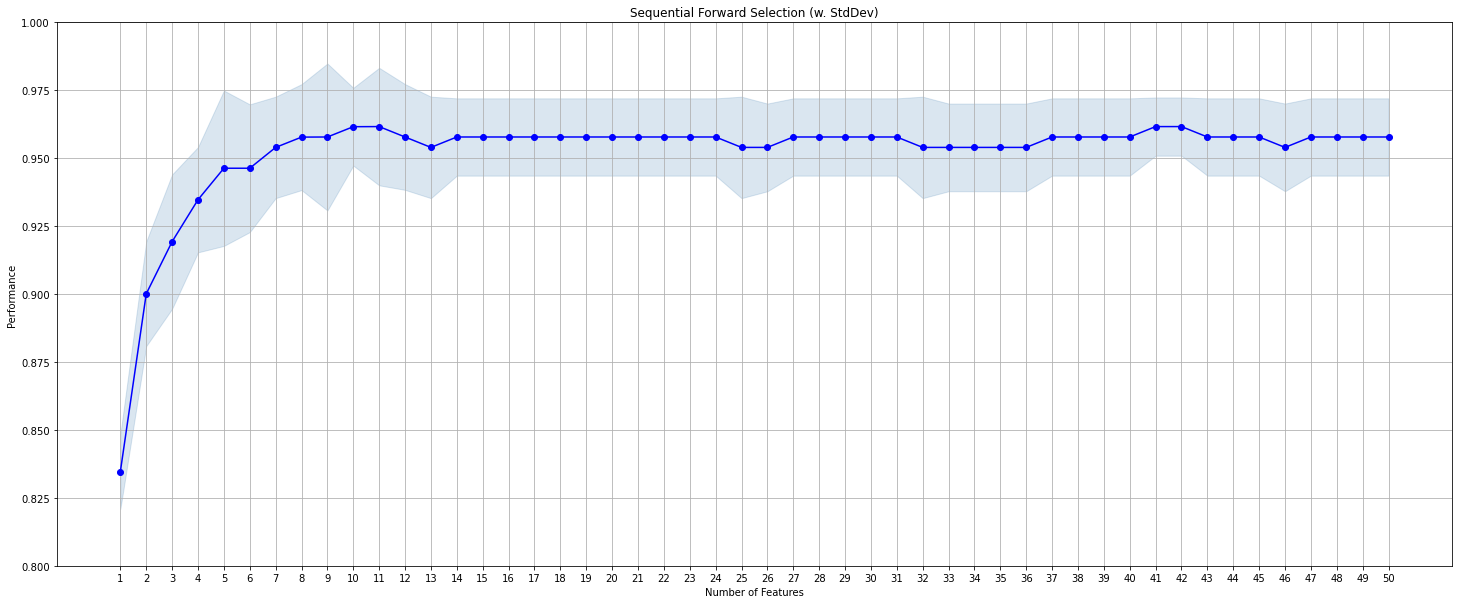

In [150]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs2.get_metric_dict(), kind='std_dev',figsize=(25,10))

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

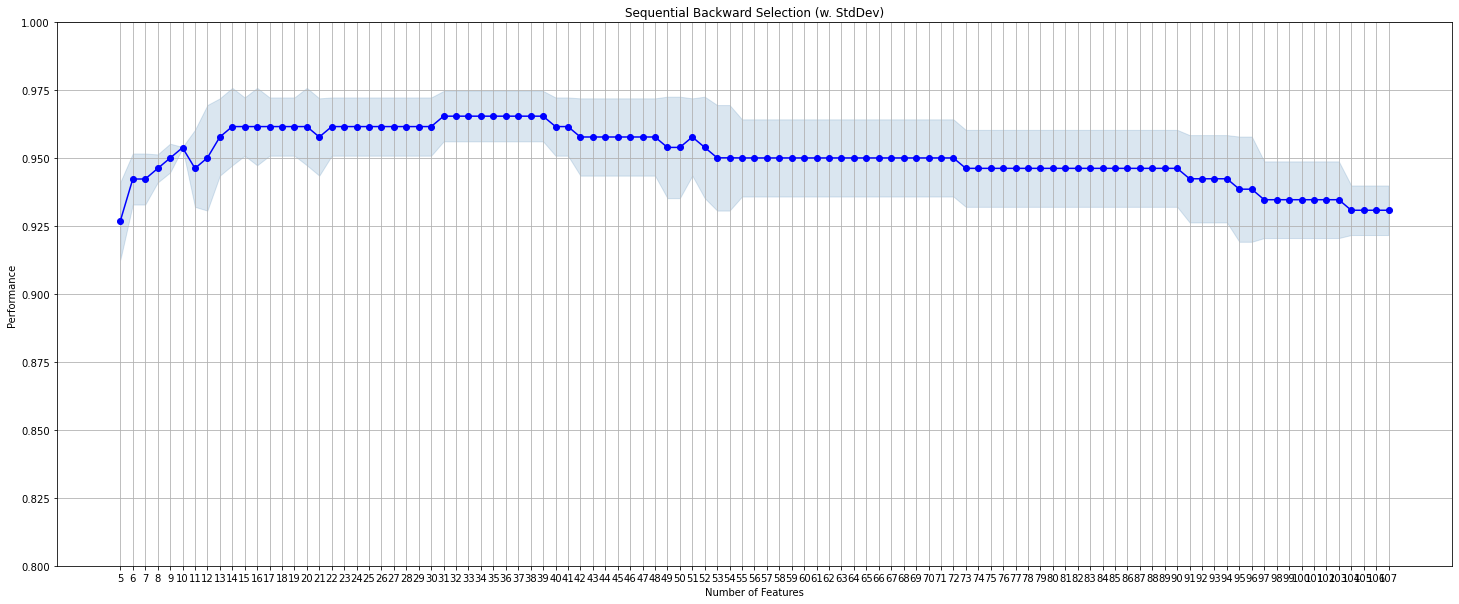

In [151]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


# fig1=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plot_sfs(sbs2.get_metric_dict(), kind='std_dev',figsize=(25,10))

plt.ylim([0.8, 1])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()


##### 03 - SMOTEENN Results

In [152]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

scaler=StandardScaler()
X_train3_scale=scaler.fit_transform(X_train3)
X = pd.DataFrame(X_train3_scale,columns=X_train3.columns)
y = y_train3
knn = KNeighborsClassifier(n_neighbors=2)


# Sequential Forward Selection
start = timeit.default_timer()
sfs3 = sfs(knn, 
          k_features=50, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sfs3 = sfs3.fit(X, y)
stop = timeit.default_timer()
sfs_time_3=stop-start

print("Time: ", sfs_time_3)
print('\nSequential Forward Selection (k=3):')
print(sfs3.k_feature_idx_)
print('CV Score:')
print(sfs3.k_score_)

# ###################################################

# Sequential Backward Selection
start = timeit.default_timer()
sbs3 = sfs(knn, 
          k_features=5, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sbs3 = sbs3.fit(X, y)
stop = timeit.default_timer()
sbs_time_3=stop-start

print("Time: ", sbs_time_3)
print('\nSequential Backward Selection (k=3):')
print(sbs3.k_feature_idx_)
print('CV Score:')
print(sbs3.k_score_)

###################################################


Time:  76.54500299999927

Sequential Forward Selection (k=3):
(0, 1, 2, 3, 4, 6, 12, 13, 14, 29, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 56, 57, 58, 59, 68, 69, 70, 71, 72, 73, 74, 75, 77, 79, 80, 81, 82, 83, 84, 85, 94, 97, 98, 99, 100, 104)
CV Score:
0.9771055301877221
Time:  111.51134760000423

Sequential Backward Selection (k=3):
(9, 56, 71, 85, 98)
CV Score:
0.954211060375444


In [153]:
pd.DataFrame.from_dict(sfs3.get_metric_dict()).T

feature_idx  \
1                                               (44,)   
2                                           (44, 100)   
3                                       (44, 75, 100)   
4                                   (44, 72, 75, 100)   
5                               (44, 72, 75, 82, 100)   
6                            (0, 44, 72, 75, 82, 100)   
7                        (0, 44, 71, 72, 75, 82, 100)   
8                    (0, 44, 71, 72, 75, 77, 82, 100)   
9                (0, 44, 69, 71, 72, 75, 77, 82, 100)   
10           (0, 44, 52, 69, 71, 72, 75, 77, 82, 100)   
11      (0, 44, 52, 69, 71, 72, 75, 77, 82, 100, 104)   
12  (0, 44, 52, 58, 69, 71, 72, 75, 77, 82, 100, 104)   
13  (0, 42, 44, 52, 58, 69, 71, 72, 75, 77, 82, 10...   
14  (0, 13, 42, 44, 52, 58, 69, 71, 72, 75, 77, 82...   
15  (0, 13, 42, 44, 52, 58, 69, 71, 72, 75, 77, 82...   
16  (0, 13, 42, 44, 52, 58, 69, 70, 71, 72, 75, 77...   
17  (0, 13, 42, 44, 52, 58, 68, 69, 70, 71, 72, 75...   
18  (0, 13, 42, 44, 52, 58, 68, 69, 70, 71, 72, 75...   
19  (0, 3, 13, 42, 44, 52, 58, 68, 69, 70, 71, 72,...   
20  (0, 3, 12, 13, 42, 44, 52, 58, 68, 69, 70, 71,...   
21  (0, 3, 4, 12, 13, 42, 44, 52, 58, 68, 69, 70, ...   
22  (0, 3, 4, 6, 12, 13, 42, 44, 52, 58, 68, 69, 7...   
23  (0, 3, 4, 6, 12, 13, 42, 44, 52, 58, 68, 69, 7...   
24  (0, 3, 4, 6, 12, 13, 42, 44, 52, 58, 68, 69, 7...   
25  (0, 3, 4, 6, 12, 13, 42, 44, 52, 58, 68, 69, 7...   
26  (0, 3, 4, 6, 12, 13, 42, 44, 45, 52, 58, 68, 6...   
27  (0, 3, 4, 6, 12, 13, 42, 44, 45, 52, 58, 68, 6...   
28  (0, 3, 4, 6, 12, 13, 40, 42, 44, 45, 52, 58, 6...   
29  (0, 3, 4, 6, 12, 13, 40, 42, 44, 45, 52, 58, 6...   
30  (0, 3, 4, 6, 12, 13, 40, 42, 43, 44, 45, 52, 5...   
31  (0, 3, 4, 6, 12, 13, 40, 42, 43, 44, 45, 52, 5...   
32  (0, 3, 4, 6, 12, 13, 40, 41, 42, 43, 44, 45, 5...   
33  (0, 3, 4, 6, 12, 13, 40, 41, 42, 43, 44, 45, 4...   
34  (0, 3, 4, 6, 12, 13, 40, 41, 42, 43, 44, 45, 4...   
35  (0, 3, 4, 6, 12, 13, 29, 40, 41, 42, 43, 44, 4...   
36  (0, 3, 4, 6, 12, 13, 29, 38, 40, 41, 42, 43, 4...   
37  (0, 1, 3, 4, 6, 12, 13, 29, 38, 40, 41, 42, 43...   
38  (0, 1, 3, 4, 6, 12, 13, 14, 29, 38, 40, 41, 42...   
39  (0, 1, 3, 4, 6, 12, 13, 14, 29, 38, 40, 41, 42...   
40  (0, 1, 3, 4, 6, 12, 13, 14, 29, 38, 40, 41, 42...   
41  (0, 1, 3, 4, 6, 12, 13, 14, 29, 38, 40, 41, 42...   
42  (0, 1, 3, 4, 6, 12, 13, 14, 29, 38, 40, 41, 42...   
43  (0, 1, 3, 4, 6, 12, 13, 14, 29, 38, 40, 41, 42...   
44  (0, 1, 3, 4, 6, 12, 13, 14, 29, 38, 40, 41, 42...   
45  (0, 1, 3, 4, 6, 12, 13, 14, 29, 38, 40, 41, 42...   
46  (0, 1, 3, 4, 6, 12, 13, 14, 29, 38, 39, 40, 41...   
47  (0, 1, 2, 3, 4, 6, 12, 13, 14, 29, 38, 39, 40,...   
48  (0, 1, 2, 3, 4, 6, 12, 13, 14, 29, 38, 39, 40,...   
49  (0, 1, 2, 3, 4, 6, 12, 13, 14, 29, 38, 39, 40,...   
50  (0, 1, 2, 3, 4, 6, 12, 13, 14, 29, 38, 39, 40,...   

                                            cv_scores avg_score  \
1   [0.8904109589041096, 0.8082191780821918, 0.861...  0.853247   
2   [0.8767123287671232, 0.9041095890410958, 0.930...  0.903792   
3   [0.958904109589041, 0.9452054794520548, 0.9305...  0.944888   
4   [0.958904109589041, 0.958904109589041, 0.95833...  0.958714   
5   [0.9863013698630136, 0.958904109589041, 0.9583...  0.967846   
6   [0.958904109589041, 0.9726027397260274, 0.9861...  0.972539   
7        [0.958904109589041, 0.9863013698630136, 1.0]  0.981735   
8       [0.9863013698630136, 0.9863013698630136, 1.0]  0.990868   
9       [0.9863013698630136, 0.9863013698630136, 1.0]  0.990868   
10      [0.9863013698630136, 0.9726027397260274, 1.0]  0.986301   
11  [0.9863013698630136, 0.9863013698630136, 0.986...  0.986238   
12  [0.9863013698630136, 0.9726027397260274, 0.986...  0.981672   
13      [0.9726027397260274, 0.9726027397260274, 1.0]  0.981735   
14       [0.9863013698630136, 0.958904109589041, 1.0]  0.981735   
15      [0.9863013698630136, 0.9726027397260274, 1.0]  0.986301   
16                     [1.0, 0.9726027397260274, 1.0]  0.99086

In [154]:
pd.DataFrame.from_dict(sbs3.get_metric_dict()).T

feature_idx  \
107  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
106  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
105  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
104  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
103  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
..                                                 ...   
9                    (1, 4, 7, 9, 56, 71, 85, 98, 103)   
8                       (1, 4, 9, 56, 71, 85, 98, 103)   
7                          (4, 9, 56, 71, 85, 98, 103)   
6                               (4, 9, 56, 71, 85, 98)   
5                                  (9, 56, 71, 85, 98)   

                                             cv_scores avg_score  \
107  [0.9452054794520548, 0.9315068493150684, 0.944...  0.940386   
106  [0.9452054794520548, 0.9315068493150684, 0.958...  0.945015   
105  [0.9452054794520548, 0.9452054794520548, 0.958...  0.949581   
104  [0.9452054794520548, 0.9452054794520548, 0.958...  0.949581   
103  [0.9452054794520548, 0.9452054794520548, 0.958...  0.949581   
..                                                 ...       ...   
9    [0.9726027397260274, 0.9863013698630136, 0.972...  0.977042   
8    [0.958904109589041, 0.9863013698630136, 0.9722...  0.972476   
7    [0.9863013698630136, 0.9726027397260274, 0.972...  0.977042   
6    [0.9726027397260274, 0.958904109589041, 0.9722...   0.96791   
5    [0.958904109589041, 0.9315068493150684, 0.9722...  0.954211   

                                         feature_names  ci_bound   std_dev  \
107  (fa226, fa257, fa280, fa297, fa324, fa343, fa3...  0.014145  0.006286   
106  (fa226, fa257, fa280, fa297, fa324, fa343, fa3...  0.024647  0.010953   
105  (fa226, fa257, fa280, fa297, fa324, fa343, fa3...  0.013926  0.006189   
104  (fa226, fa257, fa280, fa297, fa324, fa343, fa3...  0.013926  0.006189   
103  (fa226, fa257, fa280, fa297, fa324, fa343, fa3...  0.013926  0.006189   
..                                                 ...       ...       ...   
9    (fa257, fa324, fa385, fa432, fa1887, fa2911, f...  0.014738  0.006549   
8    (fa257, fa324, fa432, fa1887, fa2911, fa4362, ...  0.025173  0.011186   
7    (fa324, fa432, fa1887, fa2911, fa4362, fa6349,...  0.014738  0.006549   
6       (fa324, fa432, fa1887, fa2911, fa4362, fa6349)  0.014334   0.00637   
5              (fa432, fa1887, fa2911, fa4362, fa6349)  0.038143   0.01695   

      std_err  
107  0.004445  
106  0.007745  
105  0.004376  
104  0.004376  
103  0.004376  
..        ...  
9    0.004631  
8     0.00791  
7    0.004631  
6    0.004504  
5    0.011985  

[103 rows x 7 columns]

In [155]:
sfs_score_3=pd.DataFrame.from_dict(sfs3.get_metric_dict()).T.avg_score
max_sfs_score_3 =max(sfs_score_3)
max_sfs_score_3
max_sfs_index_3 = min(sfs_score_3.index[sfs_score_3.values==max_sfs_score_3])
max_sfs_index_3

8

In [156]:
sfs_feat_3=[sfs3.feature_names[i] for i in np.asarray(sfs3.k_feature_idx_[0:max_sfs_index_3+1])]
sfs_feat_3

['fa226',
 'fa257',
 'fa280',
 'fa297',
 'fa324',
 'fa363',
 'fa500',
 'fa514',
 'fa545']

In [157]:
sbs_score_3=pd.DataFrame.from_dict(sbs3.get_metric_dict()).T.avg_score
max_sbs_score_3 =max(sbs_score_3)
max_sbs_score_3
max_sbs_index_3 = min(sbs_score_3.index[sbs_score_3.values==max_sbs_score_3])
max_sbs_index_3

7

In [158]:
sbs_feat_3=np.array(pd.DataFrame.from_dict(sbs3.get_metric_dict()).T.iloc[len(sbs3.feature_names)-7].feature_names)
sbs_feat_3

array(['fa324', 'fa432', 'fa1887', 'fa2911', 'fa4362', 'fa6349', 'fa7336'],
      dtype='<U6')

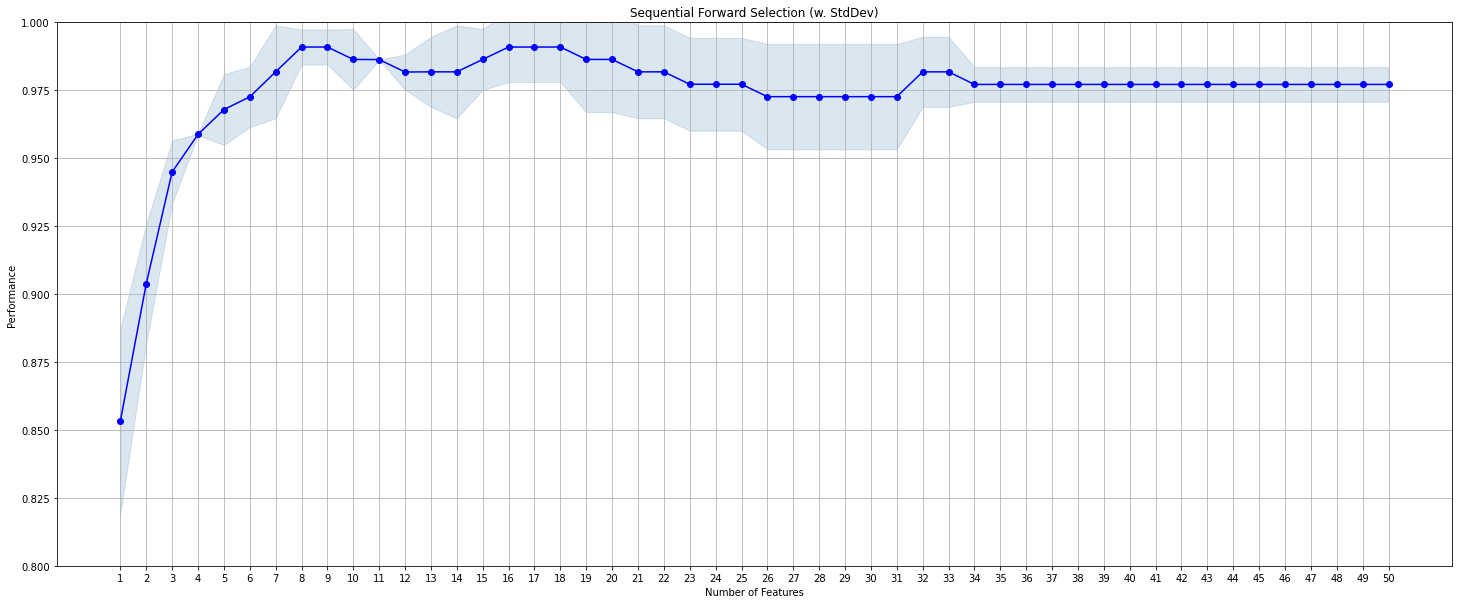

In [159]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs3.get_metric_dict(), kind='std_dev',figsize=(25,10))

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

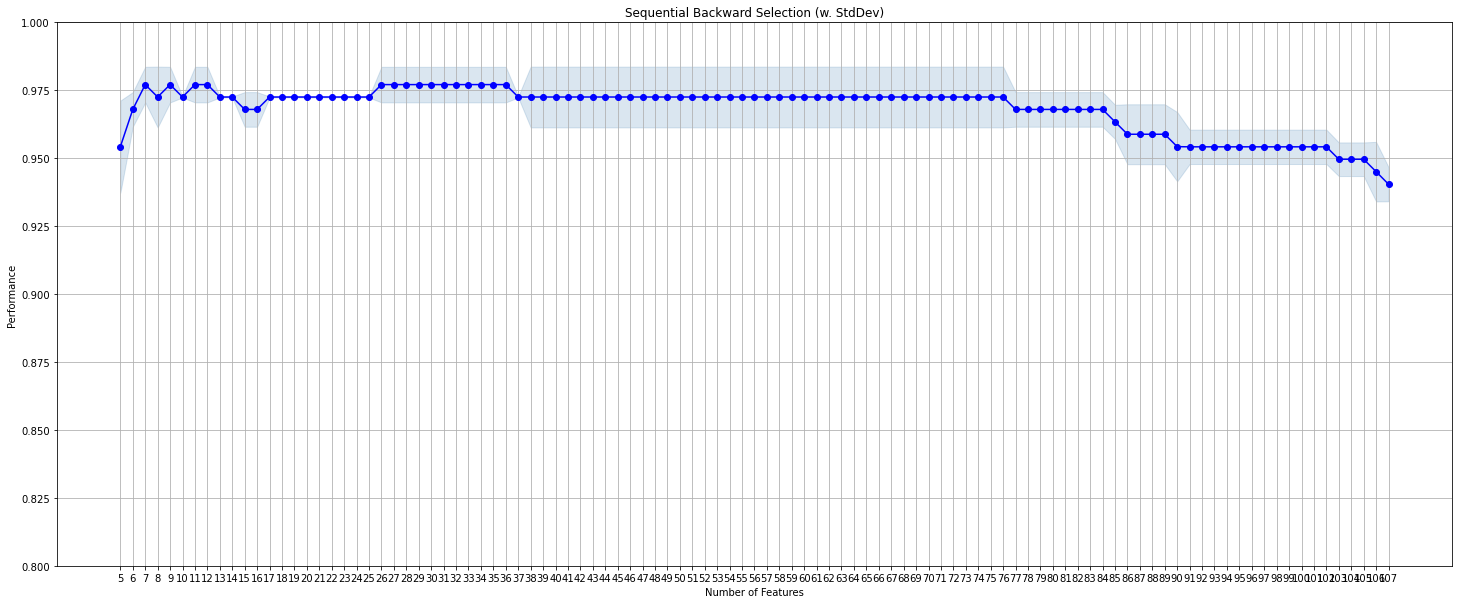

In [160]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


# fig1=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plot_sfs(sbs3.get_metric_dict(), kind='std_dev',figsize=(25,10))

plt.ylim([0.8, 1])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()


##### 04 - SMOTETomek Results

In [161]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

scaler=StandardScaler()
X_train4_scale=scaler.fit_transform(X_train4)
X = pd.DataFrame(X_train4_scale,columns=X_train4.columns)
y = y_train4
knn = KNeighborsClassifier(n_neighbors=2)


# Sequential Forward Selection
start = timeit.default_timer()
sfs4 = sfs(knn, 
          k_features=50, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sfs4 = sfs4.fit(X, y)
stop = timeit.default_timer()
sfs_time_4=stop-start

print("Time: ", sfs_time_4)
print('\nSequential Forward Selection (k=2):')
print(sfs4.k_feature_idx_)
print('CV Score:')
print(sfs4.k_score_)

###################################################

# Sequential Backward Selection
start = timeit.default_timer()
sbs4 = sfs(knn, 
          k_features=5, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sbs4 = sbs4.fit(X, y)
stop = timeit.default_timer()
sbs_time_4=stop-start

print("Time: ", sbs_time_4)
print('\nSequential Backward Selection (k=2):')
print(sbs4.k_feature_idx_)
print('CV Score:')
print(sbs4.k_score_)

###################################################


Time:  92.00818910000089

Sequential Forward Selection (k=2):
(0, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 16, 18, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 55, 59, 60, 61, 62, 66, 84, 101)
CV Score:
0.9606909430438842
Time:  139.27639920000365

Sequential Backward Selection (k=2):
(8, 40, 73, 85, 102)
CV Score:
0.9370214752567693


In [172]:
pd.DataFrame.from_dict(sfs4.get_metric_dict()).T

feature_idx  \
1                                               (34,)   
2                                             (0, 34)   
3                                         (0, 34, 66)   
4                                     (0, 34, 47, 66)   
5                                 (0, 29, 34, 47, 66)   
6                             (0, 29, 34, 35, 47, 66)   
7                         (0, 29, 34, 35, 36, 47, 66)   
8                     (0, 29, 30, 34, 35, 36, 47, 66)   
9                 (0, 29, 30, 34, 35, 36, 47, 48, 66)   
10            (0, 29, 30, 31, 34, 35, 36, 47, 48, 66)   
11        (0, 29, 30, 31, 32, 34, 35, 36, 47, 48, 66)   
12     (0, 2, 29, 30, 31, 32, 34, 35, 36, 47, 48, 66)   
13  (0, 2, 29, 30, 31, 32, 34, 35, 36, 47, 48, 61,...   
14  (0, 2, 29, 30, 31, 32, 33, 34, 35, 36, 47, 48,...   
15  (0, 2, 26, 29, 30, 31, 32, 33, 34, 35, 36, 47,...   
16  (0, 2, 26, 29, 30, 31, 32, 33, 34, 35, 36, 47,...   
17  (0, 2, 26, 29, 30, 31, 32, 33, 34, 35, 36, 47,...   
18  (0, 2, 13, 26, 29, 30, 31, 32, 33, 34, 35, 36,...   
19  (0, 2, 13, 26, 29, 30, 31, 32, 33, 34, 35, 36,...   
20  (0, 2, 13, 26, 29, 30, 31, 32, 33, 34, 35, 36,...   
21  (0, 2, 13, 16, 26, 29, 30, 31, 32, 33, 34, 35,...   
22  (0, 2, 5, 13, 16, 26, 29, 30, 31, 32, 33, 34, ...   
23  (0, 2, 5, 6, 13, 16, 26, 29, 30, 31, 32, 33, 3...   
24  (0, 2, 5, 6, 13, 16, 26, 28, 29, 30, 31, 32, 3...   
25  (0, 2, 5, 6, 13, 16, 26, 28, 29, 30, 31, 32, 3...   
26  (0, 2, 3, 5, 6, 13, 16, 26, 28, 29, 30, 31, 32...   
27  (0, 2, 3, 5, 6, 13, 16, 26, 28, 29, 30, 31, 32...   
28  (0, 2, 3, 5, 6, 13, 16, 26, 28, 29, 30, 31, 32...   
29  (0, 2, 3, 5, 6, 13, 16, 26, 28, 29, 30, 31, 32...   
30  (0, 2, 3, 5, 6, 13, 16, 23, 26, 28, 29, 30, 31...   
31  (0, 2, 3, 5, 6, 13, 16, 23, 26, 28, 29, 30, 31...   
32  (0, 2, 3, 5, 6, 13, 16, 23, 26, 28, 29, 30, 31...   
33  (0, 2, 3, 4, 5, 6, 13, 16, 23, 26, 28, 29, 30,...   
34  (0, 2, 3, 4, 5, 6, 13, 16, 23, 25, 26, 28, 29,...   
35  (0, 2, 3, 4, 5, 6, 13, 16, 23, 25, 26, 28, 29,...   
36  (0, 2, 3, 4, 5, 6, 11, 13, 16, 23, 25, 26, 28,...   
37  (0, 2, 3, 4, 5, 6, 11, 12, 13, 16, 23, 25, 26,...   
38  (0, 2, 3, 4, 5, 6, 11, 12, 13, 16, 23, 25, 26,...   
39  (0, 2, 3, 4, 5, 6, 11, 12, 13, 14, 16, 23, 25,...   
40  (0, 2, 3, 4, 5, 6, 11, 12, 13, 14, 16, 23, 25,...   
41  (0, 2, 3, 4, 5, 6, 11, 12, 13, 14, 16, 23, 24,...   
42  (0, 2, 3, 4, 5, 6, 11, 12, 13, 14, 16, 23, 24,...   
43  (0, 2, 3, 4, 5, 6, 11, 12, 13, 14, 16, 23, 24,...   
44  (0, 2, 3, 4, 5, 6, 11, 12, 13, 14, 16, 23, 24,...   
45  (0, 2, 3, 4, 5, 6, 11, 12, 13, 14, 16, 23, 24,...   
46  (0, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 16, 23,...   
47  (0, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 16, 20,...   
48  (0, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 16, 20,...   
49  (0, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 16, ...   
50  (0, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 16, ...   

                                            cv_scores avg_score  \
1   [0.8470588235294118, 0.8235294117647058, 0.869...  0.846545   
2   [0.8823529411764706, 0.9176470588235294, 0.916...  0.905556   
3   [0.9294117647058824, 0.9294117647058824, 0.952...  0.937068   
4   [0.9176470588235294, 0.9411764705882353, 0.964...  0.941036   
5   [0.9411764705882353, 0.9647058823529412, 0.952...  0.952754   
6   [0.9294117647058824, 0.9647058823529412, 0.964...  0.952801   
7   [0.9294117647058824, 0.9529411764705882, 0.976...  0.952848   
8   [0.9294117647058824, 0.9411764705882353, 0.976...  0.948926   
9   [0.9411764705882353, 0.9529411764705882, 0.964...  0.952801   
10  [0.9411764705882353, 0.9529411764705882, 0.964...  0.952801   
11  [0.9294117647058824, 0.9529411764705882, 0.976...  0.952848   
12  [0.9294117647058824, 0.9529411764705882, 0.976...  0.952848   
13  [0.9529411764705882, 0.9529411764705882, 0.964...  0.956723   
14  [0.9529411764705882, 0.9647058823529412, 0.952...  0.956676   
15  [0.9529411764705882, 0.9529411764705882, 0.964...  0.956723   
16  [0.9411764705882353, 0.9411764705882353, 0.976...  0.95284

In [173]:
pd.DataFrame.from_dict(sbs4.get_metric_dict()).T

feature_idx  \
107  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
106  (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
105  (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
104  (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
103  (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
..                                                 ...   
9                  (3, 8, 39, 40, 55, 62, 73, 85, 102)   
8                      (3, 8, 40, 55, 62, 73, 85, 102)   
7                         (8, 40, 55, 62, 73, 85, 102)   
6                             (8, 40, 62, 73, 85, 102)   
5                                 (8, 40, 73, 85, 102)   

                                             cv_scores avg_score  \
107  [0.9176470588235294, 0.9294117647058824, 0.952...  0.933147   
106  [0.9294117647058824, 0.9294117647058824, 0.952...  0.937068   
105  [0.9411764705882353, 0.9294117647058824, 0.952...   0.94099   
104  [0.9411764705882353, 0.9294117647058824, 0.952...   0.94099   
103  [0.9411764705882353, 0.9294117647058824, 0.952...   0.94099   
..                                                 ...       ...   
9    [0.9176470588235294, 0.9647058823529412, 0.976...  0.952848   
8    [0.9411764705882353, 0.9529411764705882, 0.976...  0.956769   
7    [0.9529411764705882, 0.9647058823529412, 0.964...  0.960644   
6    [0.9529411764705882, 0.9647058823529412, 0.952...  0.956676   
5    [0.9294117647058824, 0.9411764705882353, 0.940...  0.937021   

                                         feature_names  ci_bound   std_dev  \
107  (fa226, fa257, fa280, fa297, fa324, fa343, fa3...  0.032458  0.014424   
106  (fa226, fa280, fa297, fa324, fa343, fa363, fa3...  0.024366  0.010828   
105  (fa226, fa280, fa297, fa324, fa343, fa363, fa3...  0.021104  0.009378   
104  (fa226, fa280, fa297, fa324, fa343, fa363, fa3...  0.021104  0.009378   
103  (fa226, fa280, fa297, fa324, fa343, fa363, fa3...  0.021104  0.009378   
..                                                 ...       ...       ...   
9    (fa297, fa408, fa1155, fa1189, fa1834, fa2244,...  0.056997  0.025328   
8    (fa297, fa408, fa1189, fa1834, fa2244, fa3084,...  0.032739  0.014548   
7    (fa408, fa1189, fa1834, fa2244, fa3084, fa4362...  0.012263   0.00545   
6      (fa408, fa1189, fa2244, fa3084, fa4362, fa7127)  0.012788  0.005683   
5              (fa408, fa1189, fa3084, fa4362, fa7127)  0.012126  0.005388   

      std_err  
107  0.010199  
106  0.007656  
105  0.006631  
104  0.006631  
103  0.006631  
..        ...  
9     0.01791  
8    0.010287  
7    0.003853  
6    0.004018  
5     0.00381  

[103 rows x 7 columns]

In [174]:
sfs_score_4=pd.DataFrame.from_dict(sfs4.get_metric_dict()).T.avg_score
max_sfs_score_4 =max(sfs_score_4)
max_sfs_index_4 = min(sfs_score_4.index[sfs_score_4.values==max_sfs_score_4])
sfs_feat_4=[sfs4.feature_names[i] for i in np.asarray(sfs4.k_feature_idx_[0:max_sfs_index_4+1])]
sfs_feat_4

['fa226',
 'fa280',
 'fa297',
 'fa324',
 'fa343',
 'fa363',
 'fa408',
 'fa458',
 'fa471',
 'fa500',
 'fa514',
 'fa545',
 'fa577',
 'fa629',
 'fa667',
 'fa686',
 'fa727',
 'fa749',
 'fa771',
 'fa793',
 'fa840',
 'fa865',
 'fa890',
 'fa917',
 'fa943',
 'fa971',
 'fa1000',
 'fa1029',
 'fa1059',
 'fa1090',
 'fa1122',
 'fa1155',
 'fa1189',
 'fa1224',
 'fa1259',
 'fa1296',
 'fa1334',
 'fa1455',
 'fa1498']

In [175]:
sbs_score_4=pd.DataFrame.from_dict(sbs4.get_metric_dict()).T.avg_score
max_sbs_score_4 =max(sbs_score_4)
max_sbs_score_4
max_sbs_index_4 = min(sbs_score_4.index[sbs_score_4.values==max_sbs_score_4])
max_sbs_index_4

22

In [176]:
pd.DataFrame.from_dict(sbs4.get_metric_dict()).T.iloc[22]

feature_idx      (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
cv_scores        [0.9529411764705882, 0.9411764705882353, 0.964...
avg_score                                                 0.952801
feature_names    (fa226, fa280, fa297, fa324, fa343, fa363, fa3...
ci_bound                                                  0.021231
std_dev                                                   0.009435
std_err                                                   0.006671
Name: 85, dtype: object

In [177]:
sbs4.k_feature_idx_

(8, 40, 73, 85, 102)

In [178]:
sbs_feat_4=[sbs4.feature_names[i] for i in np.asarray(sbs4.k_feature_idx_)]
sbs_feat_4

['fa408', 'fa1189', 'fa3084', 'fa4362', 'fa7127']

In [179]:
sbs4.k_score_

0.9370214752567693

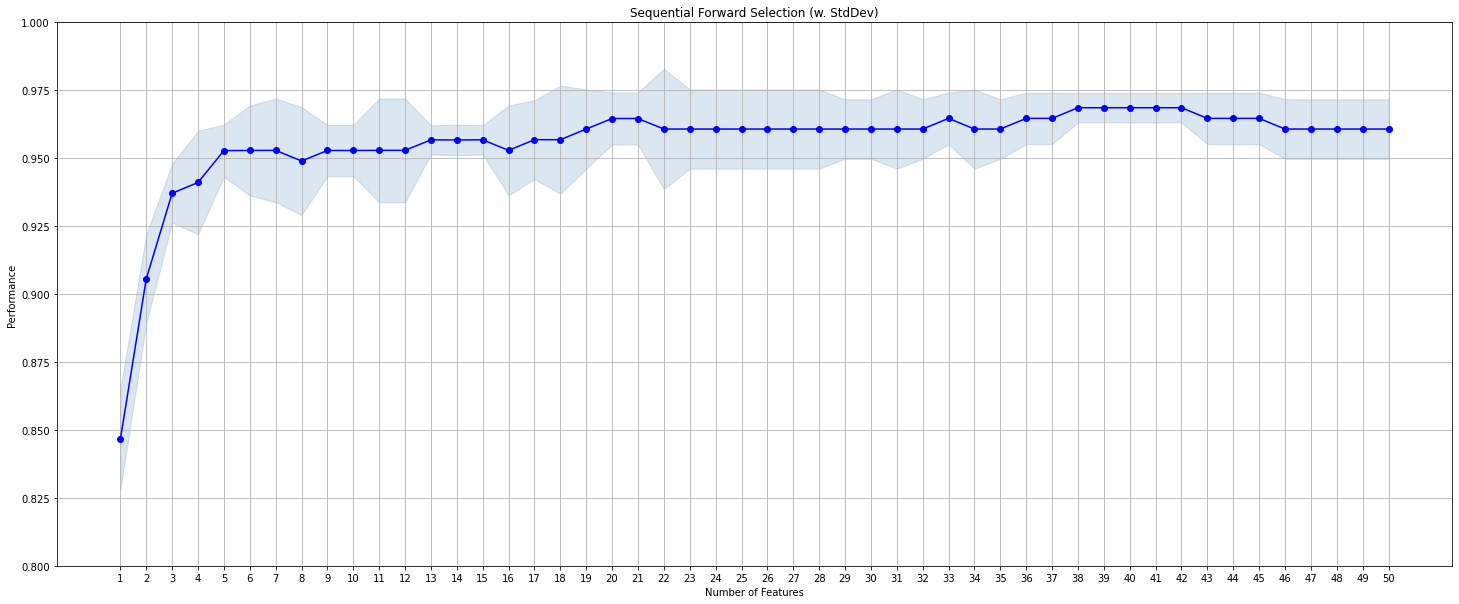

In [170]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs4.get_metric_dict(), kind='std_dev',figsize=(25,10))

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

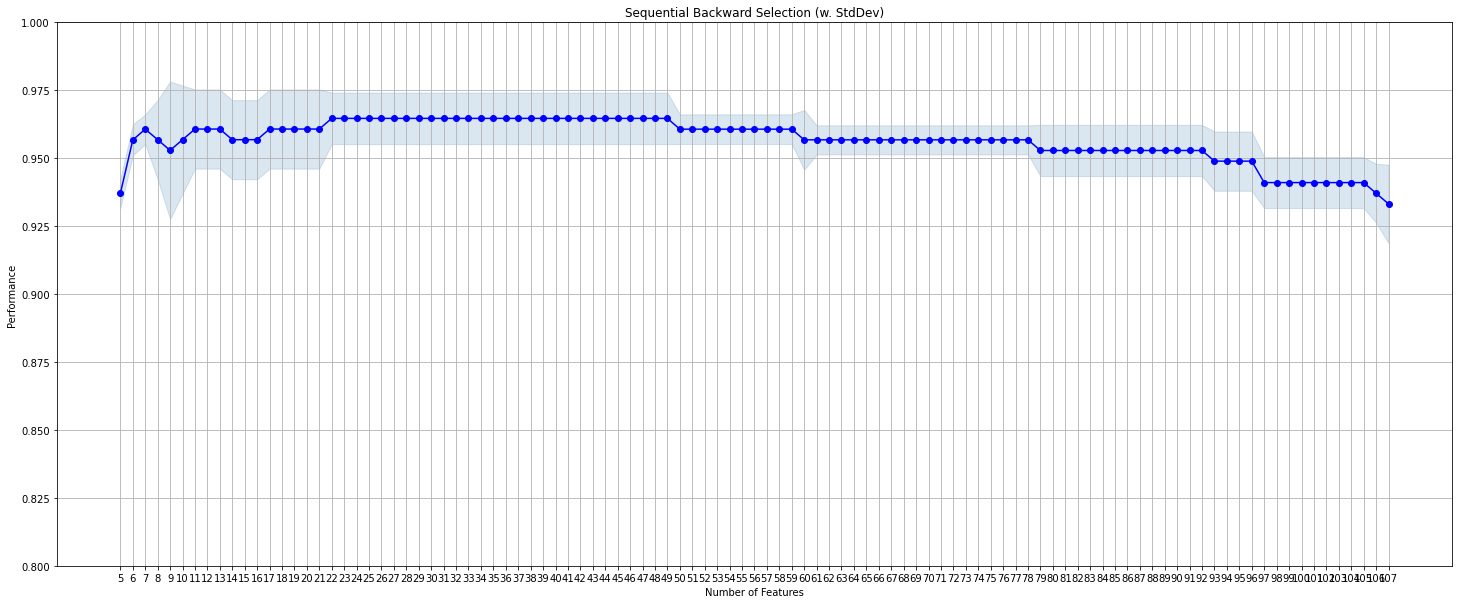

In [171]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


# fig1=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plot_sfs(sbs4.get_metric_dict(), kind='std_dev',figsize=(25,10))

plt.ylim([0.8, 1])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()


### 03 - Embedded Methods

#### 01 - Lasso

In [235]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

##### 00 - Original Results

Time:  52.39548669999931
tuned hyperparameter :(best parameters)  {'C': 0.244205309454865, 'penalty': 'l1'}
accuracy : 0.9341666666666667
total features: 107
selected features: 6
features with coefficients shrank to zero: 101


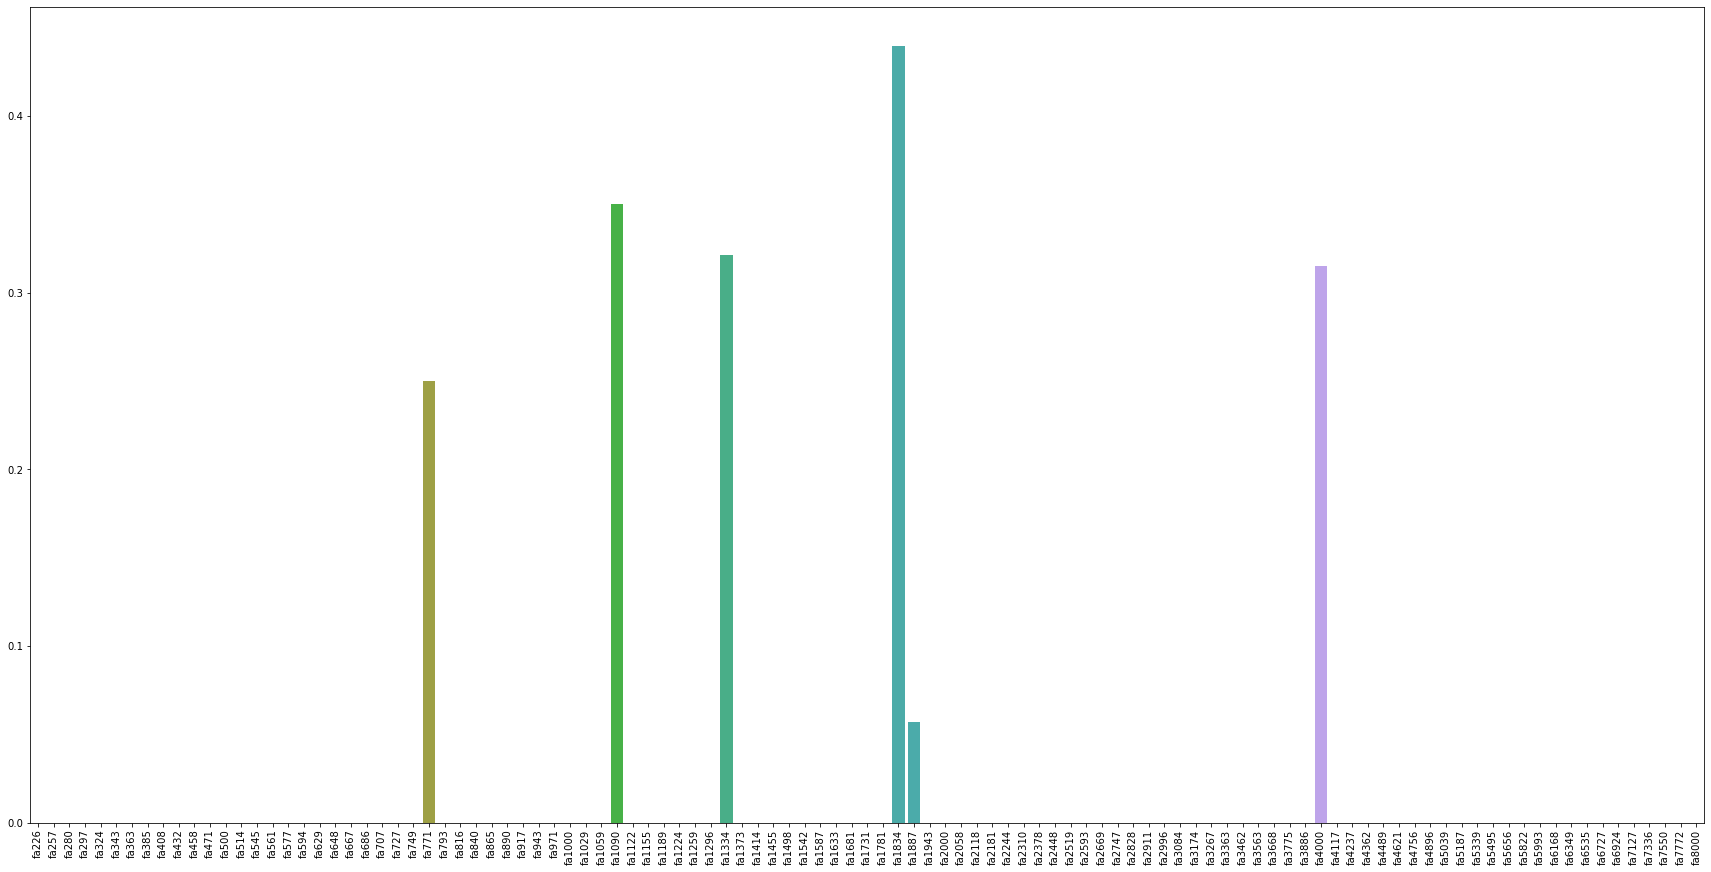

In [236]:
# Grid search cross validation
start = timeit.default_timer()

grid={"C":np.logspace(-6,6,50), "penalty":["l1"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear')
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(scaler.fit_transform(X_train0), y_train0)

best_logC=logreg_cv.best_params_['C']
best_penalty=logreg_cv.best_params_['penalty']

sel_0 = SelectFromModel(LogisticRegression(C=best_logC, penalty=best_penalty, solver='liblinear'))
sel_0.fit(scaler.fit_transform(X_train0), y_train0)
stop = timeit.default_timer()
lr_lasso_time_0=stop-start

print('Time: ',lr_lasso_time_0)
print("tuned hyperparameter :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

X_train0.columns[(sel_0.get_support())]

lasso_feat_0 = X_train0.columns[(sel_0.get_support())]
print('total features: {}'.format((X_train0.shape[1])))
print('selected features: {}'.format(len(lasso_feat_0)))
print('features with coefficients shrank to zero: {}'.format(
np.sum(sel_0.estimator_.coef_ == 0)))

coefs_0=abs(pd.Series(sel_0.estimator_.coef_.flatten(order='C')))
freq_0=pd.Series(X_train0.columns)

freq_importance_0=pd.concat([freq_0,coefs_0],keys=['freq','coef'],axis=1)

plt.figure(figsize=(30, 15))
sb.barplot(data=freq_importance_0,x=freq_0,y=coefs_0)
plt.xticks(rotation=90);

##### 01 - Nearmiss Results

Time:  3.2704018000004
tuned hyperparameter :(best parameters)  {'C': 0.1389495494373136, 'penalty': 'l1'}
accuracy : 0.775
total features: 107
selected features: 4
features with coefficients shrank to zero: 103


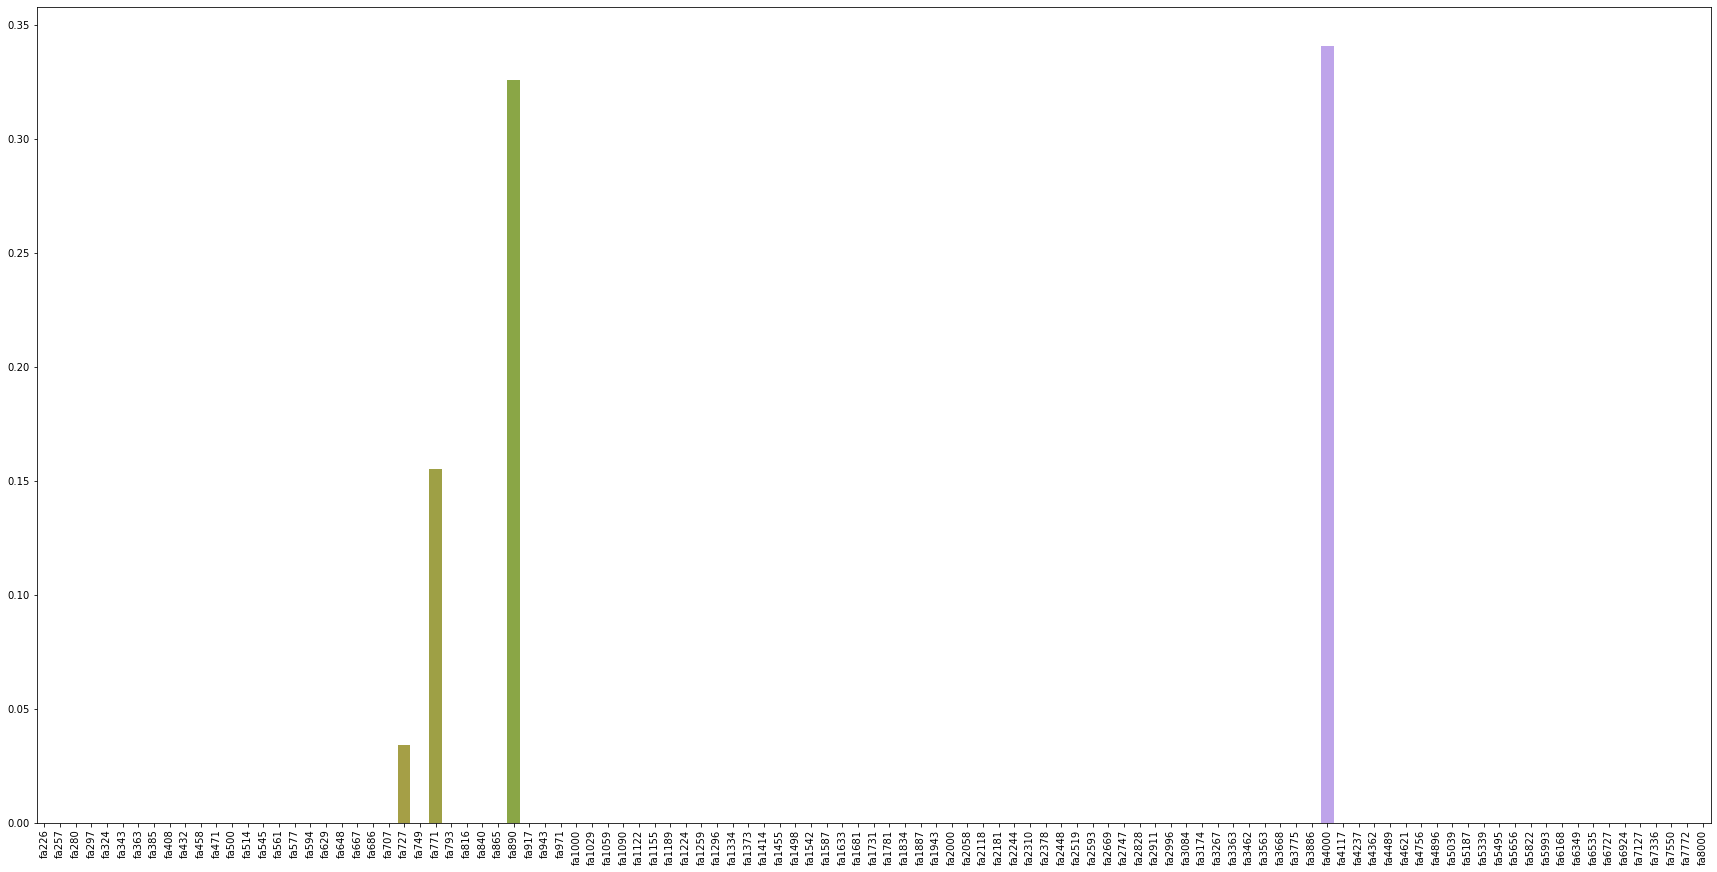

In [237]:
# Grid search cross validation
start = timeit.default_timer()
grid={"C":np.logspace(-6,6,50), "penalty":["l1"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear')
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(scaler.fit_transform(X_train1), y_train1)

best_logC=logreg_cv.best_params_['C']
best_penalty=logreg_cv.best_params_['penalty']

sel_1 = SelectFromModel(LogisticRegression(C=best_logC, penalty=best_penalty, solver='liblinear'))
sel_1.fit(scaler.fit_transform(X_train1), y_train1)
stop = timeit.default_timer()
lr_lasso_time_1=stop-start

print('Time: ',lr_lasso_time_1)
print("tuned hyperparameter :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

X_train1.columns[(sel_1.get_support())]

lasso_feat_1 = X_train1.columns[(sel_1.get_support())]
print('total features: {}'.format((X_train1.shape[1])))
print('selected features: {}'.format(len(lasso_feat_1)))
print('features with coefficients shrank to zero: {}'.format(
np.sum(sel_1.estimator_.coef_ == 0)))

coefs_1=abs(pd.Series(sel_1.estimator_.coef_.flatten(order='C')))
freq_1=pd.Series(X_train1.columns)

freq_importance_1=pd.concat([freq_1,coefs_1],keys=['freq','coef'],axis=1)

plt.figure(figsize=(30, 15))
sb.barplot(data=freq_importance_1,x=freq_1,y=coefs_1)
plt.xticks(rotation=90);

##### 02 - SMOTE Results

Time:  32.437041500001214
tuned hyperparameter :(best parameters)  {'C': 19306.977288832455, 'penalty': 'l1'}
accuracy : 0.95
total features: 107
selected features: 107
features with coefficients shrank to zero: 0


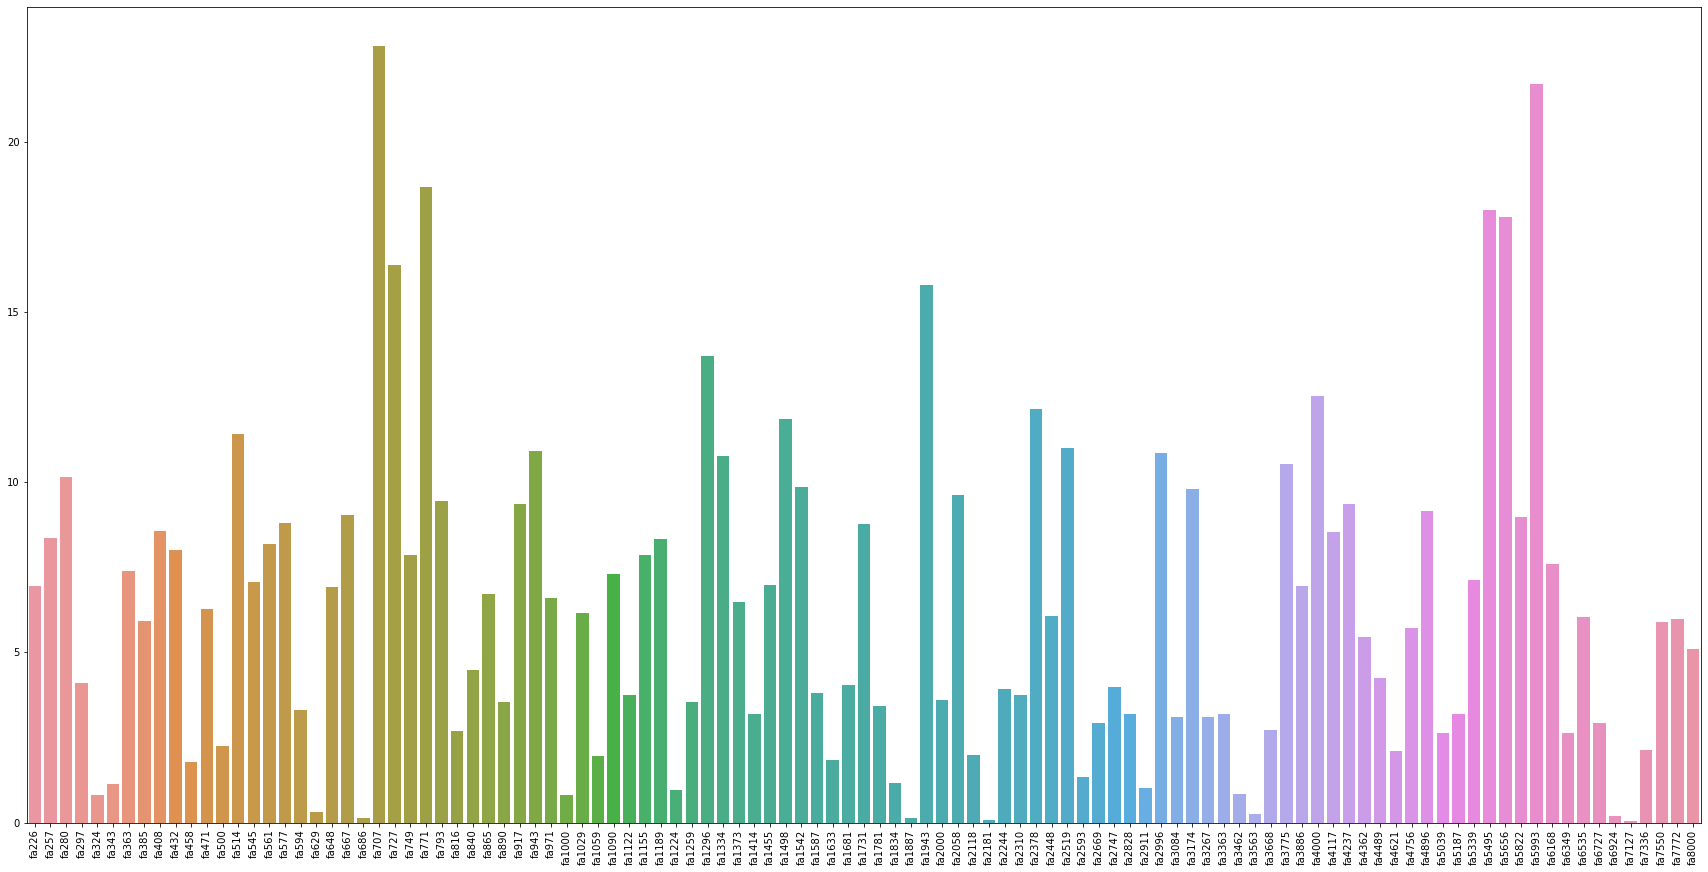

In [238]:
# Grid search cross validation
start = timeit.default_timer()
grid={"C":np.logspace(-6,6,50), "penalty":["l1"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear')
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(scaler.fit_transform(X_train2), y_train2)

best_logC=logreg_cv.best_params_['C']
best_penalty=logreg_cv.best_params_['penalty']

sel_2 = SelectFromModel(LogisticRegression(C=best_logC, penalty=best_penalty, solver='liblinear'))
sel_2.fit(scaler.fit_transform(X_train2), y_train2)
stop = timeit.default_timer()
lr_lasso_time_2=stop-start

print('Time: ',lr_lasso_time_2)
print("tuned hyperparameter :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

X_train2.columns[(sel_2.get_support())]

lasso_feat_2 = X_train2.columns[(sel_2.get_support())]
print('total features: {}'.format((X_train2.shape[1])))
print('selected features: {}'.format(len(lasso_feat_2)))
print('features with coefficients shrank to zero: {}'.format(
np.sum(sel_2.estimator_.coef_ == 0)))


coefs_2=abs(pd.Series(sel_2.estimator_.coef_.flatten(order='C')))
freq_2=pd.Series(X_train2.columns)

freq_importance_2=pd.concat([freq_2,coefs_2],keys=['freq','coef'],axis=1)

plt.figure(figsize=(30, 15))
sb.barplot(data=freq_importance_2,x=freq_2,y=coefs_2)
plt.xticks(rotation=90);

##### 03 - SMOTEENN Results

Time:  16.001614199994947
tuned hyperparameter :(best parameters)  {'C': 22.229964825261955, 'penalty': 'l1'}
accuracy : 0.9541125541125541
total features: 107
selected features: 34
features with coefficients shrank to zero: 73


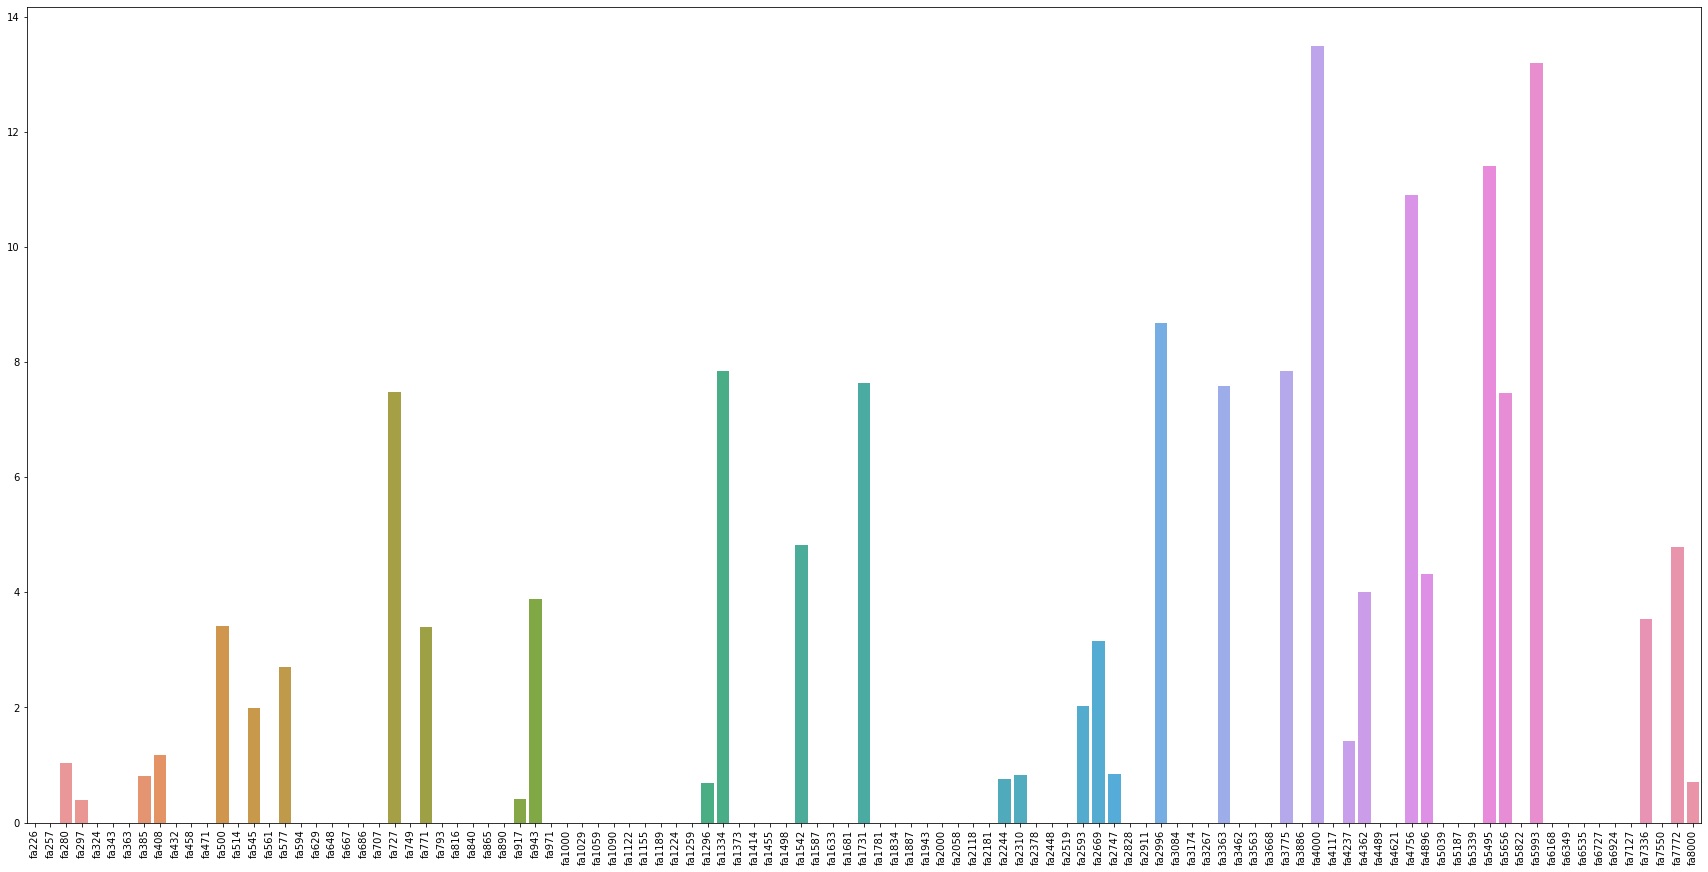

In [239]:
# Grid search cross validation
start = timeit.default_timer()
grid={"C":np.logspace(-6,6,50), "penalty":["l1"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear')
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(scaler.fit_transform(X_train3), y_train3)

best_logC=logreg_cv.best_params_['C']
best_penalty=logreg_cv.best_params_['penalty']

sel_3 = SelectFromModel(LogisticRegression(C=best_logC, penalty=best_penalty, solver='liblinear'))
sel_3.fit(scaler.fit_transform(X_train3), y_train3)
stop = timeit.default_timer()
lr_lasso_time_3=stop-start

print('Time: ',lr_lasso_time_3)
print("tuned hyperparameter :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

X_train3.columns[(sel_3.get_support())]

lasso_feat_3 = X_train3.columns[(sel_3.get_support())]
print('total features: {}'.format((X_train3.shape[1])))
print('selected features: {}'.format(len(lasso_feat_3)))
print('features with coefficients shrank to zero: {}'.format(
np.sum(sel_3.estimator_.coef_ == 0)))


coefs_3=abs(pd.Series(sel_3.estimator_.coef_.flatten(order='C')))
freq_3=pd.Series(X_train3.columns)

freq_importance_3=pd.concat([freq_3,coefs_3],keys=['freq','coef'],axis=1)

plt.figure(figsize=(30, 15))
sb.barplot(data=freq_importance_3,x=freq_3,y=coefs_3)
plt.xticks(rotation=90);

##### 04 - SMOTETomek Results

Time:  22.788272199999483
tuned hyperparameter :(best parameters)  {'C': 22.229964825261955, 'penalty': 'l1'}
accuracy : 0.9372307692307691
total features: 107
selected features: 48
features with coefficients shrank to zero: 59


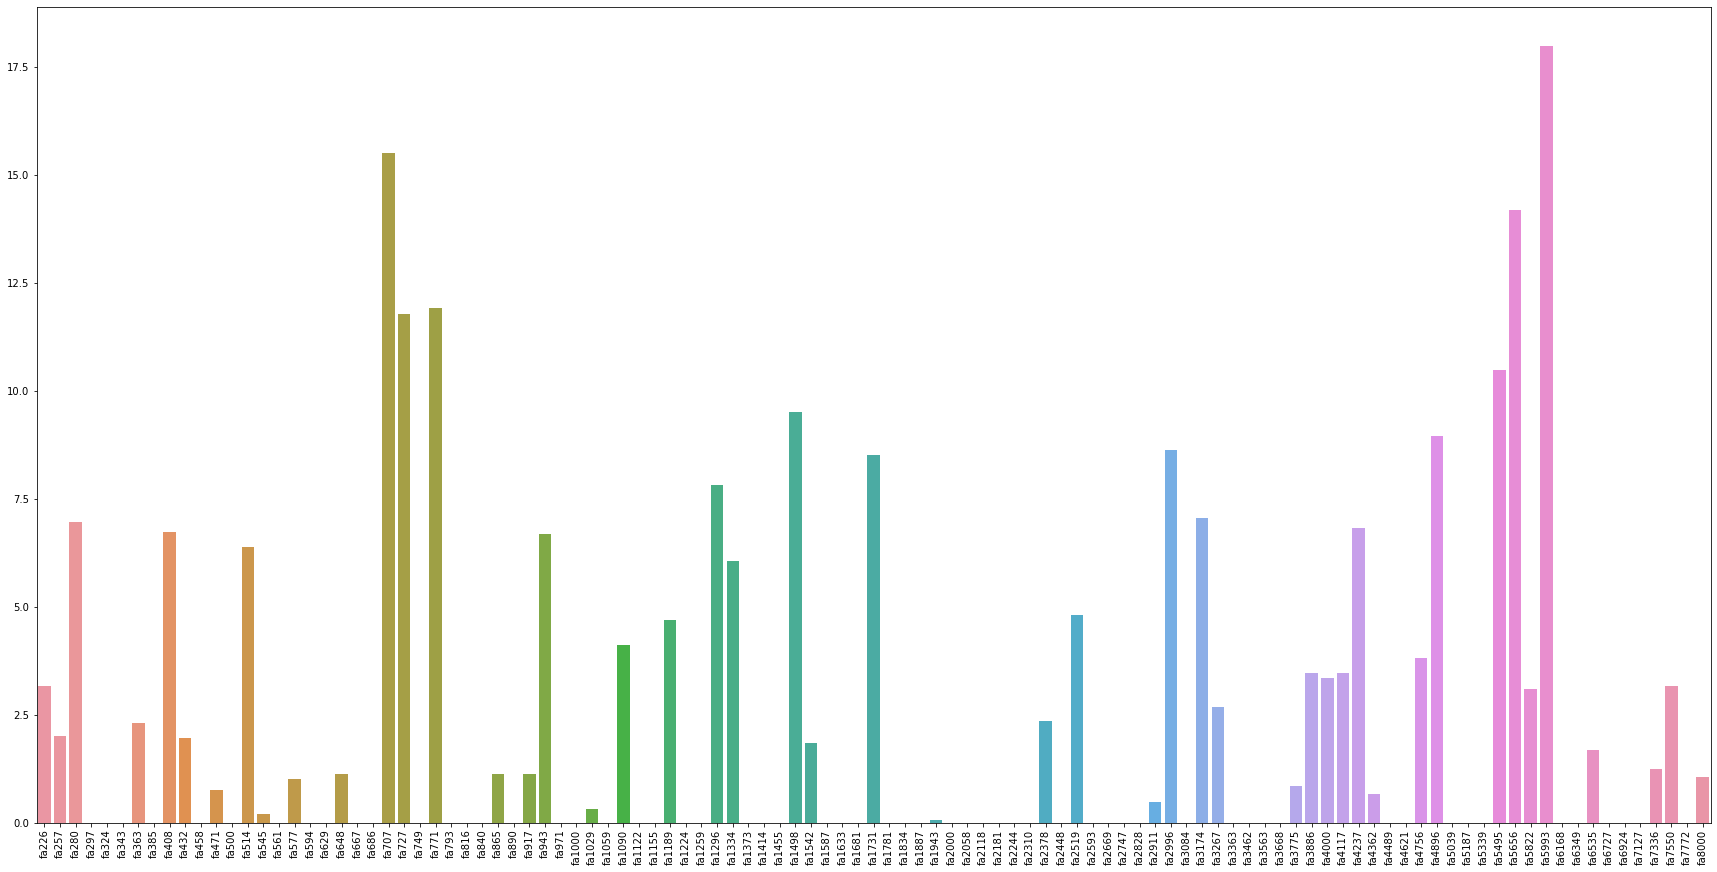

In [240]:
# Grid search cross validation
start = timeit.default_timer()
grid={"C":np.logspace(-6,6,50), "penalty":["l1"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear')
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(scaler.fit_transform(X_train4), y_train4)

best_logC=logreg_cv.best_params_['C']
best_penalty=logreg_cv.best_params_['penalty']

sel_4 = SelectFromModel(LogisticRegression(C=best_logC, penalty=best_penalty, solver='liblinear'))
sel_4.fit(scaler.fit_transform(X_train4), y_train4)
stop = timeit.default_timer()
lr_lasso_time_4=stop-start

print('Time: ',lr_lasso_time_4)
print("tuned hyperparameter :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

X_train4.columns[(sel_4.get_support())]

lasso_feat_4 = X_train4.columns[(sel_4.get_support())]
print('total features: {}'.format((X_train4.shape[1])))
print('selected features: {}'.format(len(lasso_feat_4)))
print('features with coefficients shrank to zero: {}'.format(
np.sum(sel_4.estimator_.coef_ == 0)))


coefs_4=abs(pd.Series(sel_4.estimator_.coef_.flatten(order='C')))
freq_4=pd.Series(X_train4.columns)

freq_importance_4=pd.concat([freq_4,coefs_4],keys=['freq','coef'],axis=1)

plt.figure(figsize=(30, 15))
sb.barplot(data=freq_importance_4,x=freq_4,y=coefs_4)
plt.xticks(rotation=90);

## 6.0 - Classification models

### 00 - Original RFECV SVC

In [180]:
f_train_sv_0=X_train0.loc[:, X_train0.columns.isin(rfe_svc_0)]
f_val_sv_0=X_val0.loc[:, X_val0.columns.isin(rfe_svc_0)]
f_test_sv_0=X_test0.loc[:, X_test0.columns.isin(rfe_svc_0)]

In [334]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_auc_score

pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_sv_0 = pd.DataFrame(pipeline.fit_transform(f_train_sv_0),columns=rfe_svc_0)
X_val_sv_0 = pd.DataFrame(pipeline.transform(f_val_sv_0),columns=rfe_svc_0)
X_test_sv_0 = pd.DataFrame(pipeline.transform(f_test_sv_0),columns=rfe_svc_0)

model = SVC(kernel='linear')
model.fit(X_train_sv_0, y_train0)
y_pred=model.predict(X_test_sv_0)
print(y_pred)

rfe_svc_feat_rank_0=svm_feature_ranking(rfe_svc_0,model.coef_).sort_values('coef',ascending=False)
print(rfe_svc_feat_rank_0)

acc=classification_report(y_test0, y_pred,output_dict=True)['accuracy']
p=classification_report(y_test0, y_pred,output_dict=True)['macro avg']['precision']
r=classification_report(y_test0, y_pred,output_dict=True)['macro avg']['recall']
f1=classification_report(y_test0, y_pred,output_dict=True)['macro avg']['f1-score']
auc=roc_auc_score(y_test0, y_pred)

rfecv_rf_result_0=list([acc,p,r,f1,auc])

print_score(model, X_train_sv_0, y_train0, X_val_sv_0 , y_val0 , X_test_sv_0, y_test0, 'train')
print_score(model, X_train_sv_0, y_train0, X_val_sv_0 , y_val0 , X_test_sv_0, y_test0, 'val')
print_score(model, X_train_sv_0, y_train0, X_val_sv_0 , y_val0 , X_test_sv_0, y_test0, 'test')
print(acc,p,r,f0,auc)

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 0 0 0]
     freq      coef
5  fa1834  0.146155
3  fa1296  0.119106
0   fa749  0.092588
6  fa4000  0.068055
4  fa1334  0.066630
1   fa771  0.022757
2  fa1090  0.004268
Train Result:
Accuracy Score: 93.42%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.941176   0.875000  0.934211    0.908088      0.931598
recall       0.984615   0.636364  0.934211    0.810490      0.934211
f1-score     0.962406   0.736842  0.934211    0.849624      0.929759
support    130.000000  22.000000  0.934211  152.000000    152.000000
_______________________________________________
Confusion Matrix: 
 [[128   2]
 [  8  14]]

Validation Result:
Accuracy Score: 92.31%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.935

### 01 - Nearmiss RFECV SVC

In [182]:
f_train_sv_1=X_train1.loc[:, X_train1.columns.isin(rfe_svc_1)]
f_val_sv_1=X_val1.loc[:, X_val1.columns.isin(rfe_svc_1)]
f_test_sv_1=X_test1.loc[:, X_test1.columns.isin(rfe_svc_1)]

In [335]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_auc_score

pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_sv_1 = pd.DataFrame(pipeline.fit_transform(f_train_sv_1),columns=rfe_svc_1)
X_val_sv_1 = pd.DataFrame(pipeline.transform(f_val_sv_1),columns=rfe_svc_1)
X_test_sv_1 = pd.DataFrame(pipeline.transform(f_test_sv_1),columns=rfe_svc_1)

model = SVC(kernel='linear')
model.fit(X_train_sv_1, y_train1)
y_pred=model.predict(X_test_sv_1)
print(y_pred)

rfe_svc_feat_rank_1=svm_feature_ranking(rfe_svc_1,model.coef_).sort_values('coef',ascending=False)
print(rfe_svc_feat_rank_1)

acc=classification_report(y_test1, y_pred,output_dict=True)['accuracy']
p=classification_report(y_test1, y_pred,output_dict=True)['macro avg']['precision']
r=classification_report(y_test1, y_pred,output_dict=True)['macro avg']['recall']
f1=classification_report(y_test1, y_pred,output_dict=True)['macro avg']['f1-score']
auc=roc_auc_score(y_test1, y_pred)

rfecv_rf_result_1=list([acc,p,r,f1,auc])

print_score(model, X_train_sv_1, y_train1, X_val_sv_1 , y_val1 , X_test_sv_1, y_test1, 'train')
print_score(model, X_train_sv_1, y_train1, X_val_sv_1 , y_val1 , X_test_sv_1, y_test1, 'val')
print_score(model, X_train_sv_1, y_train1, X_val_sv_1 , y_val1 , X_test_sv_1, y_test1, 'test')
print(acc,p,r,f1,auc)

[0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0
 1 1 0 1 1 1 1 0 0 0 0]
     freq      coef
0  fa1000  0.900924
5  fa4117  0.604375
4  fa4000  0.552595
3  fa2747  0.198856
1  fa1090  0.135070
2  fa1122  0.005099
Train Result:
Accuracy Score: 84.09%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.857143   0.826087  0.840909   0.841615      0.841615
recall      0.818182   0.863636  0.840909   0.840909      0.840909
f1-score    0.837209   0.844444  0.840909   0.840827      0.840827
support    22.000000  22.000000  0.840909  44.000000     44.000000
_______________________________________________
Confusion Matrix: 
 [[18  4]
 [ 3 19]]

Validation Result:
Accuracy Score: 64.10%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   1.000000  0.391304  0.641026   0.695652

### 02 - SMOTE RFECV SVC

In [184]:
f_train_sv_2=X_train2.loc[:, X_train2.columns.isin(rfe_svc_2)]
f_val_sv_2=X_val2.loc[:, X_val2.columns.isin(rfe_svc_2)]
f_test_sv_2=X_test2.loc[:, X_test2.columns.isin(rfe_svc_2)]

In [336]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_auc_score

pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_sv_2 = pd.DataFrame(pipeline.fit_transform(f_train_sv_2),columns=rfe_svc_2)
X_val_sv_2 = pd.DataFrame(pipeline.transform(f_val_sv_2),columns=rfe_svc_2)
X_test_sv_2 = pd.DataFrame(pipeline.transform(f_test_sv_2),columns=rfe_svc_2)

model = SVC(kernel='linear')
model.fit(X_train_sv_2, y_train2)
y_pred=model.predict(X_test_sv_2)
print(y_pred)

rfe_svc_feat_rank_2=svm_feature_ranking(rfe_svc_2,model.coef_).sort_values('coef',ascending=False)
print(rfe_svc_feat_rank_2)

acc=classification_report(y_test2, y_pred,output_dict=True)['accuracy']
p=classification_report(y_test2, y_pred,output_dict=True)['macro avg']['precision']
r=classification_report(y_test2, y_pred,output_dict=True)['macro avg']['recall']
f1=classification_report(y_test2, y_pred,output_dict=True)['macro avg']['f1-score']
auc=roc_auc_score(y_test2, y_pred)

rfecv_rf_result_2=list([acc,p,r,f1,auc])

print_score(model, X_train_sv_2, y_train2, X_val_sv_2 , y_val2 , X_test_sv_2, y_test2, 'train')
print_score(model, X_train_sv_2, y_train2, X_val_sv_2 , y_val2 , X_test_sv_2, y_test2, 'val')
print_score(model, X_train_sv_2, y_train2, X_val_sv_2 , y_val2 , X_test_sv_2, y_test2, 'test')
print(acc,p,r,f2,auc)

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0
 1 0 0 0 1 1 1 0 0 0 0]
      freq      coef
13  fa4000  2.490340
11  fa3174  1.149535
2   fa1090  0.537147
6   fa1887  0.449372
15  fa5039  0.317669
3   fa1296  0.274875
5   fa1834  0.268199
4   fa1781  0.208559
8   fa2181  0.135235
9   fa2911  0.104017
0   fa1029  0.089441
12  fa3363  0.085124
1   fa1059  0.032118
14  fa4117  0.010052
10  fa3084  0.006567
7   fa2118  0.001371
Train Result:
Accuracy Score: 89.62%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.893130    0.899225  0.896154    0.896177      0.896177
recall       0.900000    0.892308  0.896154    0.896154      0.896154
f1-score     0.896552    0.895753  0.896154    0.896152      0.896152
support    130.000000  130.000000  0.896154  260.000000    260.000000
_______________________________________________
Confusion Matrix: 
 [[117  13]
 [ 14 1

### 03 - SMOTEENN RFECV SVC

In [186]:
f_train_sv_3=X_train3.loc[:, X_train3.columns.isin(rfe_svc_3)]
f_val_sv_3=X_val3.loc[:, X_val3.columns.isin(rfe_svc_3)]
f_test_sv_3=X_test3.loc[:, X_test3.columns.isin(rfe_svc_3)]

In [337]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_auc_score

pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_sv_3 = pd.DataFrame(pipeline.fit_transform(f_train_sv_3),columns=rfe_svc_3)
X_val_sv_3 = pd.DataFrame(pipeline.transform(f_val_sv_3),columns=rfe_svc_3)
X_test_sv_3 = pd.DataFrame(pipeline.transform(f_test_sv_3),columns=rfe_svc_3)

model = SVC(kernel='linear')
model.fit(X_train_sv_3, y_train3)
y_pred=model.predict(X_test_sv_3)
print(y_pred)

rfe_svc_feat_rank_3=svm_feature_ranking(rfe_svc_3,model.coef_).sort_values('coef',ascending=False)
print(rfe_svc_feat_rank_3)

acc=classification_report(y_test3, y_pred,output_dict=True)['accuracy']
p=classification_report(y_test3, y_pred,output_dict=True)['macro avg']['precision']
r=classification_report(y_test3, y_pred,output_dict=True)['macro avg']['recall']
f1=classification_report(y_test3, y_pred,output_dict=True)['macro avg']['f1-score']
auc=roc_auc_score(y_test3, y_pred)

print_score(model, X_train_sv_3, y_train3, X_val_sv_3 , y_val3 , X_test_sv_3, y_test3, 'train')
print_score(model, X_train_sv_3, y_train3, X_val_sv_3 , y_val3 , X_test_sv_3, y_test3, 'val')
print_score(model, X_train_sv_3, y_train3, X_val_sv_3 , y_val3 , X_test_sv_3, y_test3, 'test')
print(acc,p,r,f3,auc)

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0
 1 0 0 0 1 1 1 0 0 0 0]
      freq      coef
8   fa4000  2.768451
7   fa3174  1.437202
9   fa4896  0.647698
5   fa2181  0.405275
2   fa1296  0.396146
3   fa1334  0.198939
0   fa1090  0.056681
6   fa2911  0.041592
4   fa2118  0.028088
1   fa1259  0.003264
10  fa6349  0.000446
Train Result:
Accuracy Score: 90.83%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.888889    0.924370  0.908257    0.906629      0.908582
recall      0.907216    0.909091  0.908257    0.908154      0.908257
f1-score    0.897959    0.916667  0.908257    0.907313      0.908343
support    97.000000  121.000000  0.908257  218.000000    218.000000
_______________________________________________
Confusion Matrix: 
 [[ 88   9]
 [ 11 110]]

Validation Result:
Accuracy Score: 89.74%
_______________________________________________
CLASSIFICATION

### 04 - SMOTETomek RFECV SVC

In [188]:
f_train_sv_4=X_train4.loc[:, X_train4.columns.isin(rfe_svc_4)]
f_val_sv_4=X_val4.loc[:, X_val4.columns.isin(rfe_svc_4)]
f_test_sv_4=X_test4.loc[:, X_test4.columns.isin(rfe_svc_4)]

In [338]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_auc_score

pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_sv_4 = pd.DataFrame(pipeline.fit_transform(f_train_sv_4),columns=rfe_svc_4)
X_val_sv_4 = pd.DataFrame(pipeline.transform(f_val_sv_4),columns=rfe_svc_4)
X_test_sv_4 = pd.DataFrame(pipeline.transform(f_test_sv_4),columns=rfe_svc_4)

model = SVC(kernel='linear')
model.fit(X_train_sv_4, y_train4)
y_pred=model.predict(X_test_sv_4)
print(y_pred)

rfe_svc_feat_rank_4=svm_feature_ranking(rfe_svc_4,model.coef_).sort_values('coef',ascending=False)
print(rfe_svc_feat_rank_4)

acc=classification_report(y_test4, y_pred,output_dict=True)['accuracy']
p=classification_report(y_test4, y_pred,output_dict=True)['macro avg']['precision']
r=classification_report(y_test4, y_pred,output_dict=True)['macro avg']['recall']
f1=classification_report(y_test4, y_pred,output_dict=True)['macro avg']['f1-score']
auc=roc_auc_score(y_test4, y_pred)

rfecv_rf_result_4=list([acc,p,r,f1,auc])

print_score(model, X_train_sv_4, y_train4, X_val_sv_4 , y_val4 , X_test_sv_4, y_test4, 'train')
print_score(model, X_train_sv_4, y_train4, X_val_sv_4 , y_val4 , X_test_sv_4, y_test4, 'val')
print_score(model, X_train_sv_4, y_train4, X_val_sv_4 , y_val4 , X_test_sv_4, y_test4, 'test')
print(acc,p,r,f4,auc)

[0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0
 1 0 0 0 1 1 1 0 0 0 0]
      freq      coef
26  fa5656  2.608438
27  fa5993  2.510631
25  fa5495  1.953654
19  fa4000  1.259865
24  fa5039  0.918585
21  fa4237  0.884968
22  fa4756  0.844733
18  fa3363  0.795195
23  fa4896  0.778092
6   fa1296  0.603691
20  fa4117  0.591787
16  fa3174  0.576693
9   fa1887  0.357799
13  fa2244  0.337206
8   fa1834  0.318264
15  fa3084  0.131746
3   fa1090  0.104689
12  fa2181  0.056497
0    fa771  0.053818
14  fa2911  0.043877
7   fa1781  0.039226
11  fa2118  0.036018
10  fa2058  0.022550
2   fa1059  0.016278
17  fa3267  0.010285
1   fa1029  0.009663
4   fa1122  0.003108
5   fa1259  0.000519
Train Result:
Accuracy Score: 92.91%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.936000    0.922481  0.929134    0.929240      0.929240
recall       0.921260    0.937008  0.929134 

### 00 - Original RFECV RF

In [190]:
f_train_rf_0=X_train0.loc[:, X_train0.columns.isin(rfecv_feat_rf_0)]
f_val_rf_0=X_val0.loc[:, X_val0.columns.isin(rfecv_feat_rf_0)]
f_test_rf_0=X_test0.loc[:, X_test0.columns.isin(rfecv_feat_rf_0)]

In [191]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_auc_score

X_train_rf_0 = pd.DataFrame(pipeline.fit_transform(f_train_rf_0),columns=rfecv_feat_rf_0)
X_val_rf_0 = pd.DataFrame(pipeline.transform(f_val_rf_0),columns=rfecv_feat_rf_0)
X_test_rf_0 = pd.DataFrame(pipeline.transform(f_test_rf_0),columns=rfecv_feat_rf_0)

model = SVC(kernel='linear')
model.fit(X_train_rf_0, y_train0)
y_pred=model.predict(X_test_rf_0)
print(y_pred)

acc=classification_report(y_test0, y_pred,output_dict=True)['accuracy']
p=classification_report(y_test0, y_pred,output_dict=True)['macro avg']['precision']
r=classification_report(y_test0, y_pred,output_dict=True)['macro avg']['recall']
f1=classification_report(y_test0, y_pred,output_dict=True)['macro avg']['f1-score']
auc=roc_auc_score(y_test0, y_pred)

rfecv_rf_result_0=list([acc,p,r,f1,auc])

print_score(model, X_train_rf_0, y_train0, X_val_rf_0 , y_val0 , X_test_rf_0, y_test0, 'train')
print_score(model, X_train_rf_0, y_train0, X_val_rf_0 , y_val0 , X_test_rf_0, y_test0, 'val')
print_score(model, X_train_rf_0, y_train0, X_val_rf_0 , y_val0 , X_test_rf_0, y_test0, 'test')
print(acc,p,r,f0,auc)

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0
 1 0 0 0 1 0 1 0 0 0 0]
Train Result:
Accuracy Score: 94.74%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.942029   1.000000  0.947368    0.971014      0.950420
recall       1.000000   0.636364  0.947368    0.818182      0.947368
f1-score     0.970149   0.777778  0.947368    0.873964      0.942306
support    130.000000  22.000000  0.947368  152.000000    152.000000
_______________________________________________
Confusion Matrix: 
 [[130   0]
 [  8  14]]

Validation Result:
Accuracy Score: 92.31%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.935484  0.875000  0.923077   0.905242      0.921526
recall      0.966667  0.777778  0.923077   0.872222      0.923077
f1-score    0.950820  0.823529  0.923077   0.

In [192]:
f_train_rf_0=X_train0.loc[:, X_train0.columns.isin(rfecv_feat_rf_0)]
f_val_rf_0=X_val0.loc[:, X_val0.columns.isin(rfecv_feat_rf_0)]
f_test_rf_0=X_test0.loc[:, X_test0.columns.isin(rfecv_feat_rf_0)]

In [193]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_rf_0 = pipeline.fit_transform(f_train_rf_0)
X_val_rf_0 = pipeline.transform(f_val_rf_0)
X_test_rf_0 = pipeline.transform(f_test_rf_0)

In [194]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_rf_0, y_train0)

model.predict(f_test_rf_0)

# print_score(model, X_train_rf_0, y_train0, X_val_rf_0 , y_val0 , X_test_rf_0, y_test0, 'train')
# print_score(model, X_train_rf_0, y_train0, X_val_rf_0 , y_val0 , X_test_rf_0, y_test0, 'val')
# print_score(model, X_train_rf_0, y_train0, X_val_rf_0 , y_val0 , X_test_rf_0, y_test0, 'test')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

### 01 - Nearmiss RFECV RF

In [195]:
f_train_rf_1=X_train1.loc[:, X_train1.columns.isin(rfecv_feat_rf_1)]
f_val_rf_1=X_val1.loc[:, X_val1.columns.isin(rfecv_feat_rf_1)]
f_test_rf_1=X_test1.loc[:, X_test1.columns.isin(rfecv_feat_rf_1)]

In [196]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_auc_score

X_train_rf_1 = pd.DataFrame(pipeline.fit_transform(f_train_rf_1),columns=rfecv_feat_rf_1)
X_val_rf_1 = pd.DataFrame(pipeline.transform(f_val_rf_1),columns=rfecv_feat_rf_1)
X_test_rf_1 = pd.DataFrame(pipeline.transform(f_test_rf_1),columns=rfecv_feat_rf_1)

model = SVC(kernel='linear')
model.fit(X_train_rf_1, y_train1)
y_pred=model.predict(X_test_rf_1)
print(y_pred)

acc=classification_report(y_test1, y_pred,output_dict=True)['accuracy']
p=classification_report(y_test1, y_pred,output_dict=True)['macro avg']['precision']
r=classification_report(y_test1, y_pred,output_dict=True)['macro avg']['recall']
f1=classification_report(y_test1, y_pred,output_dict=True)['macro avg']['f1-score']
auc=roc_auc_score(y_test1, y_pred)

rfecv_rf_result_1=list([acc,p,r,f1,auc])

print_score(model, X_train_rf_1, y_train1, X_val_rf_1 , y_val1 , X_test_rf_1, y_test1, 'train')
print_score(model, X_train_rf_1, y_train1, X_val_rf_1 , y_val1 , X_test_rf_1, y_test1, 'val')
print_score(model, X_train_rf_1, y_train1, X_val_rf_1 , y_val1 , X_test_rf_1, y_test1, 'test')
print(acc,p,r,f1,auc)

[0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0
 1 1 1 1 1 1 1 0 1 0 0]
Train Result:
Accuracy Score: 84.09%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.857143   0.826087  0.840909   0.841615      0.841615
recall      0.818182   0.863636  0.840909   0.840909      0.840909
f1-score    0.837209   0.844444  0.840909   0.840827      0.840827
support    22.000000  22.000000  0.840909  44.000000     44.000000
_______________________________________________
Confusion Matrix: 
 [[18  4]
 [ 3 19]]

Validation Result:
Accuracy Score: 56.41%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.933333  0.333333  0.564103   0.633333      0.794872
recall      0.466667  0.888889  0.564103   0.677778      0.564103
f1-score    0.622222  0.484848  0.564103   0.553535      0.

### 02 - SMOTE RFECV RF

In [197]:
f_train_rf_2=X_train2.loc[:, X_train2.columns.isin(rfecv_feat_rf_2)]
f_val_rf_2=X_val2.loc[:, X_val2.columns.isin(rfecv_feat_rf_2)]
f_test_rf_2=X_test2.loc[:, X_test2.columns.isin(rfecv_feat_rf_2)]

In [198]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_auc_score

X_train_rf_2 = pd.DataFrame(pipeline.fit_transform(f_train_rf_2),columns=rfecv_feat_rf_2)
X_val_rf_2 = pd.DataFrame(pipeline.transform(f_val_rf_2),columns=rfecv_feat_rf_2)
X_test_rf_2 = pd.DataFrame(pipeline.transform(f_test_rf_2),columns=rfecv_feat_rf_2)

model = SVC(kernel='linear')
model.fit(X_train_rf_2, y_train2)
y_pred=model.predict(X_test_rf_2)
print(y_pred)

acc=classification_report(y_test2, y_pred,output_dict=True)['accuracy']
p=classification_report(y_test2, y_pred,output_dict=True)['macro avg']['precision']
r=classification_report(y_test2, y_pred,output_dict=True)['macro avg']['recall']
f1=classification_report(y_test2, y_pred,output_dict=True)['macro avg']['f1-score']
auc=roc_auc_score(y_test2, y_pred)

rfecv_rf_result_2=list([acc,p,r,f1,auc])

print_score(model, X_train_rf_2, y_train2, X_val_rf_2 , y_val2 , X_test_rf_2, y_test2, 'train')
print_score(model, X_train_rf_2, y_train2, X_val_rf_2 , y_val2 , X_test_rf_2, y_test2, 'val')
print_score(model, X_train_rf_2, y_train2, X_val_rf_2 , y_val2 , X_test_rf_2, y_test2, 'test')
print(acc,p,r,f1,auc)

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0
 1 0 0 0 1 1 1 0 0 0 0]
Train Result:
Accuracy Score: 88.85%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.885496    0.891473  0.888462    0.888485      0.888485
recall       0.892308    0.884615  0.888462    0.888462      0.888462
f1-score     0.888889    0.888031  0.888462    0.888460      0.888460
support    130.000000  130.000000  0.888462  260.000000    260.000000
_______________________________________________
Confusion Matrix: 
 [[116  14]
 [ 15 115]]

Validation Result:
Accuracy Score: 89.74%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.964286  0.727273  0.897436   0.845779      0.909590
recall      0.900000  0.888889  0.897436   0.894444      0.897436
f1-score    0.931034  0.800000  0.897436

### 03 - SMOTEENN RFECV RF

In [199]:
f_train_rf_3=X_train3.loc[:, X_train3.columns.isin(rfecv_feat_rf_3)]
f_val_rf_3=X_val3.loc[:, X_val3.columns.isin(rfecv_feat_rf_3)]
f_test_rf_3=X_test3.loc[:, X_test3.columns.isin(rfecv_feat_rf_3)]

In [200]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_auc_score

X_train_rf_3 = pd.DataFrame(pipeline.fit_transform(f_train_rf_3),columns=rfecv_feat_rf_3)
X_val_rf_3 = pd.DataFrame(pipeline.transform(f_val_rf_3),columns=rfecv_feat_rf_3)
X_test_rf_3 = pd.DataFrame(pipeline.transform(f_test_rf_3),columns=rfecv_feat_rf_3)

model = SVC(kernel='linear')
model.fit(X_train_rf_3, y_train3)
y_pred=model.predict(X_test_rf_3)
print(y_pred)

acc=classification_report(y_test3, y_pred,output_dict=True)['accuracy']
p=classification_report(y_test3, y_pred,output_dict=True)['macro avg']['precision']
r=classification_report(y_test3, y_pred,output_dict=True)['macro avg']['recall']
f1=classification_report(y_test3, y_pred,output_dict=True)['macro avg']['f1-score']
auc=roc_auc_score(y_test3, y_pred)

rfecv_rf_result_3=list([acc,p,r,f1,auc])

print_score(model, X_train_rf_3, y_train3, X_val_rf_3 , y_val3 , X_test_rf_3, y_test3, 'train')
print_score(model, X_train_rf_3, y_train3, X_val_rf_3 , y_val3 , X_test_rf_3, y_test3, 'val')
print_score(model, X_train_rf_3, y_train3, X_val_rf_3 , y_val3 , X_test_rf_3, y_test3, 'test')
print(acc,p,r,f1,auc)

[1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1
 1 0 0 0 1 1 1 0 0 0 0]
Train Result:
Accuracy Score: 93.58%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.927835    0.942149   0.93578    0.934992       0.93578
recall      0.927835    0.942149   0.93578    0.934992       0.93578
f1-score    0.927835    0.942149   0.93578    0.934992       0.93578
support    97.000000  121.000000   0.93578  218.000000     218.00000
_______________________________________________
Confusion Matrix: 
 [[ 90   7]
 [  7 114]]

Validation Result:
Accuracy Score: 76.92%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.888889  0.500000  0.769231   0.694444      0.799145
recall      0.800000  0.666667  0.769231   0.733333      0.769231
f1-score    0.842105  0.571429  0.769231   0.

### 04 - SMOTETomek RFECV RF

In [201]:
f_train_rf_4=X_train4.loc[:, X_train4.columns.isin(rfecv_feat_rf_4)]
f_val_rf_4=X_val4.loc[:, X_val4.columns.isin(rfecv_feat_rf_4)]
f_test_rf_4=X_test4.loc[:, X_test4.columns.isin(rfecv_feat_rf_4)]

In [202]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_auc_score

X_train_rf_4 = pd.DataFrame(pipeline.fit_transform(f_train_rf_4),columns=rfecv_feat_rf_4)
X_val_rf_4 = pd.DataFrame(pipeline.transform(f_val_rf_4),columns=rfecv_feat_rf_4)
X_test_rf_4 = pd.DataFrame(pipeline.transform(f_test_rf_4),columns=rfecv_feat_rf_4)

model = SVC(kernel='linear')
model.fit(X_train_rf_4, y_train4)
y_pred=model.predict(X_test_rf_4)
print(y_pred)

acc=classification_report(y_test4, y_pred,output_dict=True)['accuracy']
p=classification_report(y_test4, y_pred,output_dict=True)['macro avg']['precision']
r=classification_report(y_test4, y_pred,output_dict=True)['macro avg']['recall']
f1=classification_report(y_test4, y_pred,output_dict=True)['macro avg']['f1-score']
auc=roc_auc_score(y_test4, y_pred)

rfecv_rf_result_4=list([acc,p,r,f1,auc])

print_score(model, X_train_rf_4, y_train4, X_val_rf_4 , y_val4 , X_test_rf_4, y_test4, 'train')
print_score(model, X_train_rf_4, y_train4, X_val_rf_4 , y_val4 , X_test_rf_4, y_test4, 'val')
print_score(model, X_train_rf_4, y_train4, X_val_rf_4 , y_val4 , X_test_rf_4, y_test4, 'test')
print(acc,p,r,f1,auc)

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1
 1 0 0 0 1 1 1 0 0 0 0]
Train Result:
Accuracy Score: 91.34%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.906977    0.920000  0.913386    0.913488      0.913488
recall       0.921260    0.905512  0.913386    0.913386      0.913386
f1-score     0.914062    0.912698  0.913386    0.913380      0.913380
support    127.000000  127.000000  0.913386  254.000000    254.000000
_______________________________________________
Confusion Matrix: 
 [[117  10]
 [ 12 115]]

Validation Result:
Accuracy Score: 84.62%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.961538  0.615385  0.846154   0.788462      0.881657
recall      0.833333  0.888889  0.846154   0.861111      0.846154
f1-score    0.892857  0.727273  0.846154

### 01 - Original SBS

In [203]:
f_train_sbs0=X_train0.loc[:, X_train0.columns.isin(sbs_feat_0)]
f_val_sbs0=X_val0.loc[:, X_val0.columns.isin(sbs_feat_0)]
f_test_sbs0=X_test0.loc[:, X_test0.columns.isin(sbs_feat_0)]

In [204]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_sbs0 = pipeline.fit_transform(f_train_sbs0)
X_val_sbs0 = pipeline.transform(f_val_sbs0)
X_test_sbs0 = pipeline.transform(f_test_sbs0)

In [205]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_sbs0, y_train0)

print_score(model, X_train_sbs0, y_train0, X_val_sbs0 , y_val0 , X_test_sbs0, y_test0, 'train')
print_score(model, X_train_sbs0, y_train0, X_val_sbs0 , y_val0 , X_test_sbs0, y_test0, 'val')
print_score(model, X_train_sbs0, y_train0, X_val_sbs0 , y_val0 , X_test_sbs0, y_test0, 'test')

Train Result:
Accuracy Score: 93.42%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.934783   0.928571  0.934211    0.931677      0.933884
recall       0.992308   0.590909  0.934211    0.791608      0.934211
f1-score     0.962687   0.722222  0.934211    0.842454      0.927883
support    130.000000  22.000000  0.934211  152.000000    152.000000
_______________________________________________
Confusion Matrix: 
 [[129   1]
 [  9  13]]

Validation Result:
Accuracy Score: 97.44%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.967742  1.000000  0.974359   0.983871      0.975186
recall      1.000000  0.888889  0.974359   0.944444      0.974359
f1-score    0.983607  0.941176  0.974359   0.962392      0.973815
support    30.000000  9.000000  0.974359  39.000000     39.000000
____________

### 01 - Nearmiss SBS

In [206]:
f_train_sbs1=X_train1.loc[:, X_train1.columns.isin(sbs_feat_1)]
f_val_sbs1=X_val1.loc[:, X_val1.columns.isin(sbs_feat_1)]
f_test_sbs1=X_test1.loc[:, X_test1.columns.isin(sbs_feat_1)]

In [207]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_sbs1 = pipeline.fit_transform(f_train_sbs1)
X_val_sbs1 = pipeline.transform(f_val_sbs1)
X_test_sbs1 = pipeline.transform(f_test_sbs1)

In [208]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_sbs1, y_train1)

print_score(model, X_train_sbs1, y_train1, X_val_sbs1 , y_val1 , X_test_sbs1, y_test1, 'train')
print_score(model, X_train_sbs1, y_train1, X_val_sbs1 , y_val1 , X_test_sbs1, y_test1, 'val')
print_score(model, X_train_sbs1, y_train1, X_val_sbs1 , y_val1 , X_test_sbs1, y_test1, 'test')

Train Result:
Accuracy Score: 79.55%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.782609   0.809524  0.795455   0.796066      0.796066
recall      0.818182   0.772727  0.795455   0.795455      0.795455
f1-score    0.800000   0.790698  0.795455   0.795349      0.795349
support    22.000000  22.000000  0.795455  44.000000     44.000000
_______________________________________________
Confusion Matrix: 
 [[18  4]
 [ 5 17]]

Validation Result:
Accuracy Score: 71.79%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.952381  0.444444  0.717949   0.698413      0.835165
recall      0.666667  0.888889  0.717949   0.777778      0.717949
f1-score    0.784314  0.592593  0.717949   0.688453      0.740070
support    30.000000  9.000000  0.717949  39.000000     39.000000
__________________________

### 02 - SMOTE SBS

In [209]:
f_train_sbs2=X_train2.loc[:, X_train2.columns.isin(sbs_feat_2)]
f_val_sbs2=X_val2.loc[:, X_val2.columns.isin(sbs_feat_2)]
f_test_sbs2=X_test2.loc[:, X_test2.columns.isin(sbs_feat_2)]

In [210]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_sbs2 = pipeline.fit_transform(f_train_sbs2)
X_val_sbs2 = pipeline.transform(f_val_sbs2)
X_test_sbs2 = pipeline.transform(f_test_sbs2)

In [211]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_sbs2, y_train2)

print_score(model, X_train_sbs2, y_train2, X_val_sbs2 , y_val2 , X_test_sbs2, y_test2, 'train')
print_score(model, X_train_sbs2, y_train2, X_val_sbs2 , y_val2 , X_test_sbs2, y_test2, 'val')
print_score(model, X_train_sbs2, y_train2, X_val_sbs2 , y_val2 , X_test_sbs2, y_test2, 'test')

Train Result:
Accuracy Score: 84.62%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.826087    0.868852  0.846154    0.847470      0.847470
recall       0.876923    0.815385  0.846154    0.846154      0.846154
f1-score     0.850746    0.841270  0.846154    0.846008      0.846008
support    130.000000  130.000000  0.846154  260.000000    260.000000
_______________________________________________
Confusion Matrix: 
 [[114  16]
 [ 24 106]]

Validation Result:
Accuracy Score: 84.62%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.961538  0.615385  0.846154   0.788462      0.881657
recall      0.833333  0.888889  0.846154   0.861111      0.846154
f1-score    0.892857  0.727273  0.846154   0.810065      0.854645
support    30.000000  9.000000  0.846154  39.000000     39.000000
_______

### 03 - SMOTEENN SBS

In [212]:
f_train_sbs3=X_train3.loc[:, X_train3.columns.isin(sbs_feat_3)]
f_val_sbs3=X_val3.loc[:, X_val3.columns.isin(sbs_feat_3)]
f_test_sbs3=X_test3.loc[:, X_test3.columns.isin(sbs_feat_3)]

In [213]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_sbs3 = pipeline.fit_transform(f_train_sbs3)
X_val_sbs3 = pipeline.transform(f_val_sbs3)
X_test_sbs3 = pipeline.transform(f_test_sbs3)

In [214]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_sbs3, y_train3)

print_score(model, X_train_sbs3, y_train3, X_val_sbs3 , y_val3 , X_test_sbs3, y_test3, 'train')
print_score(model, X_train_sbs3, y_train3, X_val_sbs3 , y_val3 , X_test_sbs3, y_test3, 'val')
print_score(model, X_train_sbs3, y_train3, X_val_sbs3 , y_val3 , X_test_sbs3, y_test3, 'test')

Train Result:
Accuracy Score: 86.24%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.868132    0.858268  0.862385    0.863200      0.862657
recall      0.814433    0.900826  0.862385    0.857630      0.862385
f1-score    0.840426    0.879032  0.862385    0.859729      0.861854
support    97.000000  121.000000  0.862385  218.000000    218.000000
_______________________________________________
Confusion Matrix: 
 [[ 79  18]
 [ 12 109]]

Validation Result:
Accuracy Score: 74.36%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.884615  0.461538   0.74359   0.673077      0.786982
recall      0.766667  0.666667   0.74359   0.716667      0.743590
f1-score    0.821429  0.545455   0.74359   0.683442      0.757742
support    30.000000  9.000000   0.74359  39.000000     39.000000
____________

### 04 - SMOTETomek SBS

In [215]:
f_train_sbs4=X_train4.loc[:, X_train4.columns.isin(sbs_feat_4)]
f_val_sbs4=X_val4.loc[:, X_val4.columns.isin(sbs_feat_4)]
f_test_sbs4=X_test4.loc[:, X_test4.columns.isin(sbs_feat_4)]

In [216]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_sbs4 = pipeline.fit_transform(f_train_sbs4)
X_val_sbs4 = pipeline.transform(f_val_sbs4)
X_test_sbs4 = pipeline.transform(f_test_sbs4)

In [217]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_sbs4, y_train4)

print_score(model, X_train_sbs4, y_train4, X_val_sbs4 , y_val4 , X_test_sbs4, y_test4, 'train')
print_score(model, X_train_sbs4, y_train4, X_val_sbs4 , y_val4 , X_test_sbs4, y_test4, 'val')
print_score(model, X_train_sbs4, y_train4, X_val_sbs4 , y_val4 , X_test_sbs4, y_test4, 'test')

Train Result:
Accuracy Score: 89.37%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.878788    0.909836  0.893701    0.894312      0.894312
recall       0.913386    0.874016  0.893701    0.893701      0.893701
f1-score     0.895753    0.891566  0.893701    0.893660      0.893660
support    127.000000  127.000000  0.893701  254.000000    254.000000
_______________________________________________
Confusion Matrix: 
 [[116  11]
 [ 16 111]]

Validation Result:
Accuracy Score: 84.62%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.961538  0.615385  0.846154   0.788462      0.881657
recall      0.833333  0.888889  0.846154   0.861111      0.846154
f1-score    0.892857  0.727273  0.846154   0.810065      0.854645
support    30.000000  9.000000  0.846154  39.000000     39.000000
_______

### 00 - Original SVM - ANOVA

In [218]:
f_train0=X_train0.loc[:, X_train0.columns.isin(anov_feat_0)]
f_val0=X_val0.loc[:,X_val0.columns.isin(anov_feat_0)]
f_test0=X_test0.loc[:, X_test0.columns.isin(anov_feat_0)]

In [219]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_an0 = pipeline.fit_transform(f_train0)
X_val_an0 = pipeline.transform(f_val0)
X_test_an0 = pipeline.transform(f_test0)

In [220]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_an0, y_train0)

print_score(model, X_train_an0, y_train0, X_val_an0 , y_val0 , X_test_an0, y_test0, 'train')
print_score(model, X_val_an0, y_train0, X_val_an0 , y_val0 , X_test_an0, y_test0, 'val')
print_score(model, X_test_an0, y_train0, X_val_an0 , y_val0 , X_test_an0, y_test0, 'test')

Train Result:
Accuracy Score: 92.11%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.927536   0.857143  0.921053    0.892340      0.917348
recall       0.984615   0.545455  0.921053    0.765035      0.921053
f1-score     0.955224   0.666667  0.921053    0.810945      0.913459
support    130.000000  22.000000  0.921053  152.000000    152.000000
_______________________________________________
Confusion Matrix: 
 [[128   2]
 [ 10  12]]

Validation Result:
Accuracy Score: 87.18%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.903226  0.750000  0.871795   0.826613      0.867866
recall      0.933333  0.666667  0.871795   0.800000      0.871795
f1-score    0.918033  0.705882  0.871795   0.811958      0.869075
support    30.000000  9.000000  0.871795  39.000000     39.000000
____________

### 01 - Nearmiss SVM - ANOVA

In [221]:
f_train1=X_train1.loc[:, X_train1.columns.isin(anov_feat_1)]
f_val1=X_val1.loc[:,X_val1.columns.isin(anov_feat_1)]
f_test1=X_test1.loc[:, X_test1.columns.isin(anov_feat_1)]

In [222]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_an1 = pipeline.fit_transform(f_train1)
X_val_an1 = pipeline.transform(f_val1)
X_test_an1 = pipeline.transform(f_test1)

In [223]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_an1, y_train1)

print_score(model, X_train_an1, y_train1, X_val_an1 , y_val1 , X_test_an1, y_test1, 'train')
print_score(model, X_val_an1, y_train1, X_val_an1 , y_val1 , X_test_an1, y_test1, 'val')
print_score(model, X_test_an1, y_train1, X_val_an1 , y_val1 , X_test_an1, y_test1, 'test')

Train Result:
Accuracy Score: 79.55%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.809524   0.782609  0.795455   0.796066      0.796066
recall      0.772727   0.818182  0.795455   0.795455      0.795455
f1-score    0.790698   0.800000  0.795455   0.795349      0.795349
support    22.000000  22.000000  0.795455  44.000000     44.000000
_______________________________________________
Confusion Matrix: 
 [[17  5]
 [ 4 18]]

Validation Result:
Accuracy Score: 79.49%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.958333  0.533333  0.794872   0.745833      0.860256
recall      0.766667  0.888889  0.794872   0.827778      0.794872
f1-score    0.851852  0.666667  0.794872   0.759259      0.809117
support    30.000000  9.000000  0.794872  39.000000     39.000000
__________________________

### 02 - SMOTE SVM - ANOVA

In [224]:
f_train2=X_train2.loc[:, X_train2.columns.isin(anov_feat_2)]
f_val2=X_val2.loc[:, X_val2.columns.isin(anov_feat_2)]
f_test2=X_test2.loc[:, X_test2.columns.isin(anov_feat_2)]

In [225]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_an2 = pipeline.fit_transform(f_train2)
X_val_an2 = pipeline.transform(f_val2)
X_test_an2 = pipeline.transform(f_test2)

In [226]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_an2, y_train2)

print_score(model, X_train_an2, y_train2, X_val_an2 , y_val2 , X_test_an2, y_test2, 'train')
print_score(model, X_val_an2, y_train2, X_val_an2 , y_val2 , X_test_an2, y_test2, 'val')
print_score(model, X_test_an2, y_train2, X_val_an2 , y_val2 , X_test_an2, y_test2, 'test')

Train Result:
Accuracy Score: 83.85%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.814286    0.866667  0.838462    0.840476      0.840476
recall       0.876923    0.800000  0.838462    0.838462      0.838462
f1-score     0.844444    0.832000  0.838462    0.838222      0.838222
support    130.000000  130.000000  0.838462  260.000000    260.000000
_______________________________________________
Confusion Matrix: 
 [[114  16]
 [ 26 104]]

Validation Result:
Accuracy Score: 89.74%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.964286  0.727273  0.897436   0.845779      0.909590
recall      0.900000  0.888889  0.897436   0.894444      0.897436
f1-score    0.931034  0.800000  0.897436   0.865517      0.900796
support    30.000000  9.000000  0.897436  39.000000     39.000000
_______

### 03 - SMOTEENN SVM - ANOVA

In [227]:
f_train3=X_train3.loc[:, X_train3.columns.isin(anov_feat_3)]
f_val3=X_val3.loc[:, X_val3.columns.isin(anov_feat_3)]
f_test3=X_test3.loc[:, X_test3.columns.isin(anov_feat_3)]

In [228]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_an3 = pipeline.fit_transform(f_train3)
X_val_an3 = pipeline.transform(f_val3)
X_test_an3 = pipeline.transform(f_test3)

In [229]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_an3, y_train3)

print_score(model, X_train_an3, y_train3, X_val_an3 , y_val3 , X_test_an3, y_test3, 'train')
print_score(model, X_val_an3, y_train3, X_val_an3 , y_val3 , X_test_an3, y_test3, 'val')
print_score(model, X_test_an3, y_train3, X_val_an3 , y_val3 , X_test_an3, y_test3, 'test')

Train Result:
Accuracy Score: 88.53%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.860000    0.906780  0.885321    0.883390      0.885965
recall      0.886598    0.884298  0.885321    0.885448      0.885321
f1-score    0.873096    0.895397  0.885321    0.884247      0.885475
support    97.000000  121.000000  0.885321  218.000000    218.000000
_______________________________________________
Confusion Matrix: 
 [[ 86  11]
 [ 14 107]]

Validation Result:
Accuracy Score: 87.18%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.962963  0.666667  0.871795   0.814815      0.894587
recall      0.866667  0.888889  0.871795   0.877778      0.871795
f1-score    0.912281  0.761905  0.871795   0.837093      0.877579
support    30.000000  9.000000  0.871795  39.000000     39.000000
____________

### 04 - SMOTETomek SVM - ANOVA

In [230]:
f_train4=X_train4.loc[:, X_train4.columns.isin(anov_feat_4)]
f_val4=X_val4.loc[:, X_val4.columns.isin(anov_feat_4)]
f_test4=X_test4.loc[:, X_test4.columns.isin(anov_feat_4)]

In [231]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_an4 = pipeline.fit_transform(f_train4)
X_val_an4 = pipeline.transform(f_val4)
X_test_an4 = pipeline.transform(f_test4)

In [232]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_an4, y_train4)

print_score(model, X_train_an4, y_train4, X_val_an4 , y_val4 , X_test_an4, y_test4, 'train')
print_score(model, X_val_an4, y_train4, X_val_an4 , y_val4 , X_test_an4, y_test4, 'val')
print_score(model, X_test_an4, y_train4, X_val_an4 , y_val4 , X_test_an4, y_test4, 'test')

Train Result:
Accuracy Score: 84.65%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.818841    0.879310  0.846457    0.849075      0.849075
recall       0.889764    0.803150  0.846457    0.846457      0.846457
f1-score     0.852830    0.839506  0.846457    0.846168      0.846168
support    127.000000  127.000000  0.846457  254.000000    254.000000
_______________________________________________
Confusion Matrix: 
 [[113  14]
 [ 25 102]]

Validation Result:
Accuracy Score: 89.74%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.964286  0.727273  0.897436   0.845779      0.909590
recall      0.900000  0.888889  0.897436   0.894444      0.897436
f1-score    0.931034  0.800000  0.897436   0.865517      0.900796
support    30.000000  9.000000  0.897436  39.000000     39.000000
_______

### 00 - Original Lasso

In [241]:
f_train0=X_train0.loc[:, X_train0.columns.isin(lasso_feat_0)]
f_val0=X_val0.loc[:, X_val0.columns.isin(lasso_feat_0)]
f_test0=X_test0.loc[:, X_test0.columns.isin(lasso_feat_0)]

In [242]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_l0 = pipeline.fit_transform(f_train0)
X_val_l0 = pipeline.transform(f_val0)
X_test_l0 = pipeline.transform(f_test0)

In [243]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_l0, y_train0)

print_score(model, X_train_l0, y_train0, X_val_l0 , y_val0 , X_test_l0, y_test0, 'train')
print_score(model, X_val_l0, y_train0, X_val_l0 , y_val0 , X_test_l0, y_test0, 'val')
print_score(model, X_test_l0, y_train0, X_val_l0 , y_val0 , X_test_l0, y_test0, 'test')

Train Result:
Accuracy Score: 92.76%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.934307   0.866667  0.927632    0.900487      0.924517
recall       0.984615   0.590909  0.927632    0.787762      0.927632
f1-score     0.958801   0.702703  0.927632    0.830752      0.921735
support    130.000000  22.000000  0.927632  152.000000    152.000000
_______________________________________________
Confusion Matrix: 
 [[128   2]
 [  9  13]]

Validation Result:
Accuracy Score: 92.31%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.935484  0.875000  0.923077   0.905242      0.921526
recall      0.966667  0.777778  0.923077   0.872222      0.923077
f1-score    0.950820  0.823529  0.923077   0.887175      0.921445
support    30.000000  9.000000  0.923077  39.000000     39.000000
____________

### 01 - Nearmiss Lasso

In [1113]:
f_train1=X_train1.loc[:, X_train1.columns.isin(lasso_feat_1)]
f_val1=X_val1.loc[:, X_val1.columns.isin(lasso_feat_1)]
f_test1=X_test1.loc[:, X_test1.columns.isin(lasso_feat_1)]

In [1114]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_l1 = pipeline.fit_transform(f_train1)
X_val_l1 = pipeline.transform(f_val1)
X_test_l1 = pipeline.transform(f_test1)

In [1115]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_l1, y_train1)

print_score(model, X_train_l1, y_train1, X_val_l1 , y_val1 , X_test_l1, y_test1, 'train')
print_score(model, X_val_l1, y_train1, X_val_l1 , y_val1 , X_test_l1, y_test1, 'val')
print_score(model, X_test_l1, y_train1, X_val_l1 , y_val1 , X_test_l1, y_test1, 'test')

Train Result:
Accuracy Score: 88.64%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.904762   0.869565  0.886364   0.887164      0.887164
recall      0.863636   0.909091  0.886364   0.886364      0.886364
f1-score    0.883721   0.888889  0.886364   0.886305      0.886305
support    22.000000  22.000000  0.886364  44.000000     44.000000
_______________________________________________
Confusion Matrix: 
 [[19  3]
 [ 2 20]]

Validation Result:
Accuracy Score: 66.67%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   1.000000  0.409091  0.666667   0.704545      0.863636
recall      0.566667  1.000000  0.666667   0.783333      0.666667
f1-score    0.723404  0.580645  0.666667   0.652025      0.690460
support    30.000000  9.000000  0.666667  39.000000     39.000000
__________________________

### 02 - SMOTE Lasso

In [244]:
f_train2=X_train2.loc[:, X_train2.columns.isin(lasso_feat_2)]
f_val2=X_val2.loc[:, X_val2.columns.isin(lasso_feat_2)]
f_test2=X_test2.loc[:, X_test2.columns.isin(lasso_feat_2)]

In [245]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_l2 = pipeline.fit_transform(f_train2)
X_val_l2 = pipeline.transform(f_val2)
X_test_l2 = pipeline.transform(f_test2)

In [246]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_l2, y_train2)

print_score(model, X_train_l2, y_train2, X_val_l2 , y_val2 , X_test_l2, y_test2, 'train')
print_score(model, X_val_l2, y_train2, X_val_l2 , y_val2 , X_test_l2, y_test2, 'val')
print_score(model, X_test_l2, y_train2, X_val_l2 , y_val2 , X_test_l2, y_test2, 'test')

Train Result:
Accuracy Score: 95.38%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.915493  0.953846    0.957746      0.957746
recall       0.907692    1.000000  0.953846    0.953846      0.953846
f1-score     0.951613    0.955882  0.953846    0.953748      0.953748
support    130.000000  130.000000  0.953846  260.000000    260.000000
_______________________________________________
Confusion Matrix: 
 [[118  12]
 [  0 130]]

Validation Result:
Accuracy Score: 84.62%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.928571  0.636364  0.846154   0.782468      0.861139
recall      0.866667  0.777778  0.846154   0.822222      0.846154
f1-score    0.896552  0.700000  0.846154   0.798276      0.851194
support    30.000000  9.000000  0.846154  39.000000     39.000000
_______

### 03 - SMOTEENN Lasso

In [247]:
f_train3=X_train3.loc[:, X_train3.columns.isin(lasso_feat_3)]
f_val3=X_val3.loc[:, X_val3.columns.isin(lasso_feat_3)]
f_test3=X_test3.loc[:, X_test3.columns.isin(lasso_feat_3)]

In [248]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_l3 = pipeline.fit_transform(f_train3)
X_val_l3 = pipeline.transform(f_val3)
X_test_l3 = pipeline.transform(f_test3)

In [249]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_l3, y_train3)

print_score(model, X_train_l3, y_train3, X_val_l3 , y_val3 , X_test_l3, y_test3, 'train')
print_score(model, X_val_l3, y_train3, X_val_l3 , y_val3 , X_test_l3, y_test3, 'val')
print_score(model, X_test_l3, y_train3, X_val_l3 , y_val3 , X_test_l3, y_test3, 'test')

Train Result:
Accuracy Score: 96.79%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.978723    0.959677   0.96789    0.969200      0.968152
recall      0.948454    0.983471   0.96789    0.965962      0.967890
f1-score    0.963351    0.971429   0.96789    0.967390      0.967834
support    97.000000  121.000000   0.96789  218.000000    218.000000
_______________________________________________
Confusion Matrix: 
 [[ 92   5]
 [  2 119]]

Validation Result:
Accuracy Score: 82.05%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.925926  0.583333  0.820513   0.754630      0.846866
recall      0.833333  0.777778  0.820513   0.805556      0.820513
f1-score    0.877193  0.666667  0.820513   0.771930      0.828610
support    30.000000  9.000000  0.820513  39.000000     39.000000
____________

### 04 - SOMTETomek Lasso

In [250]:
f_train4=X_train4.loc[:, X_train4.columns.isin(lasso_feat_4)]
f_val4=X_val4.loc[:, X_val4.columns.isin(lasso_feat_4)]
f_test4=X_test4.loc[:, X_test4.columns.isin(lasso_feat_4)]

In [251]:
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train_l4 = pipeline.fit_transform(f_train4)
X_val_l4 = pipeline.transform(f_val4)
X_test_l4 = pipeline.transform(f_test4)

In [252]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_l4, y_train4)

print_score(model, X_train_l4, y_train4, X_val_l4 , y_val4 , X_test_l4, y_test4, 'train')
print_score(model, X_val_l4, y_train4, X_val_l4 , y_val4 , X_test_l4, y_test4, 'val')
print_score(model, X_test_l4, y_train4, X_val_l4 , y_val4 , X_test_l4, y_test4, 'test')

Train Result:
Accuracy Score: 97.24%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.991803    0.954545  0.972441    0.973174      0.973174
recall       0.952756    0.992126  0.972441    0.972441      0.972441
f1-score     0.971888    0.972973  0.972441    0.972430      0.972430
support    127.000000  127.000000  0.972441  254.000000    254.000000
_______________________________________________
Confusion Matrix: 
 [[121   6]
 [  1 126]]

Validation Result:
Accuracy Score: 84.62%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.928571  0.636364  0.846154   0.782468      0.861139
recall      0.866667  0.777778  0.846154   0.822222      0.846154
f1-score    0.896552  0.700000  0.846154   0.798276      0.851194
support    30.000000  9.000000  0.846154  39.000000     39.000000
_______

## 7.0 Summary of Results

In [342]:
def results_table(selection_method,feature_name_group,runtime):
    
    feature0=eval(feature_name_group+'_0')
    feature1=eval(feature_name_group+'_1')
    feature2=eval(feature_name_group+'_2')
    feature3=eval(feature_name_group+'_3')
    feature4=eval(feature_name_group+'_4')
    
    time0=eval(runtime+'_0')
    time1=eval(runtime+'_1')
    time2=eval(runtime+'_2')
    time3=eval(runtime+'_3')
    time4=eval(runtime+'_4')
    
    result_tr0=classif_score_builder(X_train0,X_val0,X_test0,y_train0,y_val0,y_test0,feature0,'train')
    result_tr1=classif_score_builder(X_train1,X_val1,X_test1,y_train1,y_val1,y_test1,feature1,'train')
    result_tr2=classif_score_builder(X_train2,X_val2,X_test2,y_train2,y_val2,y_test2,feature2,'train')
    result_tr3=classif_score_builder(X_train3,X_val3,X_test3,y_train3,y_val3,y_test3,feature3,'train')
    result_tr4=classif_score_builder(X_train4,X_val4,X_test4,y_train4,y_val4,y_test4,feature4,'train')
    result_val0=classif_score_builder(X_train0,X_val0,X_test0,y_train0,y_val0,y_test0,feature0,'val')
    result_val1=classif_score_builder(X_train1,X_val1,X_test1,y_train1,y_val1,y_test1,feature1,'val')
    result_val2=classif_score_builder(X_train2,X_val2,X_test2,y_train2,y_val2,y_test2,feature2,'val')
    result_val3=classif_score_builder(X_train3,X_val3,X_test3,y_train3,y_val3,y_test3,feature3,'val')
    result_val4=classif_score_builder(X_train4,X_val4,X_test4,y_train4,y_val4,y_test4,feature4,'val')
    result_ts0=classif_score_builder(X_train0,X_val0,X_test0,y_train0,y_val0,y_test0,feature0,'test')
    result_ts1=classif_score_builder(X_train1,X_val1,X_test1,y_train1,y_val1,y_test1,feature1,'test')
    result_ts2=classif_score_builder(X_train2,X_val2,X_test2,y_train2,y_val2,y_test2,feature2,'test')
    result_ts3=classif_score_builder(X_train3,X_val3,X_test3,y_train3,y_val3,y_test3,feature3,'test')
    result_ts4=classif_score_builder(X_train4,X_val4,X_test4,y_train4,y_val4,y_test4,feature4,'test')

    train_results_list=list([result_tr0,result_tr1,result_tr2,result_tr3,result_tr4])

    val_results_list=list([result_val0,result_val1,result_val2,result_val3,result_val4])

    test_results_list=list([result_ts0,result_ts1,result_ts2,result_ts3,result_ts4])

    train_recall=[]; train_auc=[]
    val_recall=[]; val_auc=[]
    test_recall=[]; test_auc=[]

    # acc,p,r,f1,auc order of metrics
    for scores in train_results_list:
        train_recall.append(round(scores[2],3))

    for scores in val_results_list:
        val_recall.append(round(scores[2],3))

    for scores in test_results_list:
        test_recall.append(round(scores[2],3))

    selected_frequency_list=[feature0,feature1,feature2,feature3,feature4]
    freqlist=[]
    for freq in selected_frequency_list:
        freqlist.append(np.asarray(freq))
        
    runtime_list=[time0,time1,time2,time3,time4]
    runtime=[]
    for time in runtime_list:
        runtime.append(np.asarray(round(time,0)))

    n_features= [len(i) for i in selected_frequency_list]
    model_sampling=['Original','NM2','SMOTE','SMOTEENN','SMOTETomek']

    d={'Feature Selection Methods':[selection_method]*5
       ,'Sampling type':model_sampling
       ,'n_features':n_features
       ,'selected frequencies':freqlist
       ,'training_recall':train_recall
       ,'validation_recall':val_recall
       ,'test_recall':test_recall
       ,'run_time (sec)':runtime
      }
    scores_table=pd.DataFrame(d)
    return scores_table


LIST OF CLASSIFICATION GROUP NAMES

'RFE SVC'--rfe_svc
'RFECV RF'--rfecv_feat_rf
'SFS KNN'--sfs_feat
'SBS KNN'--sbs_feat
'LASSO'--lasso_feat
'ANOVA'--anov_feat

LIST OF FEATURE SELECTION RUN-TIME GROUP NAMES
'RFE SVC'--rfe_svc_time
'RFECV RF'--rfe_rf_time
'SFS KNN'--sfs_time
'SBS KNN'--sbs_time
'LASSO'--lr_lasso_time
'ANOVA'--anova_time


### 01 - Results Tables

In [343]:
results_table_all=pd.concat([results_table('RFE SVC','rfe_svc','rfe_svc_time')
           ,results_table('RFECV RF','rfecv_feat_rf','rfe_rf_time')
           ,results_table('SFS KNN','sfs_feat','sfs_time')
           ,results_table('SBS KNN','sbs_feat','sbs_time')
           ,results_table('LASSO','lasso_feat','lr_lasso_time')
           ,results_table('ANOVA','anov_feat','anova_time')
          ])
results_table_all

Feature Selection Methods Sampling type  n_features  \
0                   RFE SVC      Original           7   
1                   RFE SVC           NM2           6   
2                   RFE SVC         SMOTE          16   
3                   RFE SVC      SMOTEENN          11   
4                   RFE SVC    SMOTETomek          28   
0                  RFECV RF      Original          12   
1                  RFECV RF           NM2           9   
2                  RFECV RF         SMOTE          22   
3                  RFECV RF      SMOTEENN          68   
4                  RFECV RF    SMOTETomek          37   
0                   SFS KNN      Original          23   
1                   SFS KNN           NM2           5   
2                   SFS KNN         SMOTE          12   
3                   SFS KNN      SMOTEENN           9   
4                   SFS KNN    SMOTETomek          39   
0                   SBS KNN      Original           5   
1                   SBS KNN           NM2           5   
2                   SBS KNN         SMOTE           5   
3                   SBS KNN      SMOTEENN           7   
4                   SBS KNN    SMOTETomek           5   
0                     LASSO      Original           6   
1                     LASSO           NM2           4   
2                     LASSO         SMOTE         107   
3                     LASSO      SMOTEENN          34   
4                     LASSO    SMOTETomek          48   
0                     ANOVA      Original          15   
1                     ANOVA           NM2          15   
2                     ANOVA         SMOTE          15   
3                     ANOVA      SMOTEENN          15   
4                     ANOVA    SMOTETomek          15   

                                selected frequencies  training_recall  \
0  [fa749, fa771, fa1090, fa1296, fa1334, fa1834,...            0.810   
1   [fa1000, fa1090, fa1122, fa2747, fa4000, fa4117]            0.841   
2  [fa1029, fa1059, fa1090, fa1296, fa1781, fa183...            0.896   
3  [fa1090, fa1259, fa1296, fa1334, fa2118, fa218...            0.908   
4  [fa771, fa1029, fa1059, fa1090, fa1122, fa1259...            0.929   
0  [fa257, fa1090, fa1122, fa1155, fa1224, fa1296...            0.818   
1  [fa226, fa280, fa749, fa816, fa1029, fa1090, f...            0.841   
2  [fa727, fa943, fa971, fa1000, fa1029, fa1059, ...            0.888   
3  [fa226, fa280, fa343, fa408, fa432, fa458, fa5...            0.935   
4  [fa226, fa667, fa686, fa727, fa749, fa890, fa9...            0.913   
0  [fa226, fa257, fa280, fa297, fa324, fa343, fa3...            0.765   
1                [fa226, fa324, fa343, fa363, fa385]            0.795   
2  [fa226, fa257, fa280, fa297, fa324, fa343, fa3...            0.735   
3  [fa226, fa257, fa280, fa297, fa324, fa363, fa5...            0.762   
4  [fa226, fa280, fa297, fa324, fa343, fa363, fa4...            0.917   
0              [fa363, fa385, fa648, fa1498, fa3563]            0.792   
1            [fa226, fa1029, fa1155, fa1334, fa3462]            0.795   
2            [fa408, fa1090, fa1296, fa3084, fa4362]            0.846   
3  [fa324, fa432, fa1887, fa2911, fa4362, fa6349,...            0.858   
4            [fa408, fa1189, fa3084, fa4362, fa7127]            0.894   
0    [fa771, fa1090, fa1334, fa1834, fa1887, fa4000]            0.788   
1                      [fa727, fa771, fa890, fa4000]            0.886   
2  [fa226, fa257, fa280, fa297, fa324, fa343, fa3...            0.954   
3  [fa280, fa297, fa385, fa408, fa500, fa545, fa5...            0.966   
4  [fa226, fa257, fa280, fa363, fa408, fa432, fa4...            0.972   
0  [fa1224, fa1259, fa1296, fa1334, fa1373, fa141...            0.765   
1  [fa686, fa707, fa727, fa749, fa771, fa793, fa8...            0.795   
2  [fa971, fa1000, fa1029, fa1059, fa1090, fa1122...            0.838   
3  [fa1000, fa1029, fa1059, fa1090, fa1122, fa115...            0.885   
4  [fa917, fa971, fa1000, fa1029, fa1059, fa

In [293]:
write_path=os.getcwd()+'\\results.csv'

In [294]:
results_table_all.to_csv(write_path)

### 01 - Best Classifier

- The best performing classifier with the least amount of features was the Recusive Feature Elimination + SVC.
- The number of selected frequencies is 11 out of 107
- The run-time of the model was about 3 seconds
- The recall scores are:
    1. training 90.8%
    2. validation 89.4%
    3. testing 92.6%

In [366]:
rfe_svc_feat_rank_3=svm_feature_ranking(rfe_svc_3,model.coef_).sort_values('coef',ascending=False)
print(rfe_svc_feat_rank_3)

print_score(model, X_train_sv_3, y_train3, X_val_sv_3 , y_val3 , X_test_sv_3, y_test3, 'train')
print_score(model, X_train_sv_3, y_train3, X_val_sv_3 , y_val3 , X_test_sv_3, y_test3, 'val')
print_score(model, X_train_sv_3, y_train3, X_val_sv_3 , y_val3 , X_test_sv_3, y_test3, 'test')

      freq      coef
8   fa4000  2.768451
7   fa3174  1.437202
9   fa4896  0.647698
5   fa2181  0.405275
2   fa1296  0.396146
3   fa1334  0.198939
0   fa1090  0.056681
6   fa2911  0.041592
4   fa2118  0.028088
1   fa1259  0.003264
10  fa6349  0.000446
Train Result:
Accuracy Score: 90.83%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.888889    0.924370  0.908257    0.906629      0.908582
recall      0.907216    0.909091  0.908257    0.908154      0.908257
f1-score    0.897959    0.916667  0.908257    0.907313      0.908343
support    97.000000  121.000000  0.908257  218.000000    218.000000
_______________________________________________
Confusion Matrix: 
 [[ 88   9]
 [ 11 110]]

Validation Result:
Accuracy Score: 89.74%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy  macro avg  weighted avg
precision   0.964286  0.

#### Plot ROC curve

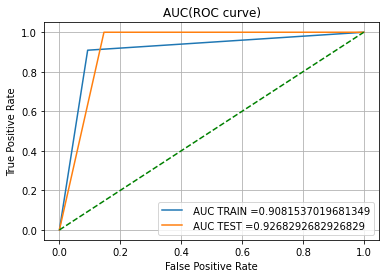

In [364]:
model = SVC(kernel='linear')
model.fit(X_train_sv_3, y_train3)
y_train_pred=model.predict(X_train_sv_3)
y_test_pred=model.predict(X_test_sv_3)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train3, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test3, y_test_pred)

plt.grid()
plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#### Confusion Matrix

[[35  6]
 [ 0  7]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        41
           1       0.54      1.00      0.70         7

    accuracy                           0.88        48
   macro avg       0.77      0.93      0.81        48
weighted avg       0.93      0.88      0.89        48



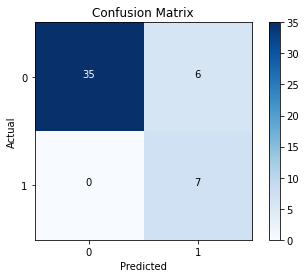

In [363]:
from sklearn.metrics import classification_report, confusion_matrix
cf=confusion_matrix(y_test3,y_test_pred)
print(confusion_matrix(y_test3,y_test_pred))
print(classification_report(y_test3,y_test_pred))
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_pred))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

# Extra Code

### Model Prediction

### Pass or Fail Probability for Absorbance value at given Frequency

In [825]:
y_label=a_data.OverallPoF
x_freq=a_data.filter(regex='f.*')
x_freq

f226    f257    f280    f297    f324    f343    f363    f385    f408  \
0    0.0987  0.1274  0.1592  0.1737  0.1700  0.1617  0.1640  0.1799  0.1932   
1    0.1114  0.1501  0.1860  0.2033  0.1953  0.1831  0.1825  0.1934  0.2047   
2    0.1096  0.1509  0.1941  0.2156  0.2139  0.2065  0.2172  0.2413  0.2607   
3    0.0748  0.0953  0.1190  0.1285  0.1233  0.1151  0.1169  0.1294  0.1411   
4    0.1863  0.2230  0.2641  0.2836  0.2794  0.2685  0.2701  0.2846  0.3011   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
234  0.0663  0.0736  0.1023  0.1360  0.1672  0.1821  0.1816  0.1662  0.1411   
235  0.0688  0.0738  0.0951  0.1238  0.1484  0.1611  0.1607  0.1484  0.1290   
236  0.1016  0.1186  0.1060  0.2803  0.1910  0.1980  0.1089  0.0182  0.0000   
237  0.0366  0.0414  0.0577  0.0803  0.0986  0.0925  0.0468  0.0273  0.0332   
238  0.0267  0.0294  0.0424  0.0599  0.0779  0.0837  0.0793  0.0610  0.0361   

       f432  ...   f6168   f6349   f6535   f6727   f6924   f7127   f7336  \
0    0.1969  ...  0.5370  0.4869  0.4301  0.4080  0.3804  0.3291  0.2951   
1    0.2090  ...  0.2636  0.2578  0.2443  0.2549  0.2604  0.2397  0.2299   
2    0.2706  ...  0.4269  0.4142  0.3910  0.3799  0.3740  0.3536  0.3473   
3    0.1465  ...  0.0077  0.0123  0.0066  0.0000  0.0126  0.0231  0.0405   
4    0.3072  ...  0.2332  0.2216  0.2228  0.2653  0.2596  0.2576  0.2838   
..      ...  ...     ...     ...     ...     ...     ...     ...     ...   
234  0.1296  ...  0.2221  0.1930  0.1592  0.1549  0.1346  0.1250  0.1125   
235  0.1222  ...  0.5130  0.4766  0.4316  0.4108  0.3587  0.3216  0.2877   
236  0.1993  ...  0.6157  0.5506  0.4832  0.4501  0.3983  0.3545  0.3115   
237  0.0430  ...  0.3333  0.2819  0.2302  0.2029  0.1586  0.1279  0.0934   
238  0.0231  ...  0.6628  0.5951  0.5295  0.4979  0.4539  0.4229  0.3871   

      f7550   f7772   f8000  
0    0.2530  0.2282  0.2003  
1    0.2048  0.1917  0.1659  
2    0.3237  0.3056  0.2881  
3    0.0401  0.0391  0.0258  
4    0.3598  0.3953  0.3642  
..      ...     ...     ...  
234  0.1242  0.1356  0.1372  
235  0.3026  0.2838  0.2682  
236  0.3136  0.2871  0.2679  
237  0.0612  0.0427  0.0031  
238  0.4081  0.3874  0.3852  

[239 rows x 107 columns]

In [826]:
data=pd.concat([x_freq,y_label],axis=1)
plot_data=pd.melt(data,'OverallPoF')
plot_data['PoF'] = np.where(plot_data['OverallPoF']==0, 'Pass', 'Fail')
plot_data.head(5)

OverallPoF variable   value   PoF
0           1     f226  0.0987  Fail
1           0     f226  0.1114  Pass
2           0     f226  0.1096  Pass
3           0     f226  0.0748  Pass
4           1     f226  0.1863  Fail

<AxesSubplot:xlabel='value', ylabel='OverallPoF'>

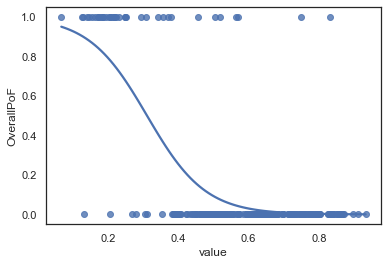

In [827]:
    x = plot_data.loc[(plot_data['variable']=='f1296')].value
    y = plot_data.loc[(plot_data['variable']=='f1296')].OverallPoF
    sb.regplot(x=x, y=y, data=data, logistic=True, ci=None)

In [ ]:
for i in x_freq.columns.values:
    x = plot_data.loc[(plot_data['variable']=='f1296')].value
    y = plot_data.loc[(plot_data['variable']=='f1296')].OverallPoF
    sb.regplot(x=x, y=y, data=data, logistic=True, ci=None)

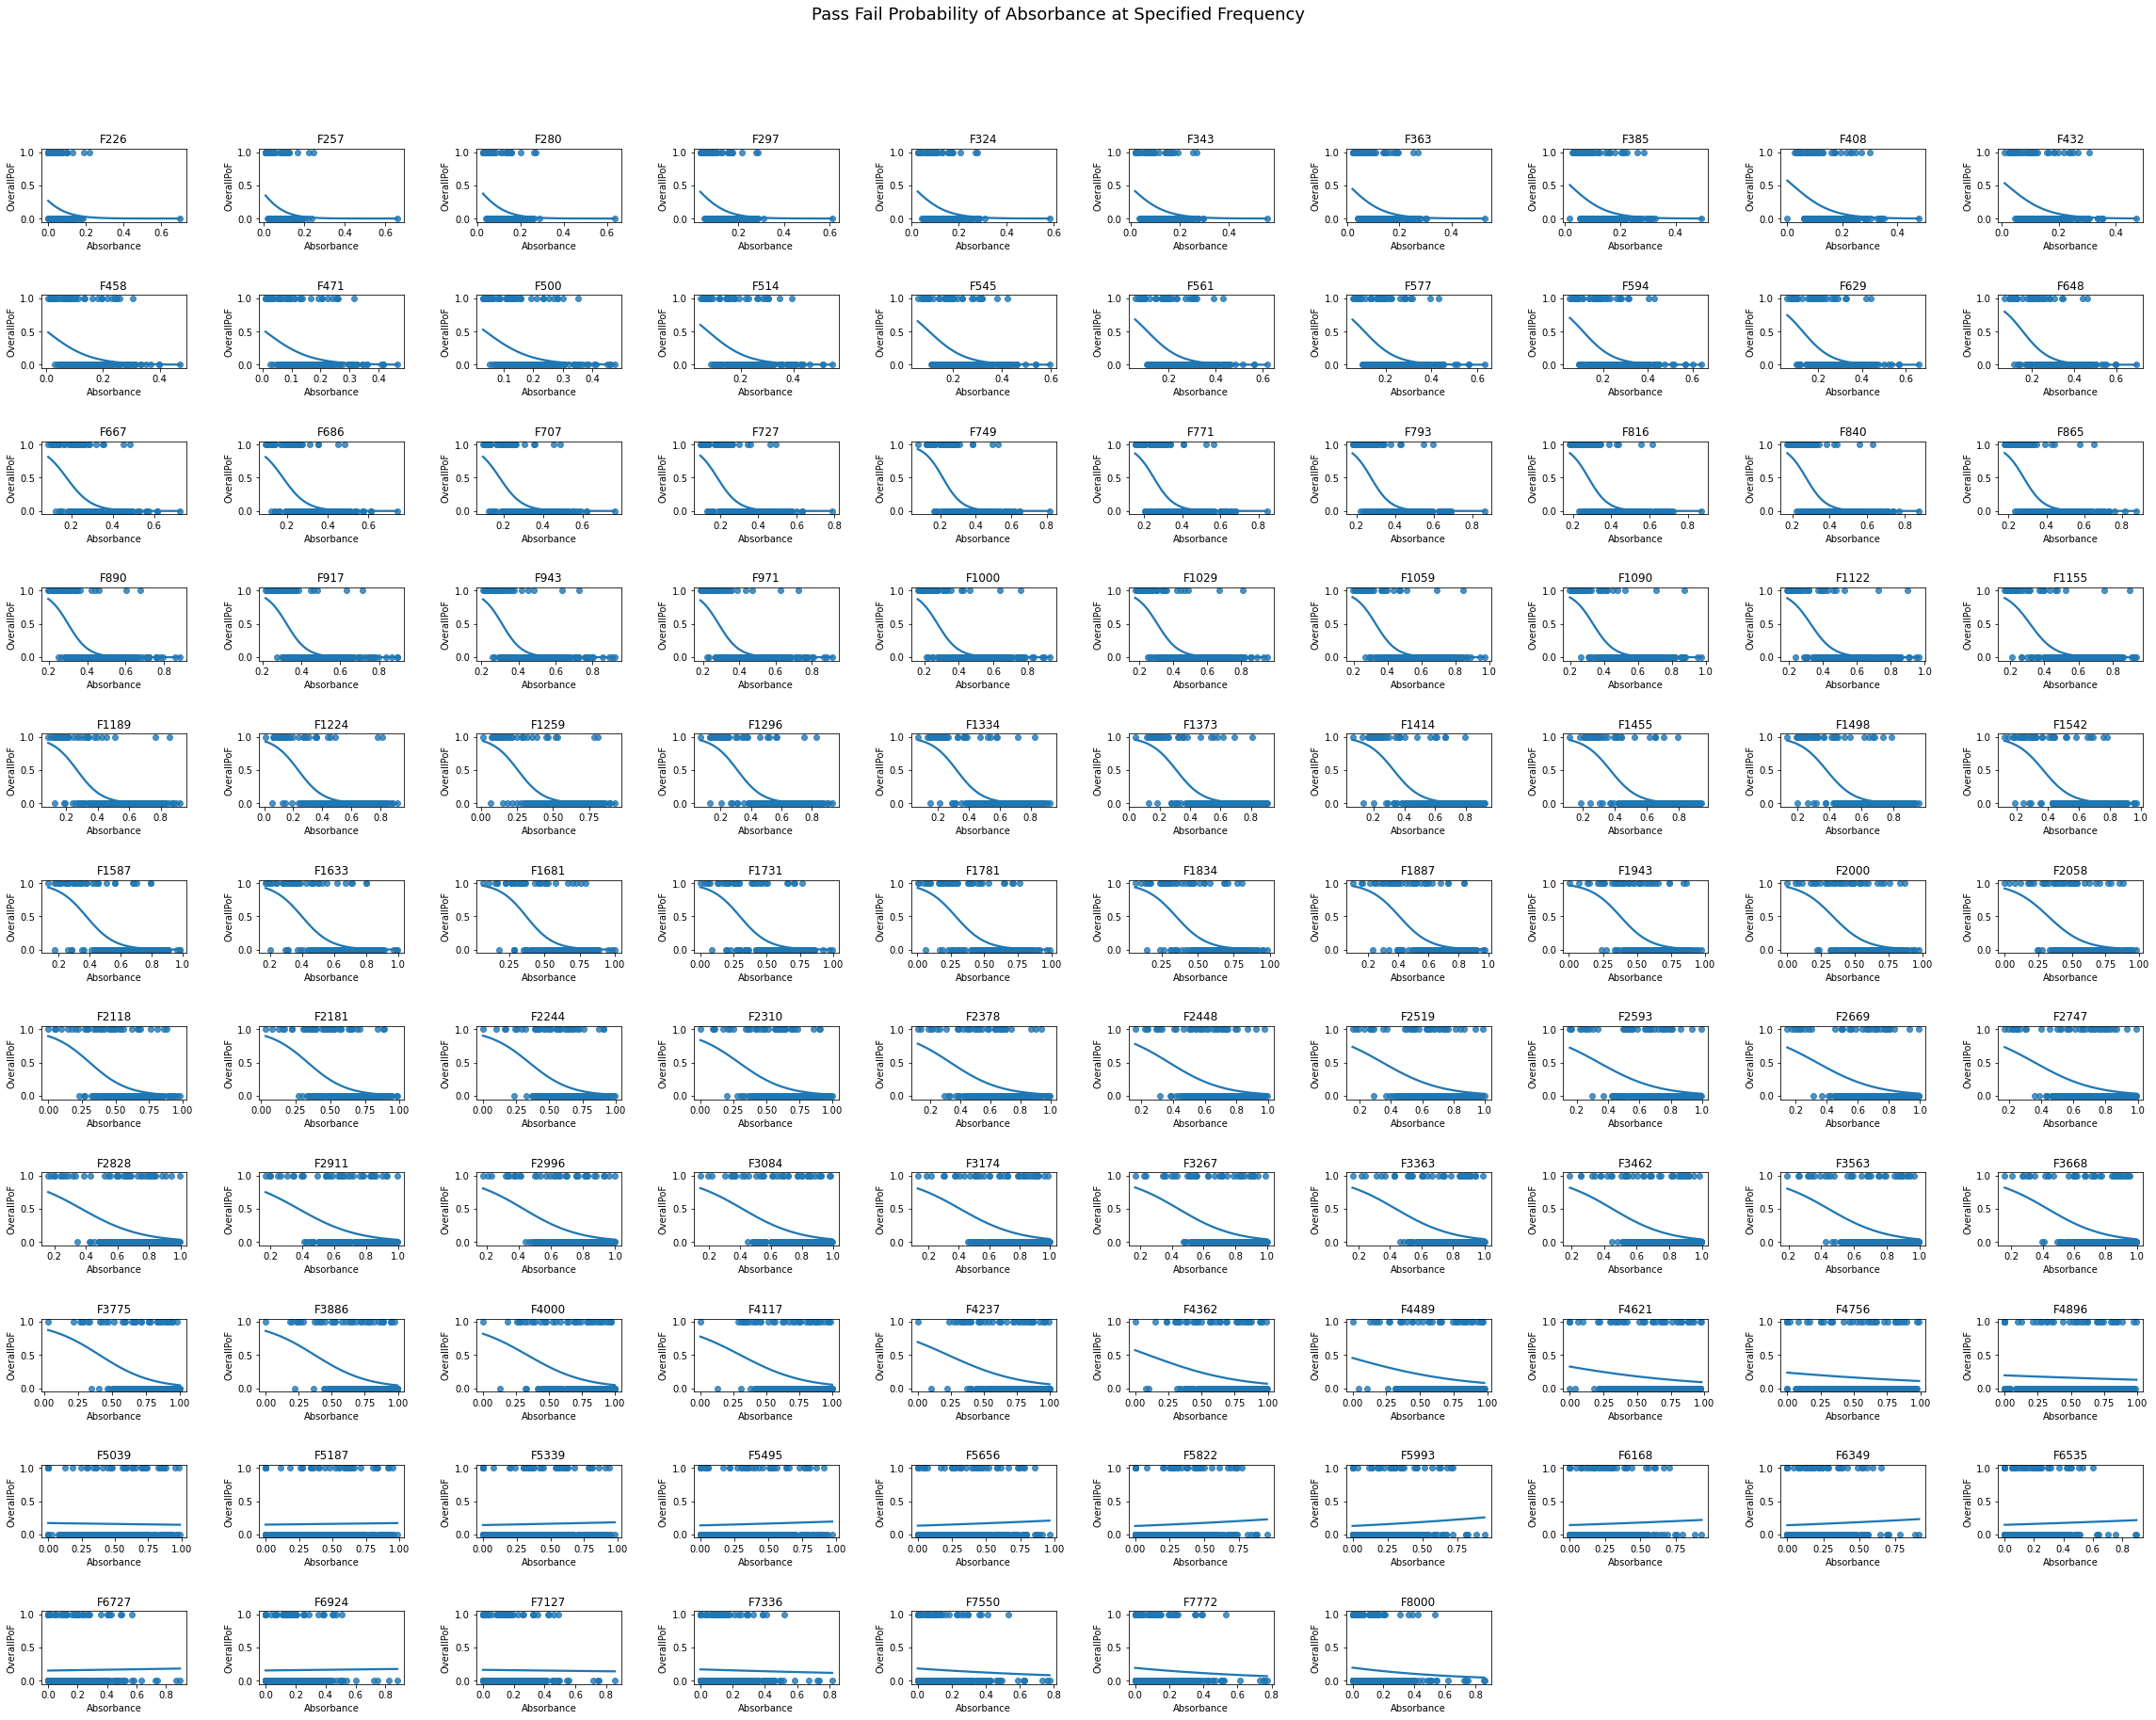

In [143]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 30))
plt.subplots_adjust(hspace=1,wspace=0.5)
plt.suptitle("Pass Fail Probability of Absorbance at Specified Frequency", fontsize=18, y=0.95)

freq=x_freq.columns.values

# set number of columns (use 3 to demonstrate the change)
ncols = 10
# calculate number of rows
nrows = len(freq) // ncols + (len(freq) % ncols > 0)

# loop through the length of freq and keep track of index
for n, variable in enumerate(freq):
    x = plot_data.loc[(plot_data['variable']==variable)].value
    y = plot_data.loc[(plot_data['variable']==variable)].OverallPoF
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, n + 1)

    # filter df and plot ticker on the new subplot axis
    sb.regplot(x=x, y=y, data=data, logistic=True, ci=None,ax=ax)
    
    # chart formatting
    ax.set_title(variable.upper())
    ax.set_xlabel("Absorbance")


### Full dataset

In [61]:
a_data = pd.read_csv('00 - Dataset/02 - Cleaning Results/a_data.csv')
y_data = pd.read_csv('00 - Dataset/02 - Cleaning Results/y_data.csv')
p_data = pd.read_csv('00 - Dataset/02 - Cleaning Results/p_data.csv')

Text(0.5, 0, 'AgeY')

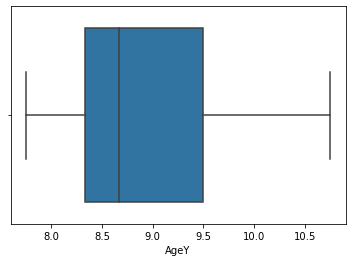

In [62]:
age_range=a_data.AgeM/12
sb.boxplot(age_range)
plt.xlabel('AgeY')

## Multi-collinearity

In [1194]:
a_freq.head(10)

f226    f257    f280    f297    f324    f343    f363    f385    f408  \
0  0.0987  0.1274  0.1592  0.1737  0.1700  0.1617  0.1640  0.1799  0.1932   
1  0.1114  0.1501  0.1860  0.2033  0.1953  0.1831  0.1825  0.1934  0.2047   
2  0.1096  0.1509  0.1941  0.2156  0.2139  0.2065  0.2172  0.2413  0.2607   
3  0.0748  0.0953  0.1190  0.1285  0.1233  0.1151  0.1169  0.1294  0.1411   
4  0.1863  0.2230  0.2641  0.2836  0.2794  0.2685  0.2701  0.2846  0.3011   
5  0.0629  0.0872  0.1158  0.1232  0.1106  0.0909  0.0876  0.0989  0.1086   
6  0.1858  0.2359  0.2883  0.3098  0.3085  0.2963  0.3020  0.3259  0.3525   
7  0.0922  0.1200  0.1509  0.1608  0.1514  0.1367  0.1368  0.1520  0.1651   
8  0.0855  0.1113  0.1403  0.1513  0.1421  0.1286  0.1272  0.1391  0.1488   
9  0.0802  0.1075  0.1381  0.1499  0.1418  0.1305  0.1347  0.1555  0.1741   

     f432  ...   f6168   f6349   f6535   f6727   f6924   f7127   f7336  \
0  0.1969  ...  0.5370  0.4869  0.4301  0.4080  0.3804  0.3291  0.2951   
1  0.2090  ...  0.2636  0.2578  0.2443  0.2549  0.2604  0.2397  0.2299   
2  0.2706  ...  0.4269  0.4142  0.3910  0.3799  0.3740  0.3536  0.3473   
3  0.1465  ...  0.0077  0.0123  0.0066  0.0000  0.0126  0.0231  0.0405   
4  0.3072  ...  0.2332  0.2216  0.2228  0.2653  0.2596  0.2576  0.2838   
5  0.1038  ...  0.3060  0.2820  0.2514  0.2772  0.2874  0.2652  0.2532   
6  0.3506  ...  0.3105  0.3007  0.2798  0.2993  0.3104  0.2900  0.2722   
7  0.1668  ...  0.5026  0.4620  0.4212  0.4585  0.4445  0.3930  0.3481   
8  0.1483  ...  0.5508  0.5223  0.4925  0.5215  0.5169  0.4954  0.4576   
9  0.1812  ...  0.3567  0.3303  0.2894  0.3037  0.2970  0.2558  0.2121   

    f7550   f7772   f8000  
0  0.2530  0.2282  0.2003  
1  0.2048  0.1917  0.1659  
2  0.3237  0.3056  0.2881  
3  0.0401  0.0391  0.0258  
4  0.3598  0.3953  0.3642  
5  0.2341  0.2317  0.2030  
6  0.2397  0.2260  0.1966  
7  0.3271  0.3439  0.2956  
8  0.4232  0.4244  0.3792  
9  0.1836  0.1937  0.1499  

[10 rows x 107 columns]

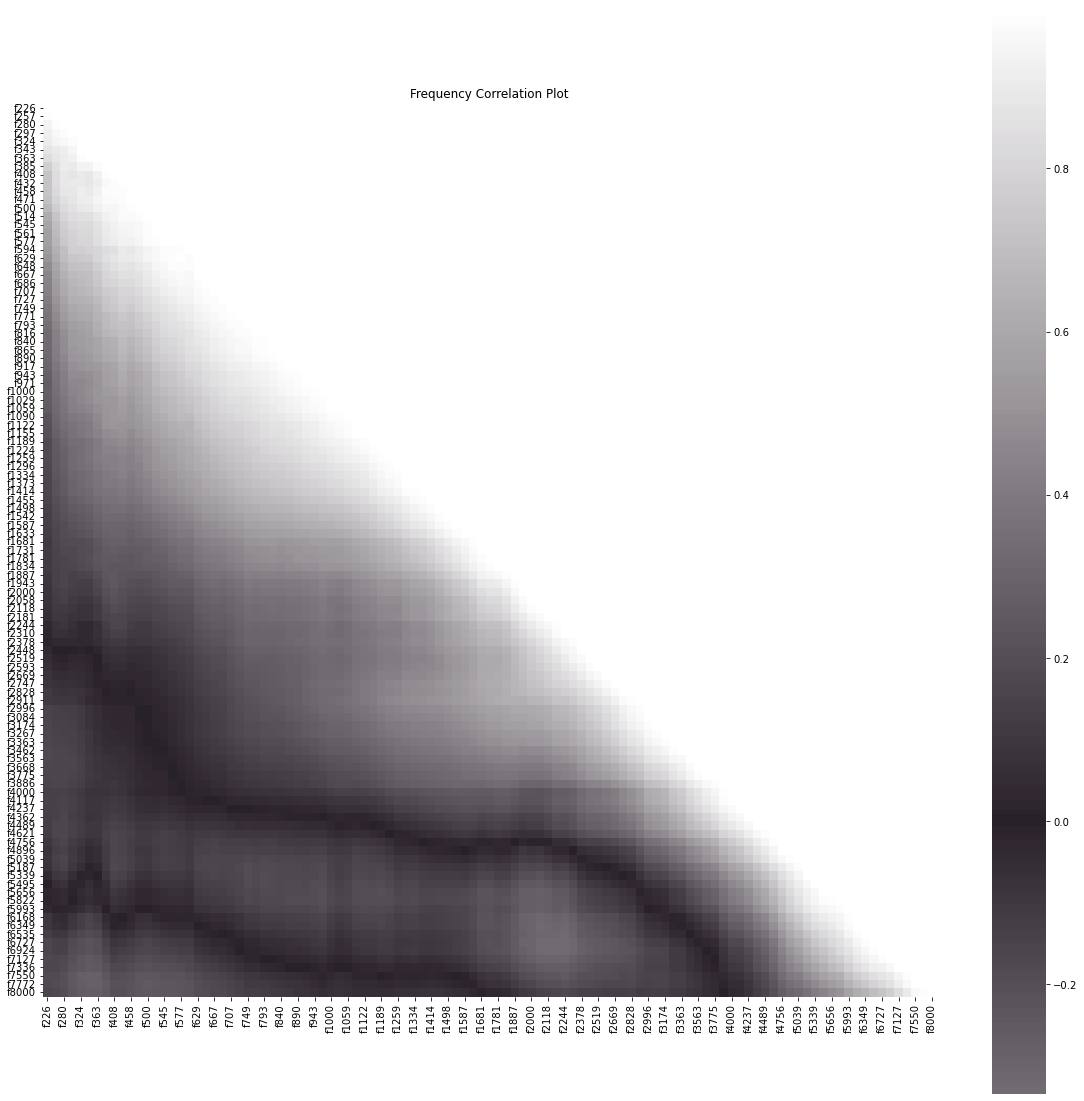

In [1197]:

corr = a_freq.corr()

# Create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a custom divergin palette
cmap = sb.diverging_palette(0, 0, s=100,l=100,center='dark',as_cmap=True)

plt.figure(figsize=(20, 20))
sb.heatmap(corr, mask=mask, center=0, annot=False,
            fmt='.2f', square=True, cmap=cmap)
plt.title("Frequency Correlation Plot")
plt.show();

## Functions

In [8]:
def sliding_window(df,window,counter):
    test_freqs=df.filter(regex=("f.*"))
    feature_idx_end=df.columns.get_loc("Ear.coded")+1
    features=df.iloc[:,:feature_idx_end]
    window_start=window*(counter-1)
    window_end=window*(counter)
    select_freq=test_freqs.iloc[:,window_start:window_end]
    data_window=pd.concat([features,select_freq],axis=1)
    return data_window

def split(data):
    y=data.loc[:,"OverallPoF"]
    X=data.drop(["OverallPoF"],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state=20)
    return X_train,X_test,y_train,y_test

def split_window(data,window,counter):
    X_train=split(sliding_window(data,window,counter))[0]
    Y_train=split(sliding_window(data,window,counter))[2]
    x_test=split(sliding_window(data,window,counter))[1]
    y_test=split(sliding_window(data,window,counter))[3]
    return X_train,x_test,Y_train,y_test

def mix_sort(string):
    return list(map(int,re.findall(r'\d+',string)))[0]

## Loading data set

In [9]:
a_data=pd.read_csv("a_data.csv")
a_data.head()

Gender  AgeM   ECV  TPP    SC  TympPoF  OAE1  OAE1.4  OAE2  OAE2.8  ...  \
0       0   112  1.08    0  0.52        1   3.0    10.0  18.0    14.0  ...   
1       0   114  1.28    0  1.28        0   7.0     4.0   9.0     5.0  ...   
2       1   118  1.26    0  0.87        0   9.0    12.0   8.0    12.0  ...   
3       0   119  0.64    0  0.60        0  13.0     9.0  13.0    11.0  ...   
4       0    95  0.92    0  1.65        0   7.0     0.0   2.0    12.0  ...   

    f6168   f6349   f6535   f6727   f6924   f7127   f7336   f7550   f7772  \
0  0.5370  0.4869  0.4301  0.4080  0.3804  0.3291  0.2951  0.2530  0.2282   
1  0.2636  0.2578  0.2443  0.2549  0.2604  0.2397  0.2299  0.2048  0.1917   
2  0.4269  0.4142  0.3910  0.3799  0.3740  0.3536  0.3473  0.3237  0.3056   
3  0.0077  0.0123  0.0066  0.0000  0.0126  0.0231  0.0405  0.0401  0.0391   
4  0.2332  0.2216  0.2228  0.2653  0.2596  0.2576  0.2838  0.3598  0.3953   

    f8000  
0  0.2003  
1  0.1659  
2  0.2881  
3  0.0258  
4  0.3642  

[5 rows x 121 columns]

## Splitting Training and Testing Set

In [10]:
## Left = 0 Right = 1

In [11]:
# col_exclusion=["OAEPoF","TympPoF"] ## Determined that Gender SC and ECV take up too much variance
col_exclusion=["OAEPoF","TympPoF","Gender","ECV","SC"]

In [12]:
data=a_data.drop(col_exclusion,axis=1)
# data.columns.values.tolist()

In [13]:
y=data.loc[:,"OverallPoF"]
X=data.drop(["OverallPoF"],axis=1)

In [14]:
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state=12)
# X_train.columns.values.tolist()

In [15]:
X_train

AgeM  TPP  OAE1  OAE1.4  OAE2  OAE2.8  OAE4  Ear.coded    f226    f257  \
216    97    0   7.5     9.7   8.3     9.5  13.3          1  0.0575  0.0933   
36    121    8  16.0    11.0  16.0     8.0   3.0          0  0.0612  0.1023   
1     114    0   7.0     4.0   9.0     5.0   6.0          0  0.1114  0.1501   
179   117    0   5.7     7.6   0.0     0.4   0.0          1  0.0082  0.0325   
51    105    0   0.0     0.0   0.0     0.0   0.0          0  0.0000  0.0104   
..    ...  ...   ...     ...   ...     ...   ...        ...     ...     ...   
3     119    0  13.0     9.0  13.0    11.0  12.0          0  0.0748  0.0953   
130   103    0   3.0     8.0  17.0    12.0   5.0          1  0.1426  0.1903   
134   103    0   6.0    15.0   9.0    12.0  10.0          1  0.0630  0.0828   
155   121    0  13.0    24.0  18.0    11.0   6.0          1  0.0599  0.1016   
75    106    0  11.5     9.1  16.0    15.2  12.3          0  0.0008  0.0291   

     ...   f6168   f6349   f6535   f6727   f6924   f7127   f7336   f7550  \
216  ...  0.0328  0.0374  0.0126  0.0112  0.0307  0.0162  0.0208  0.0144   
36   ...  0.1940  0.2110  0.2030  0.2176  0.2472  0.2470  0.2682  0.2718   
1    ...  0.2636  0.2578  0.2443  0.2549  0.2604  0.2397  0.2299  0.2048   
179  ...  0.2717  0.2478  0.2058  0.1763  0.1718  0.1403  0.1255  0.0935   
51   ...  0.0426  0.0454  0.0011  0.0211  0.0593  0.0151  0.0000  0.0000   
..   ...     ...     ...     ...     ...     ...     ...     ...     ...   
3    ...  0.0077  0.0123  0.0066  0.0000  0.0126  0.0231  0.0405  0.0401   
130  ...  0.5017  0.4453  0.3836  0.3349  0.3005  0.2659  0.2559  0.2345   
134  ...  0.1984  0.1776  0.1440  0.1469  0.1433  0.1191  0.1015  0.0759   
155  ...  0.2228  0.2295  0.2087  0.2101  0.2288  0.2213  0.2421  0.2534   
75   ...  0.1968  0.1707  0.1183  0.1140  0.1172  0.0695  0.0486  0.0132   

      f7772   f8000  
216  0.0337  0.0217  
36   0.3107  0.3356  
1    0.1917  0.1659  
179  0.1069  0.0527  
51   0.0000  0.0000  
..      ...     ...  
3    0.0391  0.0258  
130  0.2119  0.1923  
134  0.0688  0.0387  
155  0.2857  0.2966  
75   0.0298  0.0000  

[191 rows x 115 columns]

## Resampling methods

In [43]:
fails=sum(data.OverallPoF==1)
fails

38

In [44]:
passes=sum(data.OverallPoF==0)
passes

201

In [45]:
len(X_train.columns.values)

9

## Feature Selection

### Feature selection - Sliding window set size

In [57]:
# We need to exclude gender SC and ECV
from sklearn import svm
window_list=[107]
counter_list=[1]

feat_rank={}

for i, window in enumerate(window_list):

    svm_clf = svm.SVC(kernel='linear')
    counter=counter_list[i]
    for j in range(1,counter+1):
        X_train=split_window(data,window,j)[0]
        # x_test=split_window(data,window,j)[1]
        Y_train=split_window(data,window,j)[2]
        # y_test=split_window(data,window,j)[3]

        svm_clf.fit(X_train, Y_train)
        # ax=pd.Series(abs(svm_clf.coef_[0]), index=X_train.columns).nlargest(10).plot(kind='barh')
        # ax.invert_yaxis()
        rank=pd.Series(abs(svm_clf.coef_[0]), index=X_train.columns).nlargest(115).index
    for i, c in enumerate(rank):
        feat_rank[c]=feat_rank.get(c,0)+i

In [58]:
pd.Series(abs(svm_clf.coef_[0]), index=X_train.columns).nlargest(20).index

Index(['f8000', 'f1731', 'f7772', 'f226', 'f5993', 'f1681', 'f257', 'f4000',
       'f1781', 'Ear.coded', 'f280', 'f3084', 'f2996', 'f7550', 'f1059',
       'f1090', 'f1943', 'f1834', 'f297', 'f4117'],
      dtype='object')

In [59]:
feature_ranking=pd.DataFrame(list(feat_rank.items()),columns=['Frequency','Ranking'])
feature_ranking.sort_values(by=['Ranking']).head(50)
frequency_ranking=feature_ranking[feature_ranking["Frequency"].str.contains("f.")]

In [60]:
rank

Index(['f8000', 'f1731', 'f7772', 'f226', 'f5993', 'f1681', 'f257', 'f4000',
       'f1781', 'Ear.coded',
       ...
       'OAE4', 'TPP', 'f6349', 'f3363', 'f1224', 'f1259', 'OAE2.8', 'f5822',
       'f6535', 'f2669'],
      dtype='object', length=115)

In [61]:
fnew=frequency_ranking.copy()

In [62]:
freq_values=frequency_ranking['Frequency'].apply(lambda string: int(string.replace('f',''))).to_numpy()
fnew["fval"]=freq_values

In [63]:
fnew.sort_values('fval',ascending=True,inplace=True)

### Feature selection - Sliding window set size

In [65]:
split_window(data,20,1)[0]

AgeM  TPP  OAE1  OAE1.4  OAE2  OAE2.8  OAE4  Ear.coded    f226    f257  \
219   102    0   4.5    13.7   8.6     5.8   7.2          1  0.0348  0.0649   
206    95    0   9.4     9.8   8.1    11.9   9.8          1  0.0111  0.0361   
154   117    0  20.0    20.0  18.0    11.0  14.0          1  0.0804  0.1149   
120   112    0   4.0     7.0  11.0     5.0   8.0          1  0.1036  0.1326   
59    116    0  16.5    24.5  18.5     6.1   6.4          0  0.0480  0.0843   
..    ...  ...   ...     ...   ...     ...   ...        ...     ...     ...   
156   100    0   7.0     9.0  17.0    20.0  11.0          1  0.0163  0.0444   
223    99    0  29.2    17.8  16.6     4.8   5.9          1  0.0207  0.0482   
15    102    0   5.0     3.0   3.0    18.0  13.0          0  0.0620  0.0815   
218    97    0   0.0     6.7   9.2    10.0   5.8          1  0.0000  0.0101   
99     97    0   3.0     8.1   8.5     3.4   6.3          0  0.0310  0.0488   

     ...    f458    f471    f500    f514    f545    f561    f577    f594  \
219  ...  0.1361  0.1437  0.1730  0.2092  0.2331  0.2395  0.2361  0.2422   
206  ...  0.0634  0.0643  0.0881  0.1209  0.1440  0.1477  0.1446  0.1501   
154  ...  0.2213  0.2366  0.2700  0.3167  0.3511  0.3705  0.3779  0.3917   
120  ...  0.2209  0.2352  0.2699  0.3089  0.3326  0.3396  0.3364  0.3376   
59   ...  0.1759  0.1881  0.2247  0.2702  0.3000  0.3093  0.3096  0.3165   
..   ...     ...     ...     ...     ...     ...     ...     ...     ...   
156  ...  0.0823  0.0867  0.1191  0.1603  0.1899  0.1969  0.1923  0.1985   
223  ...  0.0821  0.0832  0.1136  0.1569  0.1864  0.1934  0.1862  0.1873   
15   ...  0.0875  0.0914  0.1174  0.1516  0.1718  0.1719  0.1598  0.1528   
218  ...  0.0180  0.0163  0.0327  0.0570  0.0725  0.0734  0.0671  0.0668   
99   ...  0.0510  0.0488  0.0641  0.0867  0.1007  0.1002  0.0929  0.0910   

       f629    f648  
219  0.2593  0.2828  
206  0.1675  0.1927  
154  0.4153  0.4446  
120  0.3487  0.3657  
59   0.3354  0.3588  
..      ...     ...  
156  0.2212  0.2562  
223  0.2088  0.2414  
15   0.1613  0.1813  
218  0.0777  0.0958  
99   0.1009  0.1164  

[191 rows x 28 columns]

### Feature score - Sliding window multiple size

In [74]:
# We need to exclude gender SC and ECV
from sklearn import svm
window_list=[107,53,26,15,7,4,2,1]
counter_list=[1,2,4,7,15,26,53,107]

feat_rank={}

for i, window in enumerate(window_list):

    svm_clf = svm.SVC(kernel='linear')
    counter=counter_list[i]
    for j in range(1,counter+1):
        X_train=split_window(data,window,j)[0]
        # x_test=split_window(data,window,j)[1]
        Y_train=split_window(data,window,j)[2]
        # y_test=split_window(data,window,j)[3]

        svm_clf.fit(X_train, Y_train)
        # ax=pd.Series(abs(svm_clf.coef_[0]), index=X_train.columns).nlargest(10).plot(kind='barh')
        # ax.invert_yaxis()
        rank=pd.Series(abs(svm_clf.coef_[0]), index=X_train.columns).nlargest(115).index
    for i, c in enumerate(rank):
        feat_rank[c]=feat_rank.get(c,0)+i

In [75]:
feature_ranking=pd.DataFrame(list(feat_rank.items()),columns=['Frequency','Ranking'])
feature_ranking.sort_values(by=['Ranking']).head(50)
frequency_ranking=feature_ranking[feature_ranking["Frequency"].str.contains("f.")]

In [76]:
fnew=frequency_ranking.copy()

In [77]:
freq_values=frequency_ranking['Frequency'].apply(lambda string: int(string.replace('f',''))).to_numpy()
fnew["fval"]=freq_values

In [116]:
fnew.sort_values('fval',ascending=True,inplace=True)
fnew.head(50)

Frequency  Ranking  fval
3        f226        3   226
6        f257        6   257
10       f280       10   280
18       f297       18   297
33       f324       33   324
54       f343       54   343
74       f363       74   363
80       f385       80   385
76       f408       76   408
64       f432       64   432
87       f458       87   458
95       f471       95   471
93       f500       93   500
75       f514       75   514
72       f545       72   545
66       f561       66   561
91       f577       91   577
88       f594       88   594
81       f629       81   629
65       f648       65   648
39       f667       39   667
47       f686       47   686
61       f707       61   707
67       f727       67   727
58       f749       58   749
50       f771       50   771
59       f793       59   793
55       f816       55   816
71       f840       71   840
53       f865       53   865
46       f890       46   890
35       f917       35   917
45       f943       45   943
40       f971       40   971
41      f1000       41  1000
22      f1029       22  1029
14      f1059       14  1059
15      f1090       15  1090
34      f1122       34  1122
57      f1155       57  1155
98      f1189       98  1189
109     f1224      109  1224
110     f1259      110  1259
96      f1296       96  1296
69      f1334       69  1334
83      f1373       83  1373
89      f1414       89  1414
68      f1455       68  1455
44      f1498       44  1498
36      f1542       36  1542

In [140]:
max_score=fnew.Ranking.max()
rank=fnew['Ranking'].apply(lambda val: abs(val-max_score)).to_numpy()
fnew["rank"]=rank
fnew.head(10)

Frequency  Ranking  fval  rank
3       f226        3   226   207
6       f257        6   257   204
10      f280       10   280   200
18      f297       18   297   192
33      f324       33   324   177
54      f343       54   343   156
74      f363       74   363   136
80      f385       80   385   130
76      f408       76   408   134
64      f432       64   432   146

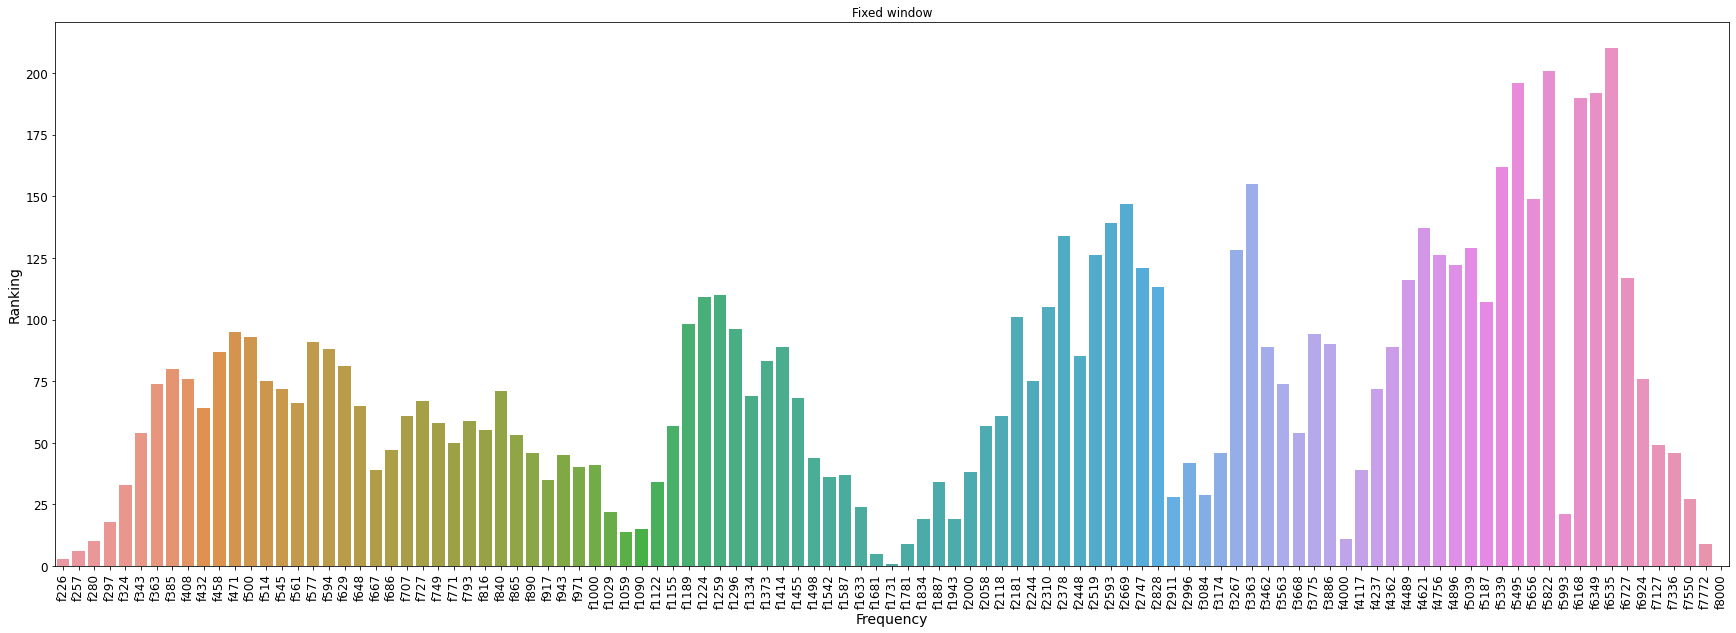

In [142]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 10]
sb.barplot(x='Frequency',y='Ranking',data=fnew)
plt.xticks(rotation=90)
plt.title("Fixed window");

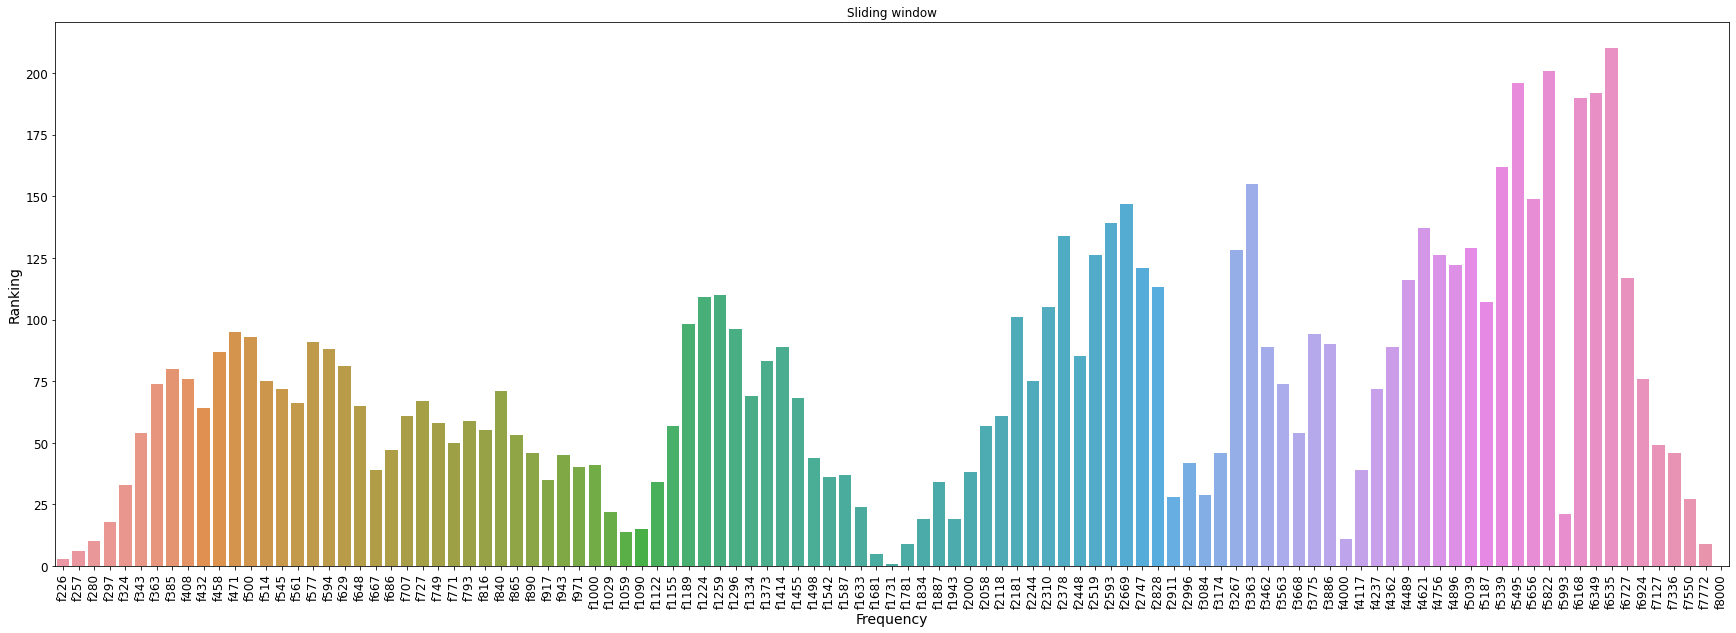

In [81]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 10]
sb.barplot(x='Frequency',y='Ranking',data=fnew)
plt.xticks(rotation=90)
plt.title("Sliding window");

In [82]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

## SVM RBF

In [119]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline as pipe

rbf_svc=pipe([
    ("scaler",StandardScaler()),
    ("svm_clf",SVC(kernel="rbf",gamma=0.01,C=1))
])
rbf_svc.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=1, gamma=0.01))])

In [120]:
y_pred=rbf_svc.predict(x_test)
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0], dtype=int64)

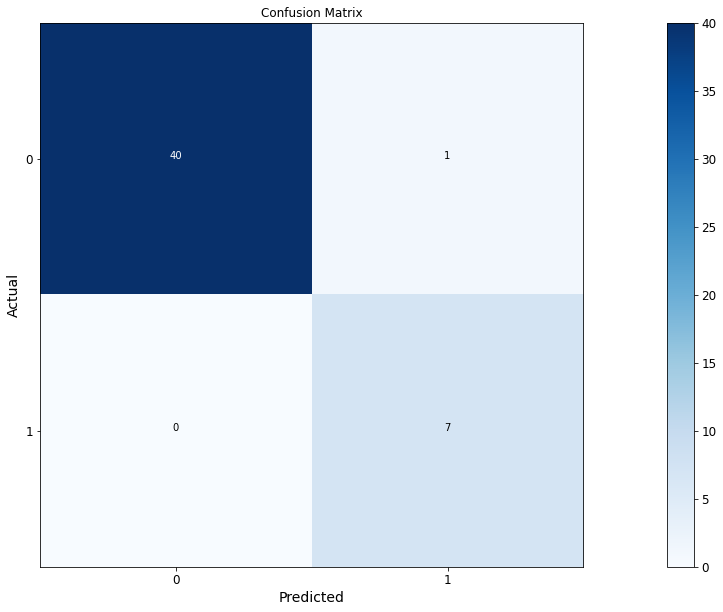

In [122]:
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_pred))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

In [121]:
from sklearn.metrics import classification_report, confusion_matrix
cf=confusion_matrix(y_test,y_pred)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[40  1]
 [ 0  7]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        41
           1       0.88      1.00      0.93         7

    accuracy                           0.98        48
   macro avg       0.94      0.99      0.96        48
weighted avg       0.98      0.98      0.98        48



## ROC Analysis

C:\Users\AndyJ\anaconda3\envs\py\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


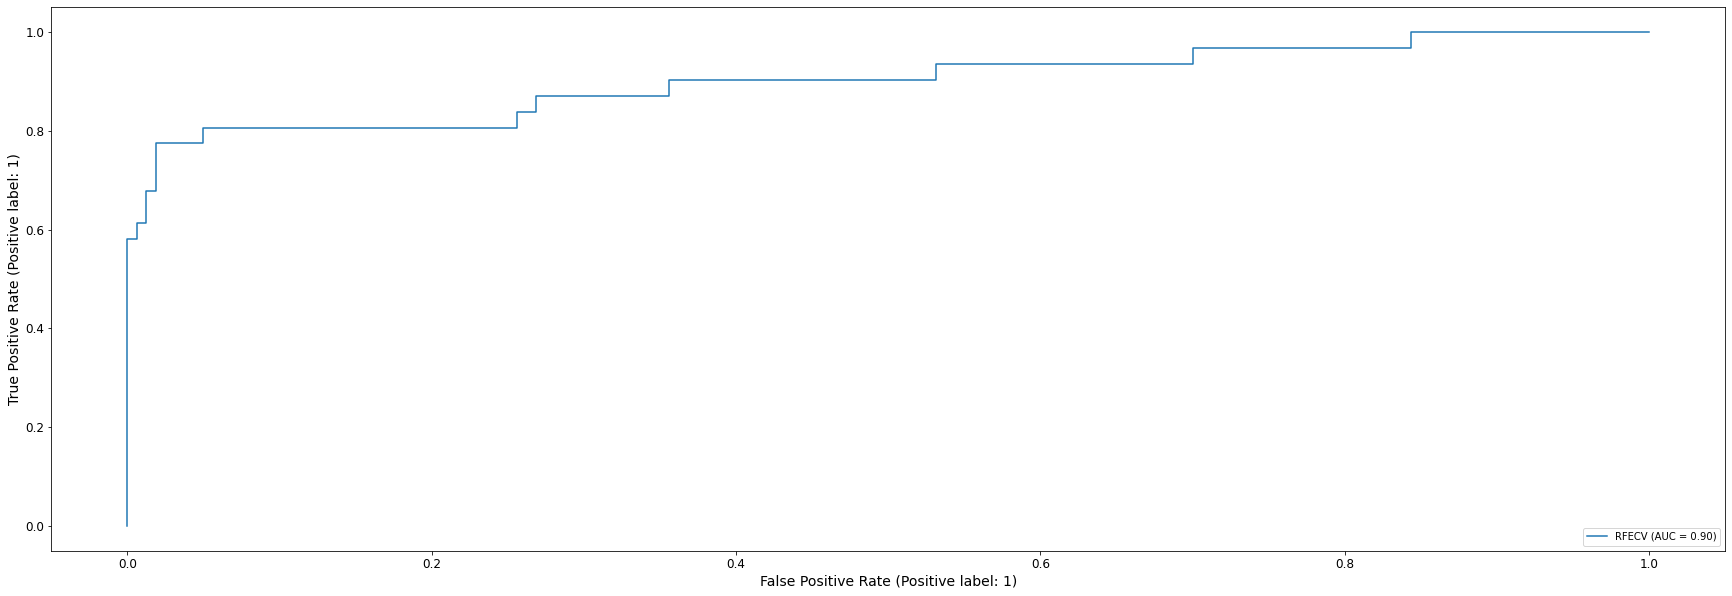

In [99]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rfecv, X_train,Y_train )

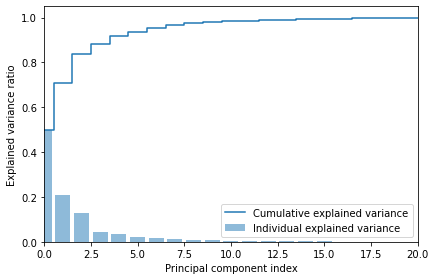

In [330]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
sc = StandardScaler()
sc.fit(X_train3)
X_train3_std = sc.transform(X_train3)
X_test3_std = sc.transform(X_test3)
#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
X_train3_pca = pca.fit_transform(X_train3_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.xlim(0,20)
plt.show()

In [330]:
from sklearn.metrics import classification_report, confusion_matrix
cf=confusion_matrix(y_test,y_pred)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[40  1]
 [ 0  7]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        41
           1       0.88      1.00      0.93         7

    accuracy                           0.98        48
   macro avg       0.94      0.99      0.96        48
weighted avg       0.98      0.98      0.98        48

